In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import glob
import scipy.stats as stats
import seaborn as sns

from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from scipy.stats import zscore
from statsmodels.stats.multicomp import MultiComparison

from hmmlearn import hmm

Behav = ["Walking", "Sniffing", "Immobile", "Rearing", "Grooming"]
behav_num = len(Behav)
label_num = 20

def SE(data):
    return np.std(data)/np.sqrt(np.size(data))

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/479030532.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Data load

In [2]:
############################ Load A-SOiD annotated behavior data, stimulation data ############################
PNOC_behav_files = glob.glob("/Volumes/KIOXIA/PNOC_opto/*2.npy")
PNOC_behav_files.sort()
NTS_behav_files = glob.glob("/Volumes/KIOXIA/NTS_opto/*2.npy")
NTS_behav_files.sort()
print("PNOC mice: n=", np.size(PNOC_behav_files))
print("NTS mice: n=", np.size(NTS_behav_files))

PNOC_stim_files = [
    "/Volumes/KIOXIA/PNOC_opto/PNOC_ChRmsone_DA3h_CPu_5DM4DL_mice4035_2024-03-27T13_39_25.csv",
    "/Volumes/KIOXIA/PNOC_opto/PNOC_Flpo_DA3h_DIO_ChRmsone_CPu_opto_CPu1_CPuStim4_Mice1_40hz_160p_ITI_60_90_2023-10-02T13_14_56.csv",
    "/Volumes/KIOXIA/PNOC_opto/PNOC_Flpo_DA3h_DIO_ChRmsone_CPu_opto_CPu1_CPuStim4_Mice2_40hz_160p_ITI_60_90_2023-10-02T13_55_34.csv",
    "/Volumes/KIOXIA/PNOC_opto/PNOC_Flpo_DA3h_DIO_ChRmsone_CPu_opto_CPu1_CPuStim4_Mice3_40hz_160p_ITI_60_90_2023-10-02T14_57_14.csv",
    "/Volumes/KIOXIA/PNOC_opto/opto_PNOC_ChRmsone_DA3h_CPu_1DM4DL_mice2_2024-03-19T10_09_09.csv",
    "/Volumes/KIOXIA/PNOC_opto/opto_PNOC_ChRmsone_DA3h_CPu_4DM1DL_mice1_2024-03-20T09_46_12.csv",
    "/Volumes/KIOXIA/PNOC_opto/opto_PNOC_ChRmsone_DA3h_CPu_4DM1DL_mice5_2024-03-20T11_19_40.csv",
    "/Volumes/KIOXIA/PNOC_opto/opto_PNOC_ChRmsone_DA3h_CPu_4DM1DL_mice6_2024-03-20T10_07_20.csv"
]

NTS_stim_files = [
    "/Volumes/KIOXIA/NTS_opto/NTS_ChRmsone_DA3h_CPu_5DM4DL_mice7121_2024-03-27T11_42_06.csv",
    "/Volumes/KIOXIA/NTS_opto/NTS_ChRmsone_DA3h_CPu_5DM4DL_mice7122_2024-03-27T11_23_40.csv",
    "/Volumes/KIOXIA/NTS_opto/NTS_Flpo_DA3h_DIO_ChRmsone_CPu_opto_CPu1_CPuStim4_Mice2_40hz_160p_ITI_60_90_2023-10-02T11_18_18.csv",
    "/Volumes/KIOXIA/NTS_opto/NTS_Flpo_DA3h_DIO_ChRmsone_CPu_opto_CPu1_CPuStim4_Mice3_40hz_160p_ITI_60_90_2023-10-02T11_51_28.csv",
    "/Volumes/KIOXIA/NTS_opto/NTS_Flpo_DA3h_DIO_ChRmsone_CPu_opto_CPu1_CPuStim4_Mice4_40hz_160p_ITI_60_90_2023-10-02T12_40_34.csv",
    "/Volumes/KIOXIA/NTS_opto/opto_NTS_ChRmsone_DA3h_CPu_1DM4DL_mice1_2024-03-21T08_50_53.csv",
    "/Volumes/KIOXIA/NTS_opto/opto_NTS_ChRmsone_DA3h_CPu_1DM4DL_mice3_2024-03-21T09_27_42.csv",
    "/Volumes/KIOXIA/NTS_opto/opto_NTS_ChRmsone_DA3h_CPu_1DM4DL_mice5_2024-03-19T10_50_53.csv",
    "/Volumes/KIOXIA/NTS_opto/opto_NTS_ChRmsone_DA3h_CPu_4DM1DL_mice2_2024-03-20T09_27_08.csv",
    "/Volumes/KIOXIA/NTS_opto/opto_NTS_ChRmsone_DA3h_CPu_4DM1DL_mice4_2024-03-20T08_46_22.csv",
    "/Volumes/KIOXIA/NTS_opto/opto_NTS_ChRmsone_DA3h_CPu_4DM1DL_mice6_2024-03-20T09_09_11.csv"
]

PNOC mice: n= 8
NTS mice: n= 11


In [3]:
############################ Save A-SOiD behavior data and stimulation data as .npy extension ############################
## PNOC
for i, file in enumerate(PNOC_stim_files):
    data = pd.read_csv(file)
    delete_list = []
    for j in range(len(data)-1):
        if data["Item2"][j] and not data["Item2"][j+1]:
            delete_list.append(j)
        elif not data["Item2"][j] and data["Item2"][j+1]:
            delete_list.append(j)
    data = data.drop(data.index[delete_list])
    data.reset_index()
    PNOC_stim = [True for j in range(data["Item1.Value"][0])]
    PNOC_stim = PNOC_stim + list(data["Item2"])
    PNOC_behav = np.load(PNOC_behav_files[i])
    print(len(PNOC_behav), len(PNOC_stim))
    np.save(f"PNOC_mouse{i+1}_behav", PNOC_behav)
    np.save(f"PNOC_mouse{i+1}_stim", PNOC_stim)

## NTS
for i, file in enumerate(NTS_stim_files):
    data = pd.read_csv(file)
    delete_list = []
    for j in range(len(data)-1):
        if data["Item2"][j] and not data["Item2"][j+1]:
            delete_list.append(j)
        elif not data["Item2"][j] and data["Item2"][j+1]:
            delete_list.append(j)
    data = data.drop(data.index[delete_list])
    data.reset_index()
    NTS_stim = [True for j in range(data["Item1.Value"][0])]
    NTS_stim = NTS_stim + list(data["Item2"])
    NTS_behav = np.load(NTS_behav_files[i])
    print(len(NTS_behav), len(NTS_stim))
    np.save(f"NTS_mouse{i+1}_behav", NTS_behav)
    np.save(f"NTS_mouse{i+1}_stim", NTS_stim)

37640 37640
26077 26077
26215 26215
26195 26195
28678 28678
29822 29822
35125 35125
38402 38402
31079 31079
28303 28303
26817 26817
27117 27117
24705 24705
27199 27199
26728 26728
27481 27481
27138 27138
28832 28832
26434 26434


In [4]:
############################# Load DLC data ############################
PNOC_DLC_files = glob.glob("/Volumes/KIOXIA/PNOC_opto/*filtered.csv")
PNOC_DLC_files.sort()
NTS_DLC_files = glob.glob("/Volumes/KIOXIA/NTS_opto/*filtered.csv")
NTS_DLC_files.sort()

print(len(PNOC_DLC_files))
print(len(NTS_DLC_files))


PNOC_DLC = [pd.read_csv(PNOC_DLC_files[i]) for i in range(8)]
NTS_DLC = [pd.read_csv(NTS_DLC_files[i]) for i in range(11)]

8
11


/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/4163201075.py:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  PNOC_DLC = [pd.read_csv(PNOC_DLC_files[i]) for i in range(8)]
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/4163201075.py:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  PNOC_DLC = [pd.read_csv(PNOC_DLC_files[i]) for i in range(8)]
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/4163201075.py:11: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  PNOC_DLC = [pd.read_csv(PNOC_DLC_files[i]) for i in range(8)]


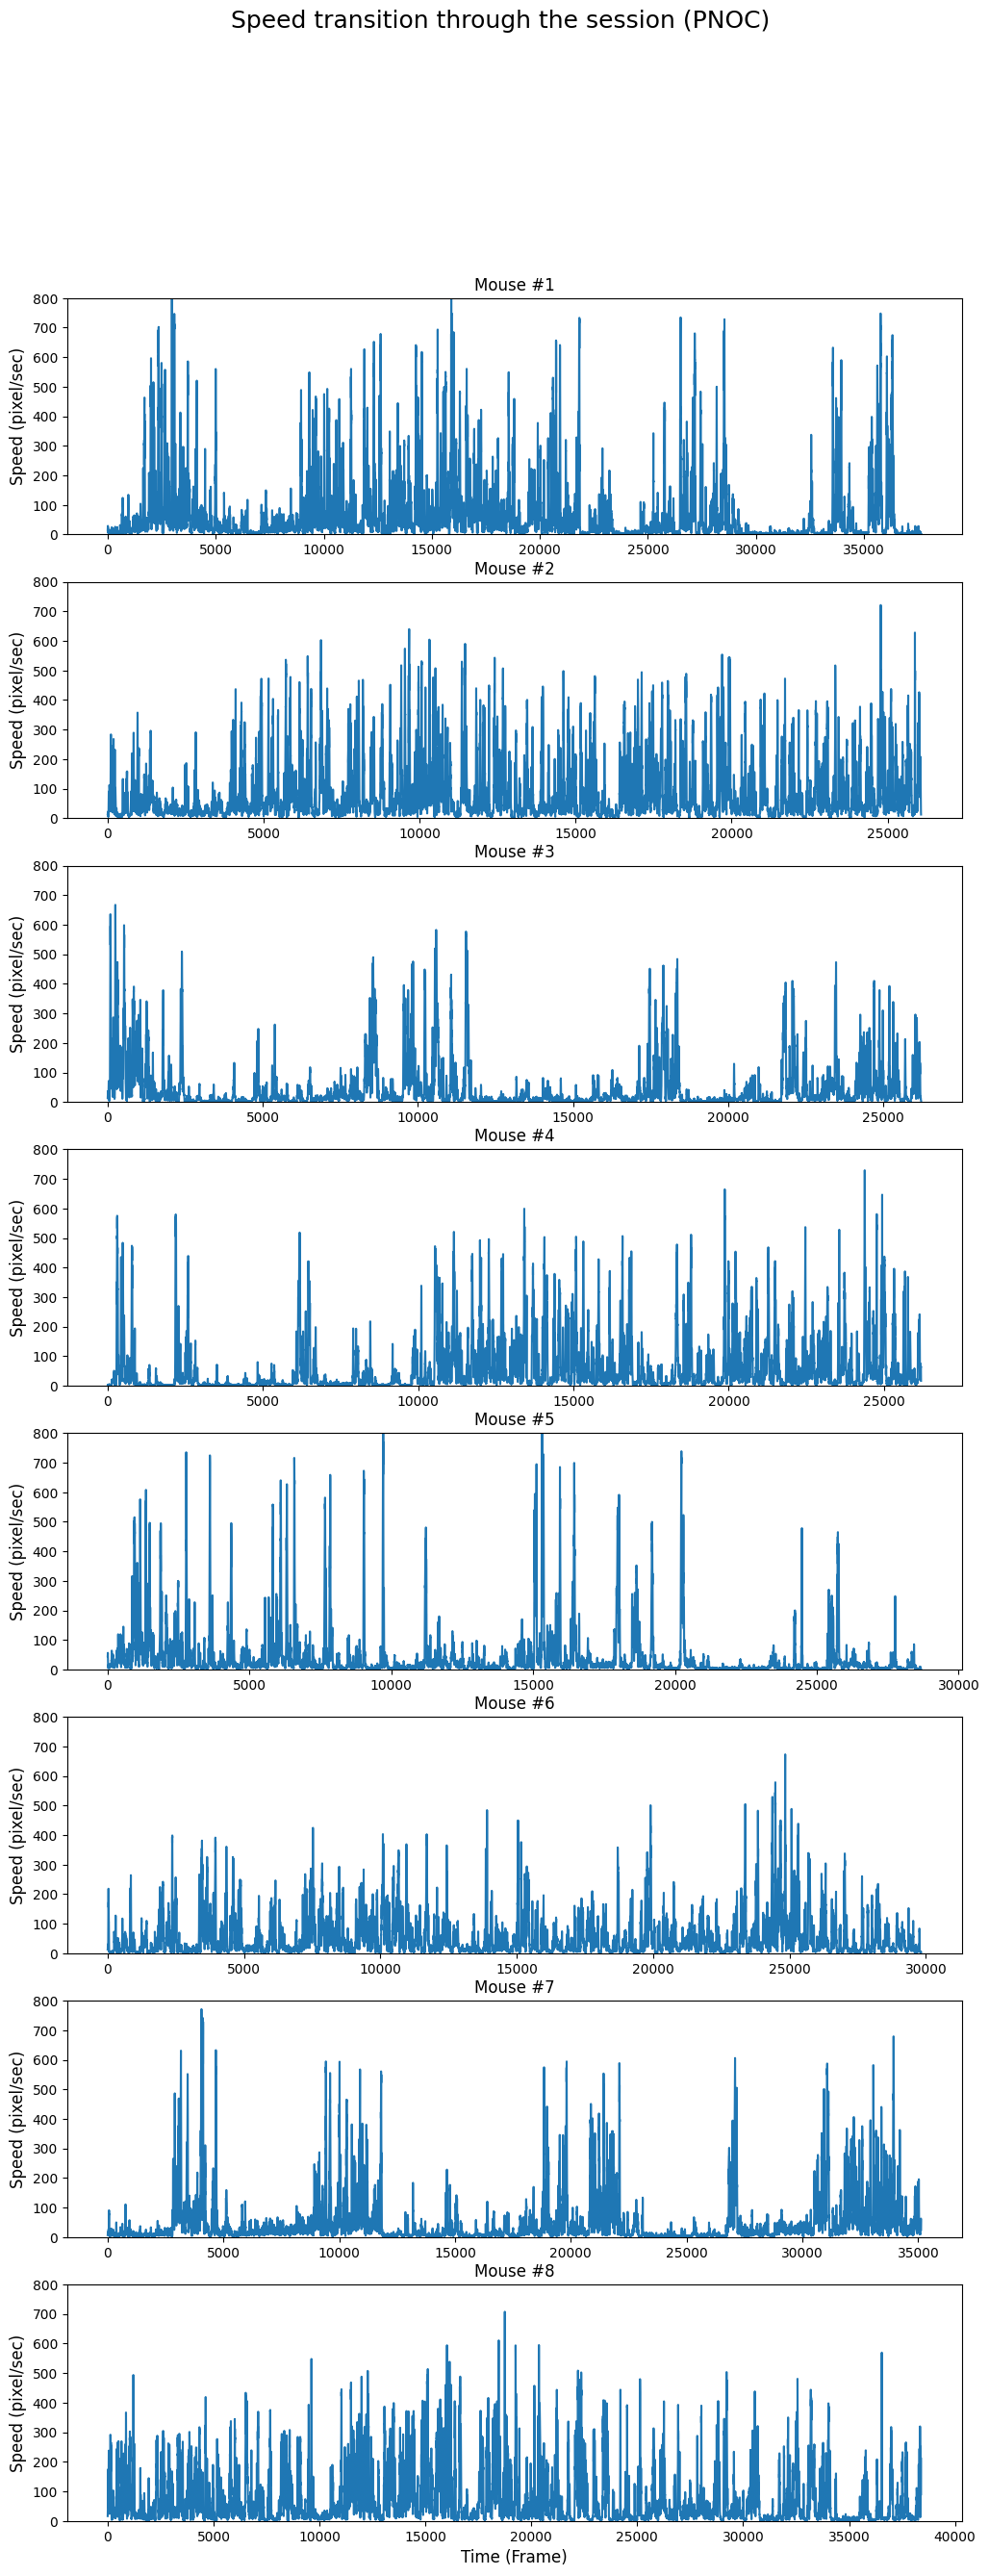

In [5]:
######################### Extract the speed (Center of the Body) #######################
PNOC_speed = [[] for i in range(8)]
NTS_speed = [[] for i in range(11)]
window = np.ones(11)/11

for i in range(8):
    x_PNOC = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.6"][2:].astype("float").to_numpy()
    y_PNOC = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.7"][2:].astype("float").to_numpy()
    PNOC_speed[i] = [np.sqrt((x_PNOC[j]-x_PNOC[j-1])**2 + (y_PNOC[j]-y_PNOC[j-1])**2)*30 for j in range(1,len(x_PNOC))]
    PNOC_speed[i] = np.convolve(PNOC_speed[i], window, mode="same")

for i in range(11):
    x_NTS = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.6"][2:].astype("float").to_numpy()
    y_NTS = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.7"][2:].astype("float").to_numpy()
    NTS_speed[i] = [np.sqrt((x_NTS[j]-x_NTS[j-1])**2 + (y_NTS[j]-y_NTS[j-1])**2)*30 for j in range(1,len(x_NTS))]
    NTS_speed[i] = np.convolve(NTS_speed[i], window, mode="same")


plt.figure(figsize=(12,30))
plt.suptitle("Speed transition through the session (PNOC)", fontsize=18)
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.title(f"Mouse #{i+1}")
    plt.plot(PNOC_speed[i])
    plt.ylabel("Speed (pixel/sec)", fontsize=12)
    plt.ylim((0,800))
plt.xlabel("Time (Frame)", fontsize=12)
plt.show()

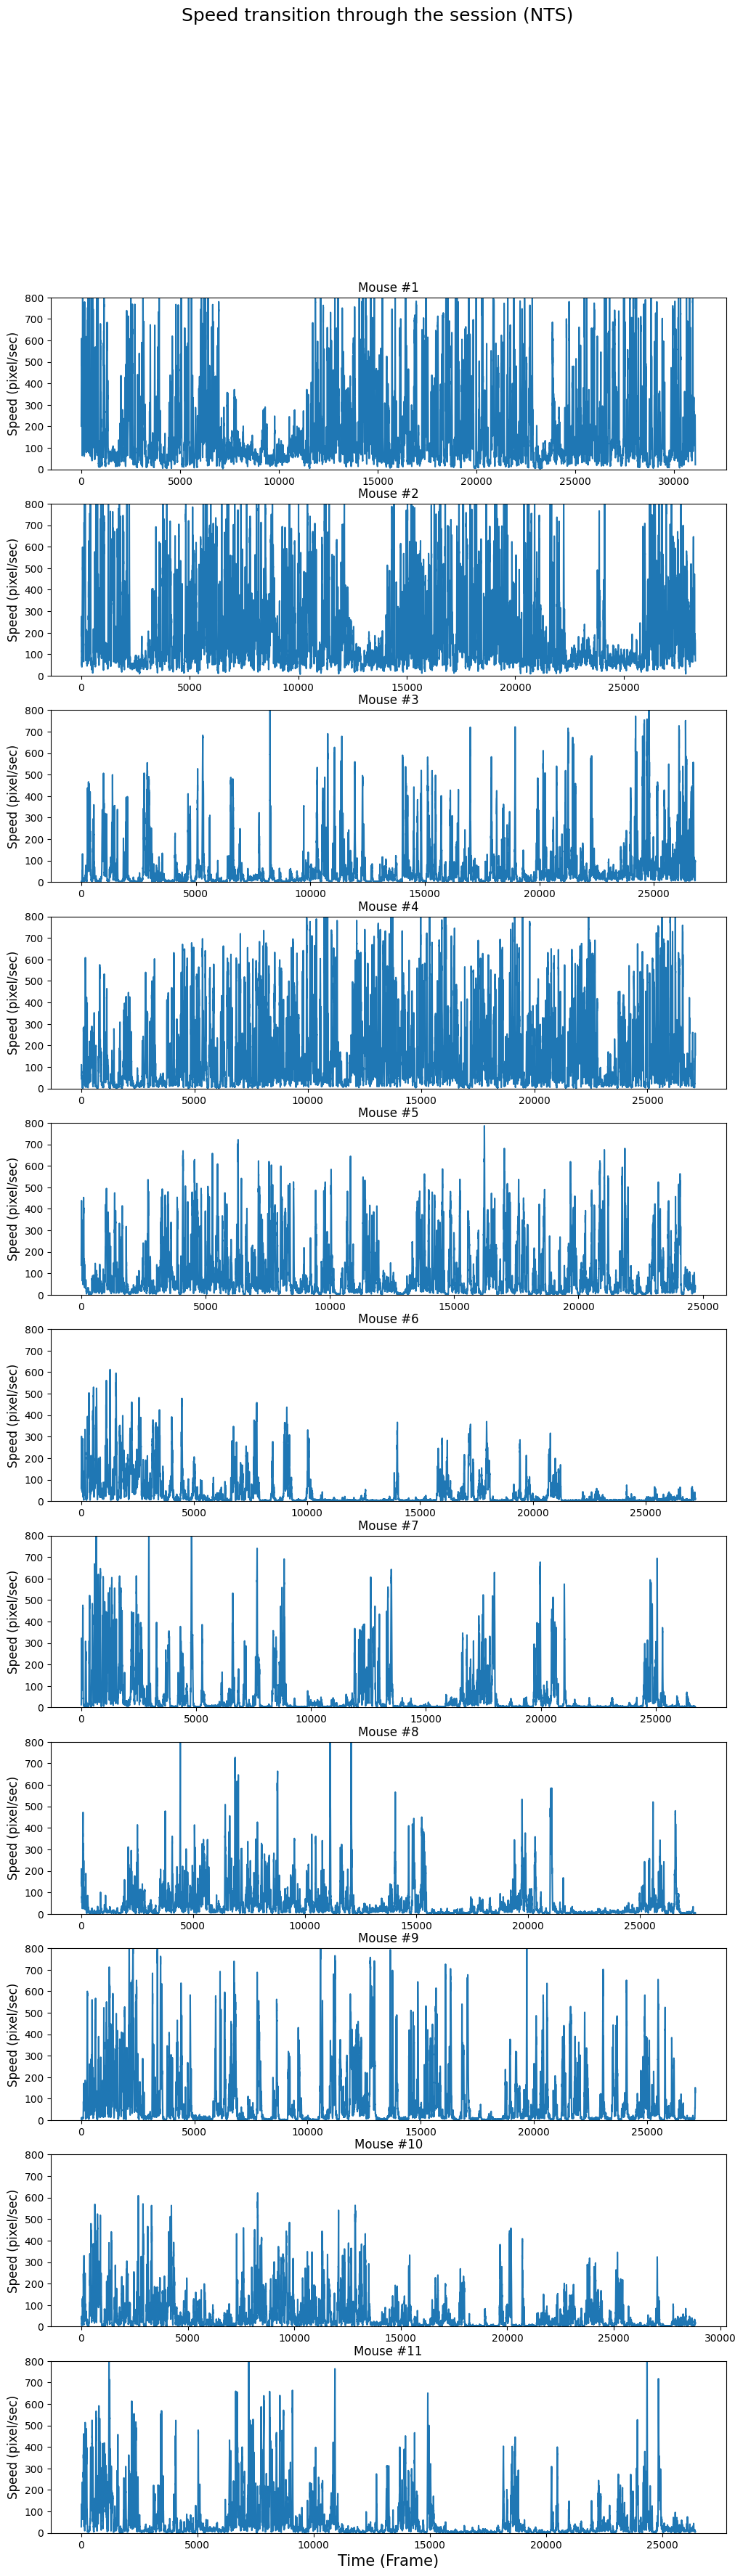

In [6]:
plt.figure(figsize=(12,40))
plt.suptitle("Speed transition through the session (NTS)", fontsize=18)
for i in range(11):
    plt.subplot(11,1,i+1)
    plt.title(f"Mouse #{i+1}")
    plt.plot(NTS_speed[i])
    plt.ylabel("Speed (pixel/sec)", fontsize=12)
    plt.ylim((0,800))
plt.xlabel("Time (Frame)", fontsize=15)
plt.show()    

In [7]:
####################################### Extract the Head Direction Change ##################################
# head_twist: angle between (BodyCenter-Neck)     and  (Neck-Snout)
# body_twist: angle between (TailBase-BodyCenter) and  (BodyCenter-Neck)

# v1: TailBase   →  BodyCenter
# v2: BodyCenter →  Neck         
# v3: Neck       →  Snout        

PNOC_head_twist = [[] for i in range(8)]
NTS_head_twist = [[] for i in range(11)]
PNOC_body_twist = [[] for i in range(8)]
NTS_body_twist = [[] for i in range(11)]
window = np.ones(5)/5

for i in range(8):
    x_tail = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.3"][2:].astype("float").to_numpy()
    y_tail = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.4"][2:].astype("float").to_numpy()
    x_cbody = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.6"][2:].astype("float").to_numpy()
    y_cbody = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.7"][2:].astype("float").to_numpy()
    x_neck = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.9"][2:].astype("float").to_numpy()
    y_neck = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.10"][2:].astype("float").to_numpy()
    x_snout = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.12"][2:].astype("float").to_numpy()
    y_snout = PNOC_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.13"][2:].astype("float").to_numpy()

    v1 = [[x_cbody[j]-x_tail[j], y_cbody[j]-y_tail[j]] for j in range(len(x_tail))]
    v2 = [[x_neck[j]-x_cbody[j], y_neck[j]-y_cbody[j]] for j in range(len(x_tail))]
    v3 = [[x_snout[j]-x_neck[j], y_snout[j]-y_neck[j]] for j in range(len(x_tail))]
    
    PNOC_head_twist[i] = [(angle_between(v2[j],v3[j]) - angle_between(v2[j-1],v3[j-1]))*30 for j in range(1,len(x_tail))]
    PNOC_head_twist[i] = np.convolve(PNOC_head_twist[i], window, mode="same")
    PNOC_body_twist[i] = [(angle_between(v1[j],v2[j]) - angle_between(v1[j-1],v2[j-1]))*30 for j in range(1,len(x_tail))]
    PNOC_body_twist[i] = np.convolve(PNOC_body_twist[i], window, mode="same")

for i in range(11):
    x_tail = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.3"][2:].astype("float").to_numpy()
    y_tail = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.4"][2:].astype("float").to_numpy()
    x_cbody = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.6"][2:].astype("float").to_numpy()
    y_cbody = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.7"][2:].astype("float").to_numpy()
    x_neck = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.9"][2:].astype("float").to_numpy()
    y_neck = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.10"][2:].astype("float").to_numpy()
    x_snout = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.12"][2:].astype("float").to_numpy()
    y_snout = NTS_DLC[i]["DLC_resnet50_small_open_field_Nov23Nov21shuffle1_910000.13"][2:].astype("float").to_numpy()

    v1 = [[x_cbody[j]-x_tail[j], y_cbody[j]-y_tail[j]] for j in range(len(x_tail))]
    v2 = [[x_neck[j]-x_cbody[j], y_neck[j]-y_cbody[j]] for j in range(len(x_tail))]
    v3 = [[x_snout[j]-x_neck[j], y_snout[j]-y_neck[j]] for j in range(len(x_tail))]
    
    NTS_head_twist[i] = [(angle_between(v2[j],v3[j]) - angle_between(v2[j-1],v3[j-1]))*30 for j in range(1,len(x_tail))]
    NTS_head_twist[i] = np.convolve(NTS_head_twist[i], window, mode="same")
    NTS_body_twist[i] = [(angle_between(v1[j],v2[j]) - angle_between(v1[j-1],v2[j-1]))*30 for j in range(1,len(x_tail))]
    NTS_body_twist[i] = np.convolve(NTS_body_twist[i], window, mode="same")

Text(0.5, 0, 'Time (Frame)')

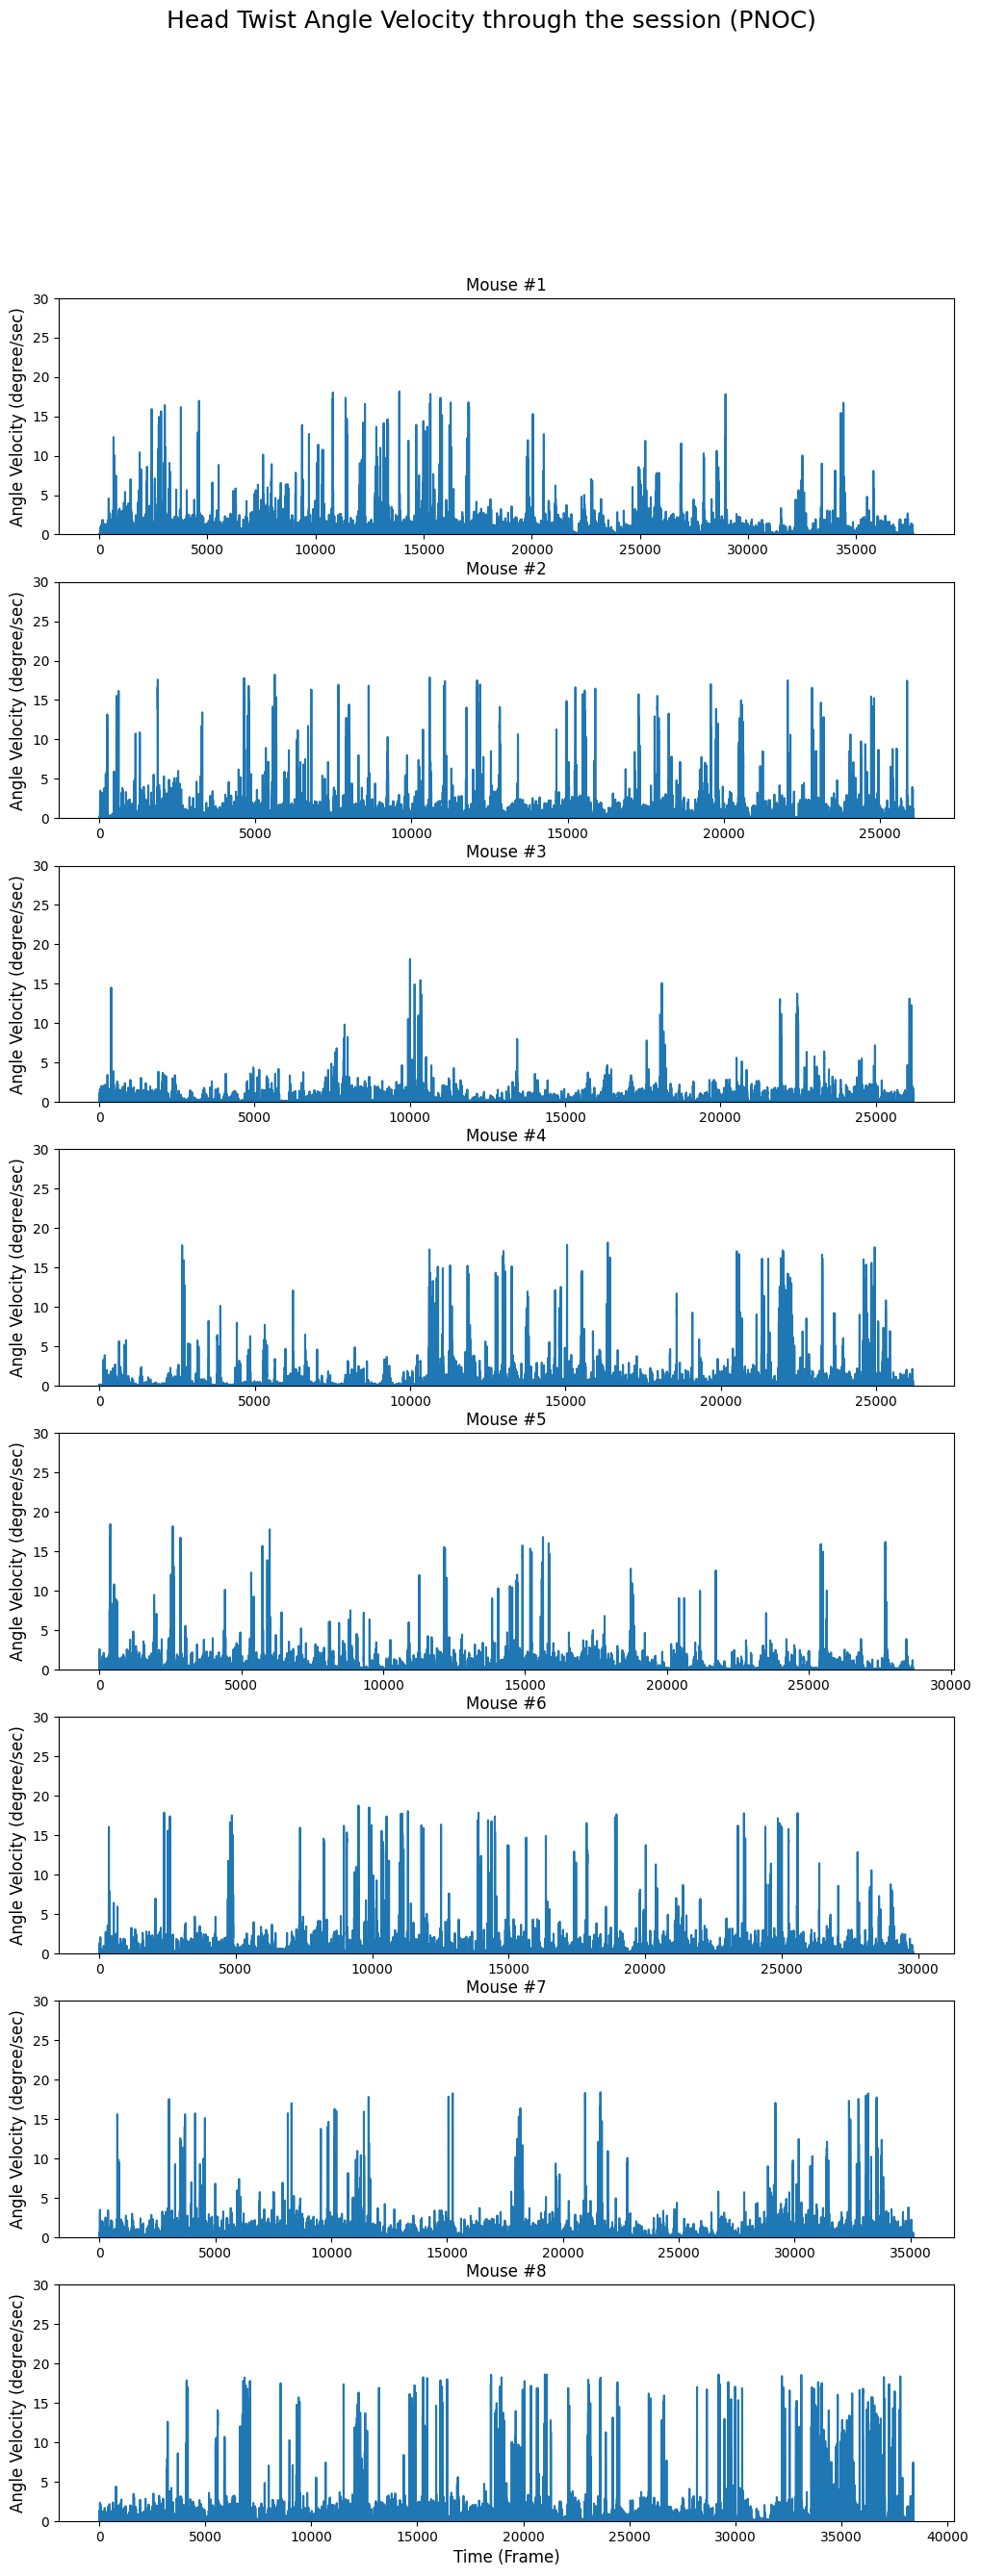

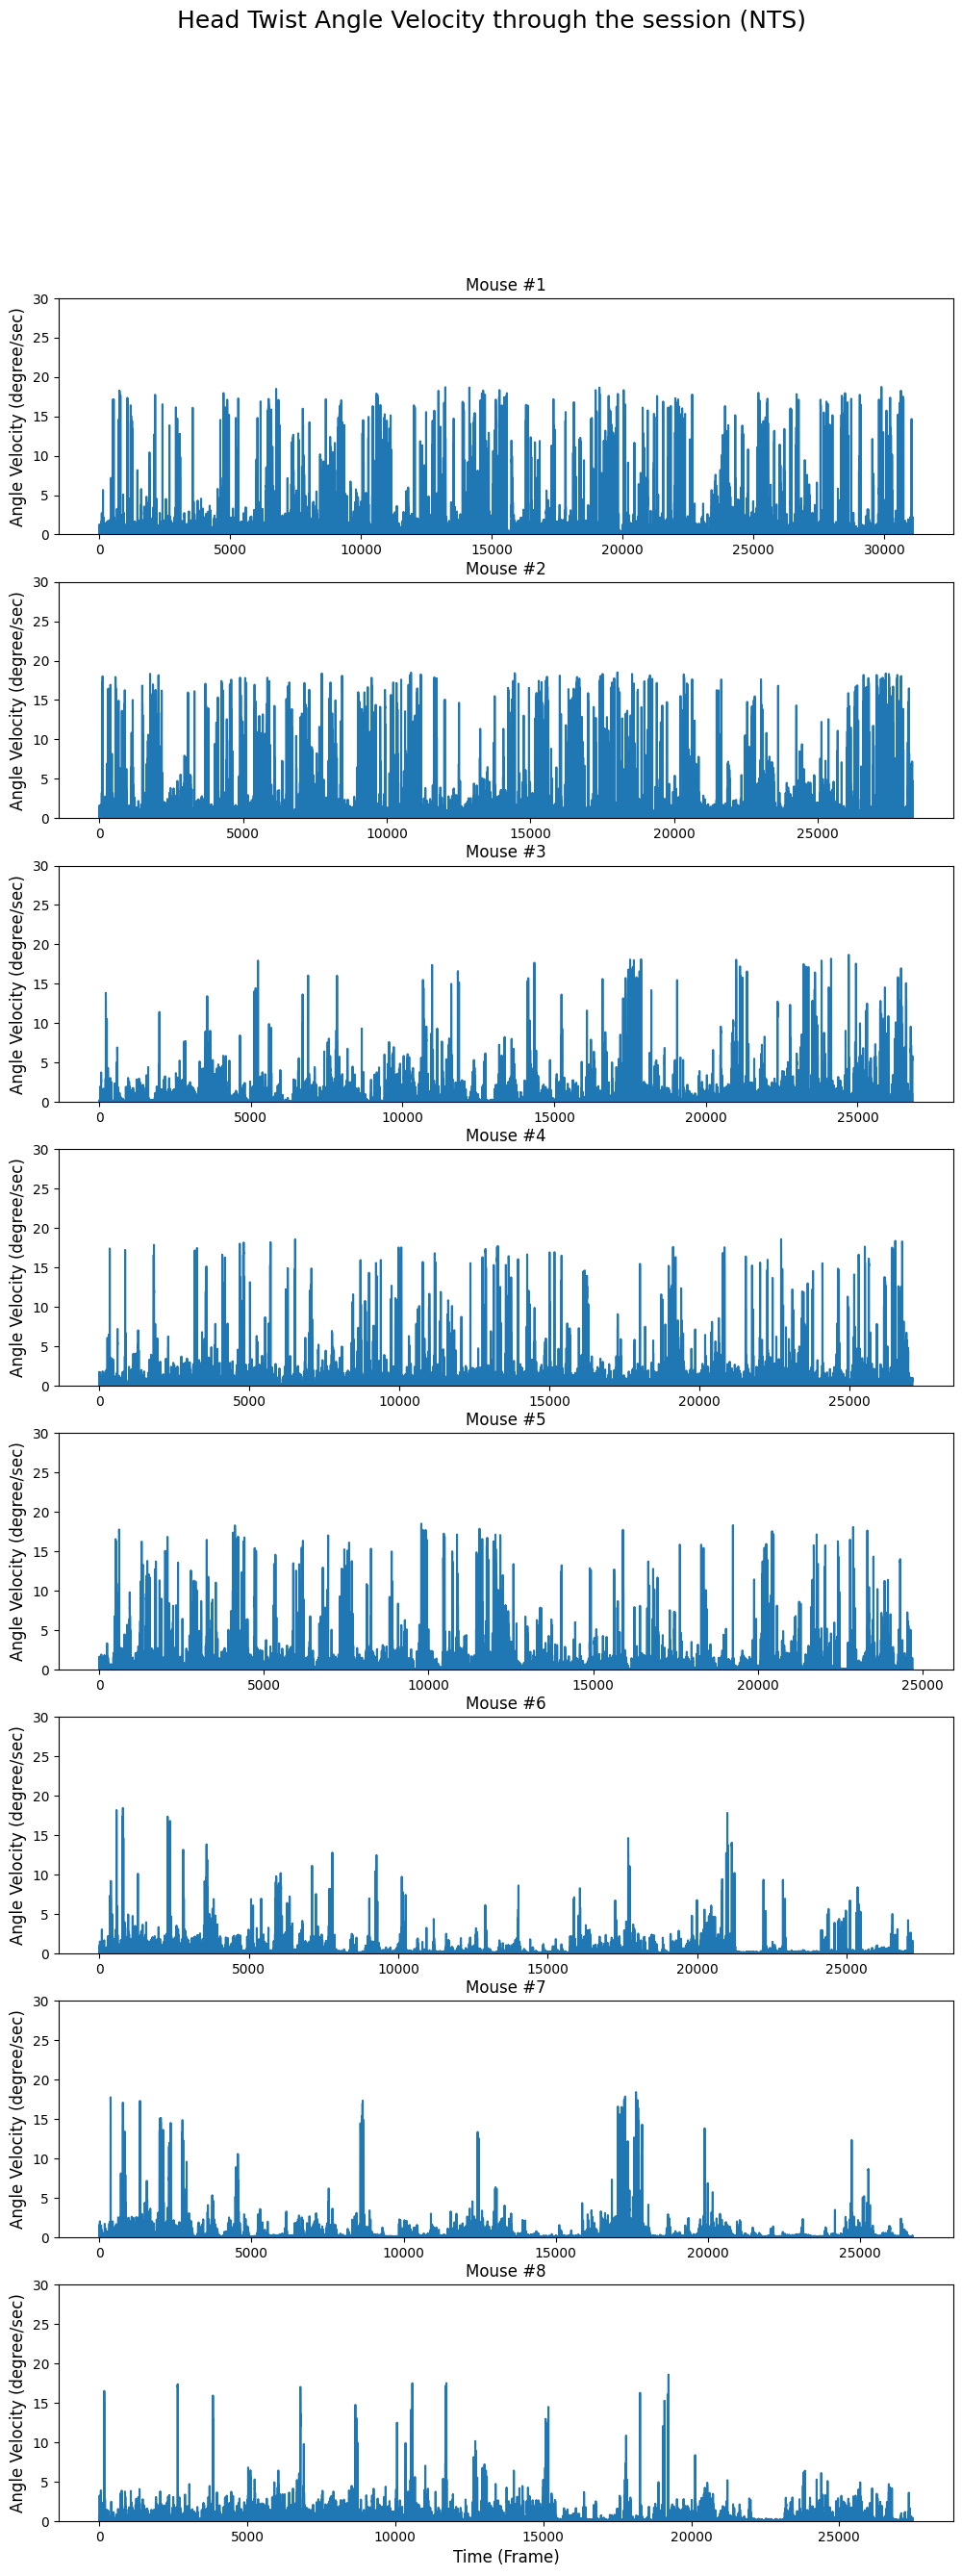

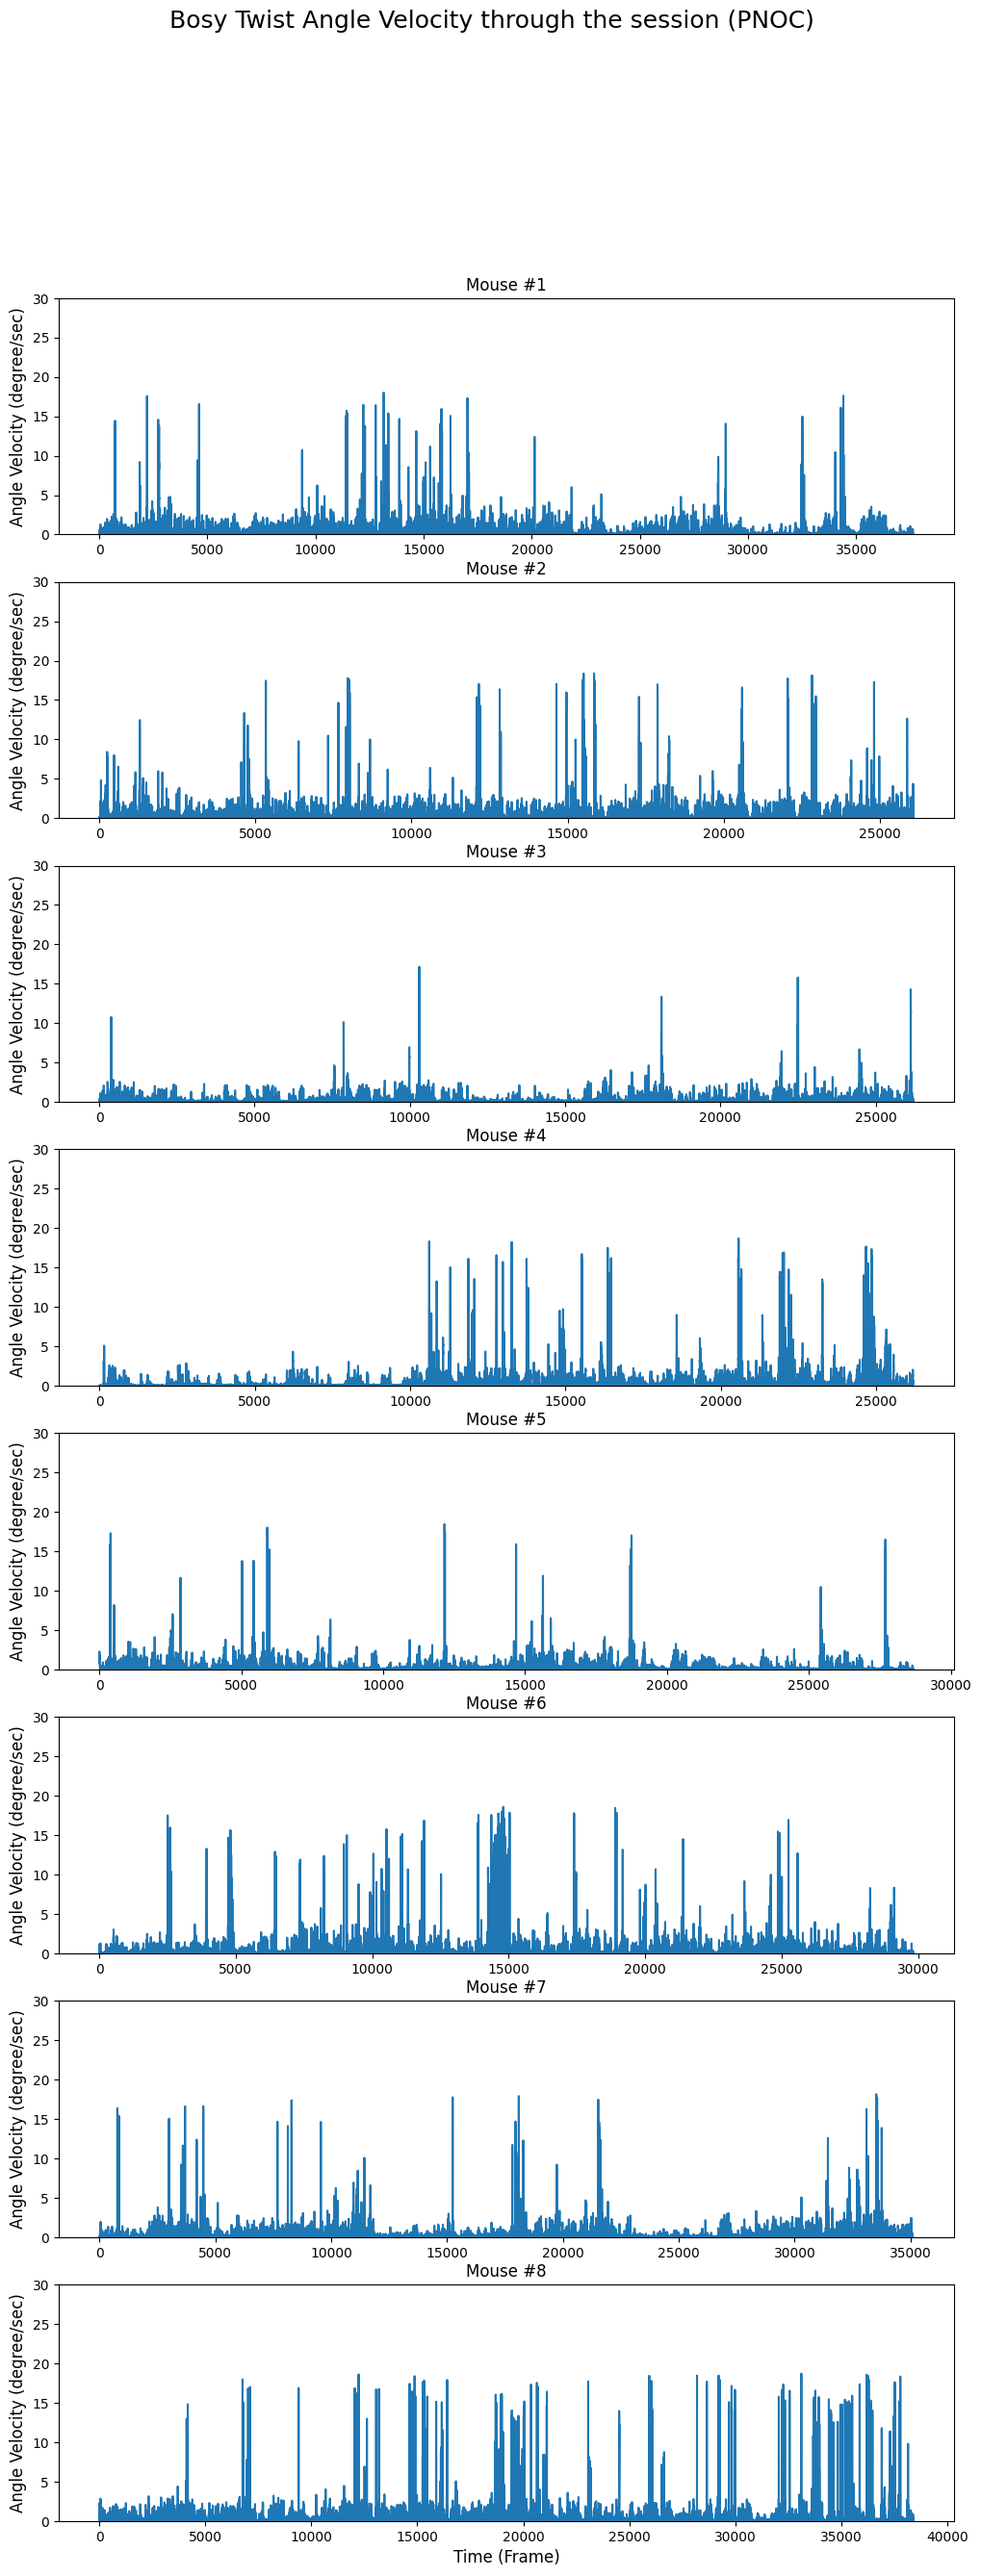

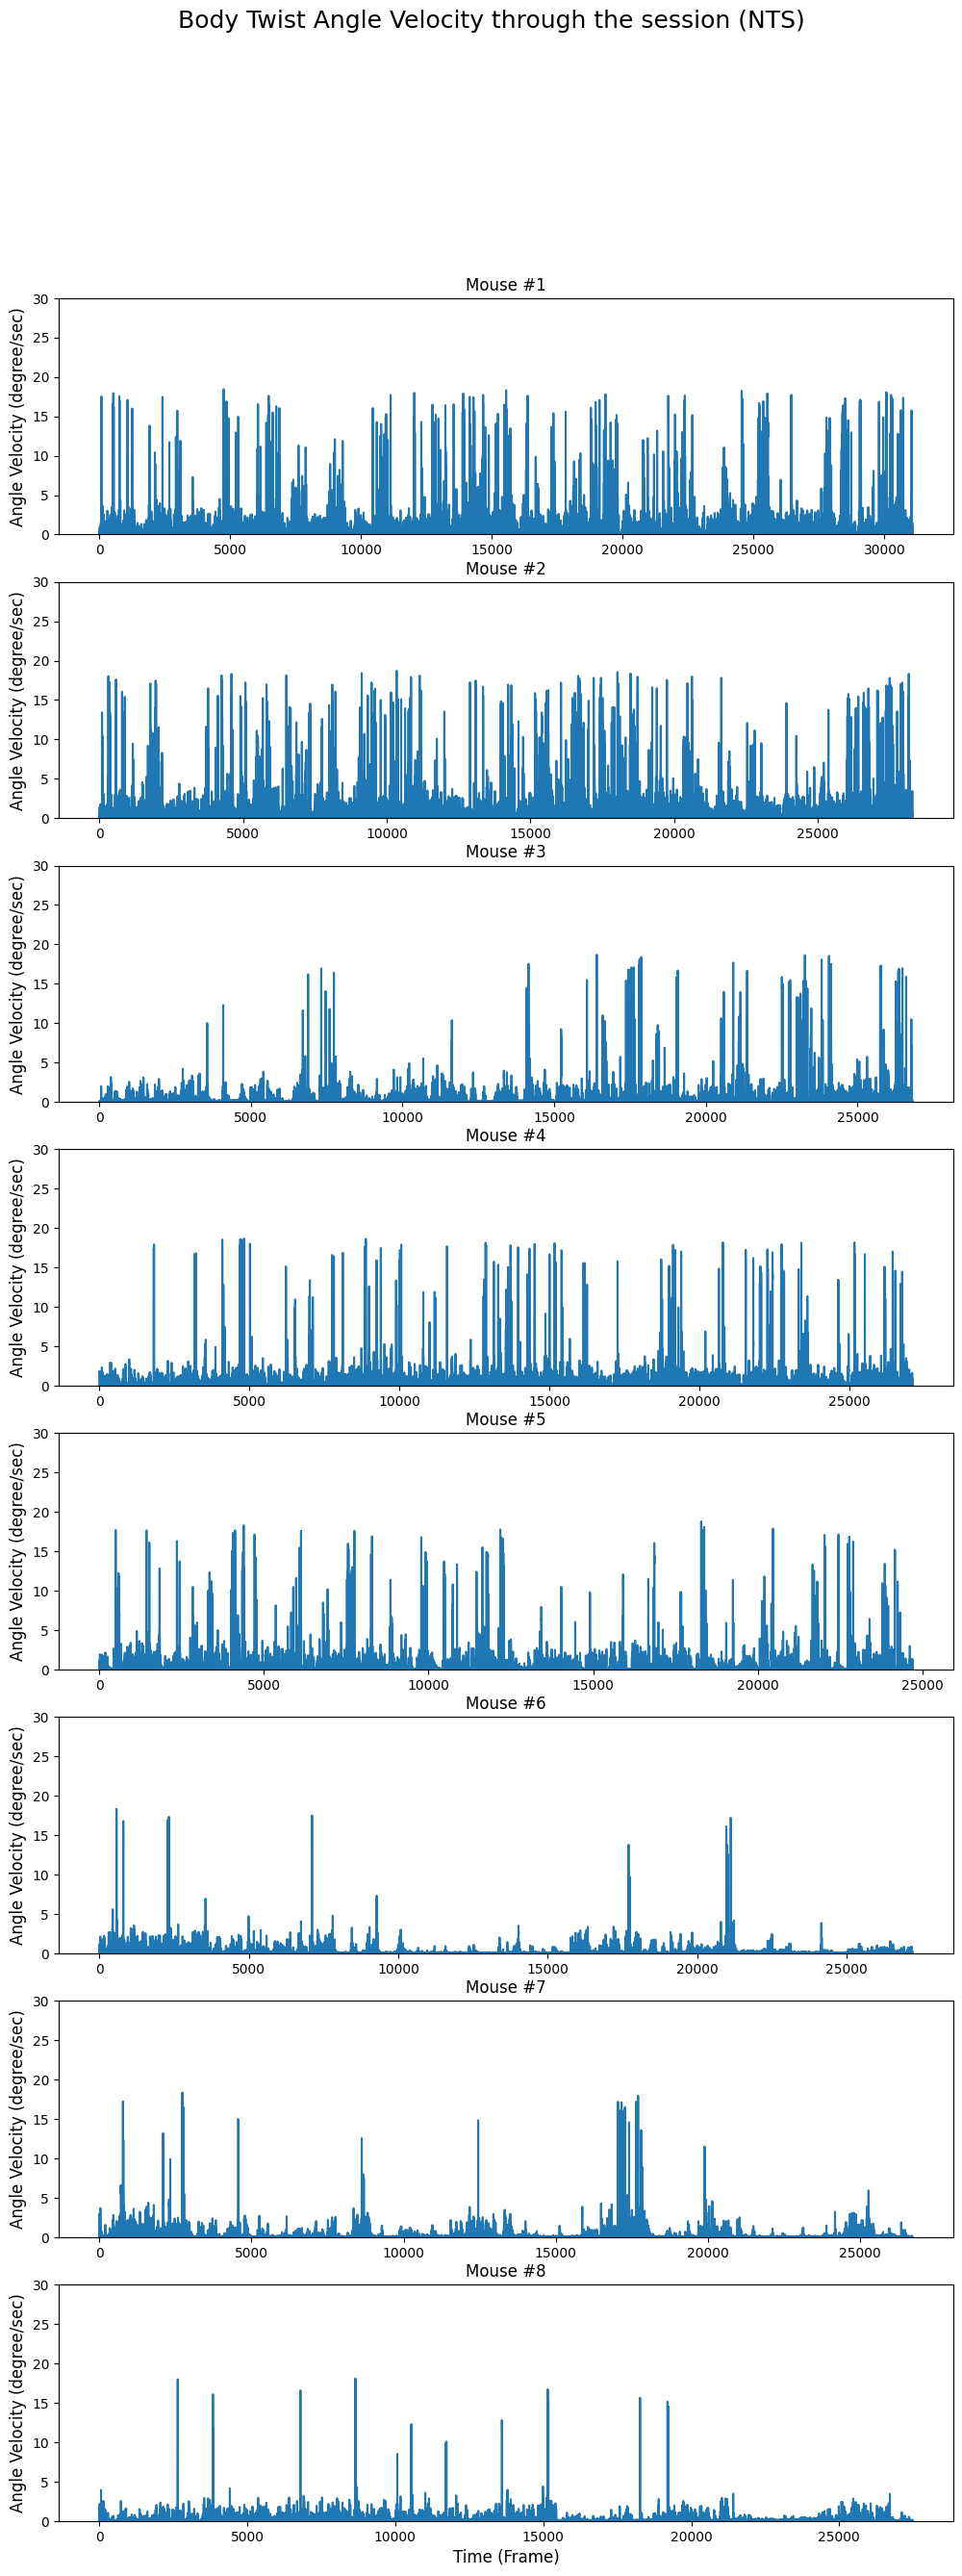

In [8]:
plt.figure(figsize=(12,30))
plt.suptitle("Head Twist Angle Velocity through the session (PNOC)", fontsize=18)
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.title(f"Mouse #{i+1}")
    plt.plot(PNOC_head_twist[i])
    plt.ylabel("Angle Velocity (degree/sec)", fontsize=12)
    plt.ylim((0,30))
plt.xlabel("Time (Frame)", fontsize=12)

plt.figure(figsize=(12,30))
plt.suptitle("Head Twist Angle Velocity through the session (NTS)", fontsize=18)
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.title(f"Mouse #{i+1}")
    plt.plot(NTS_head_twist[i])
    plt.ylabel("Angle Velocity (degree/sec)", fontsize=12)
    plt.ylim((0,30))
plt.xlabel("Time (Frame)", fontsize=12)


plt.figure(figsize=(12,30))
plt.suptitle("Bosy Twist Angle Velocity through the session (PNOC)", fontsize=18)
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.title(f"Mouse #{i+1}")
    plt.plot(PNOC_body_twist[i])
    plt.ylabel("Angle Velocity (degree/sec)", fontsize=12)
    plt.ylim((0,30))
plt.xlabel("Time (Frame)", fontsize=12)

plt.figure(figsize=(12,30))
plt.suptitle("Body Twist Angle Velocity through the session (NTS)", fontsize=18)
for i in range(8):
    plt.subplot(8,1,i+1)
    plt.title(f"Mouse #{i+1}")
    plt.plot(NTS_body_twist[i])
    plt.ylabel("Angle Velocity (degree/sec)", fontsize=12)
    plt.ylim((0,30))
plt.xlabel("Time (Frame)", fontsize=12)

In [9]:
############################# Load A-SOiD annotated behavior data, stimulation data from .npy data ############################
start_time = 300
PNOC_behavs = [np.load(f"PNOC_mouse{i+1}_behav.npy").astype(int)[start_time:] for i in range(8)]
PNOC_stims = [np.load(f"PNOC_mouse{i+1}_stim.npy")[start_time:]for i in range(8)]

NTS_behavs = [np.load(f"NTS_mouse{i+1}_behav.npy").astype(int)[start_time:] for i in range(11)]
NTS_stims = [np.load(f"NTS_mouse{i+1}_stim.npy")[start_time:] for i in range(11)]

In [10]:
############################ Merge body grooming and face grooming into grooming ###########################
for i in range(8):
    PNOC_behavs[i][PNOC_behavs[i]==5] = 4
for i in range(11):
    NTS_behavs[i][NTS_behavs[i]==5] = 4

In [11]:
############################# Load B-SOiD clustered behavior data ############################
PNOC_bsoidbout_files = glob.glob("/Volumes/KIOXIA/PNOC_opto/BSOID/*bout_length*.csv")
PNOC_bsoidbout_files.sort()
NTS_bsoidbout_files = glob.glob("/Volumes/KIOXIA/NTS_opto/BSOID/*bout_length*.csv")
NTS_bsoidbout_files.sort()

PNOC_bsoidlabel_files = glob.glob("/Volumes/KIOXIA/PNOC_opto/BSOID/*labels_pose*.csv")
PNOC_bsoidlabel_files.sort()
NTS_bsoidlabel_files = glob.glob("/Volumes/KIOXIA/NTS_opto/BSOID/*labels_pose*.csv")
NTS_bsoidlabel_files.sort()

PNOC_bsoidtrans_files = glob.glob("/Volumes/KIOXIA/PNOC_opto/BSOID/*transitions_mat*.csv")
PNOC_bsoidtrans_files.sort()
NTS_bsoidtrans_files = glob.glob("/Volumes/KIOXIA/NTS_opto/BSOID/*transitions_mat*.csv")
NTS_bsoidtrans_files.sort()

PNOC_bsoidlabels = [pd.read_csv(PNOC_bsoidlabel_files[i])["B-SOiD labels"].to_numpy().astype(int)[start_time+2:] for i in range(8)]
NTS_bsoidlabels = [pd.read_csv(NTS_bsoidlabel_files[i])["B-SOiD labels"].to_numpy().astype(int)[start_time+2:] for i in range(11)]

PNOC_speed = [PNOC_speed[i][start_time-1:] for i in range(8)]
NTS_speed = [NTS_speed[i][start_time-1:] for i in range(11)]
PNOC_head_twist = [PNOC_head_twist[i][start_time-1:] for i in range(8)]
NTS_head_twist = [NTS_head_twist[i][start_time-1:] for i in range(11)]
PNOC_body_twist = [PNOC_body_twist[i][start_time-1:] for i in range(8)]
NTS_body_twist = [NTS_body_twist[i][start_time-1:] for i in range(11)]

/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/2136953637.py:17: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  PNOC_bsoidlabels = [pd.read_csv(PNOC_bsoidlabel_files[i])["B-SOiD labels"].to_numpy().astype(int)[start_time+2:] for i in range(8)]
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/2136953637.py:17: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  PNOC_bsoidlabels = [pd.read_csv(PNOC_bsoidlabel_files[i])["B-SOiD labels"].to_numpy().astype(int)[start_time+2:] for i in range(8)]
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/2136953637.py:17: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  PNOC_bsoidlabels = [pd.read_csv(PNOC_bso

In [12]:
print("PNOC (ASOID BSOID STIM SPEED HEADTWIST BODYTWIST)")
for i in range(8):
    #PNOC_DLC[i]
    print(f"Mouse #{i+1}", len(PNOC_behavs[i]), len(PNOC_bsoidlabels[i]), len(PNOC_stims[i]), len(PNOC_speed[i]), len(PNOC_head_twist[i]), len(PNOC_body_twist[i]))
print("NTS")
for i in range(11):
    #NTS_DLC[i]
    print(f"Mouse #{i+1}", len(NTS_behavs[i]), len(NTS_bsoidlabels[i]), len(NTS_stims[i]), len(NTS_speed[i]), len(NTS_head_twist[i]), len(NTS_body_twist[i]))

PNOC (ASOID BSOID STIM SPEED HEADTWIST BODYTWIST)
Mouse #1 37340 37340 37340 37340 37340 37340
Mouse #2 25777 25777 25777 25777 25777 25777
Mouse #3 25915 25915 25915 25915 25915 25915
Mouse #4 25895 25895 25895 25895 25895 25895
Mouse #5 28378 28378 28378 28378 28378 28378
Mouse #6 29522 29522 29522 29522 29522 29522
Mouse #7 34825 34825 34825 34825 34825 34825
Mouse #8 38102 38102 38102 38102 38102 38102
NTS
Mouse #1 30779 30779 30779 30779 30779 30779
Mouse #2 28003 28003 28003 28003 28003 28003
Mouse #3 26517 26517 26517 26517 26517 26517
Mouse #4 26817 26817 26817 26817 26817 26817
Mouse #5 24405 24405 24405 24405 24405 24405
Mouse #6 26899 26899 26899 26899 26899 26899
Mouse #7 26428 26428 26428 26428 26428 26428
Mouse #8 27181 27181 27181 27181 27181 27181
Mouse #9 26838 26838 26838 26838 26838 26838
Mouse #10 28532 28532 28532 28532 28532 28532
Mouse #11 26134 26134 26134 26134 26134 26134


# EDA

### Example plot of two data (behav and stim)
* Behav: Label data
* Stim: Boolean data

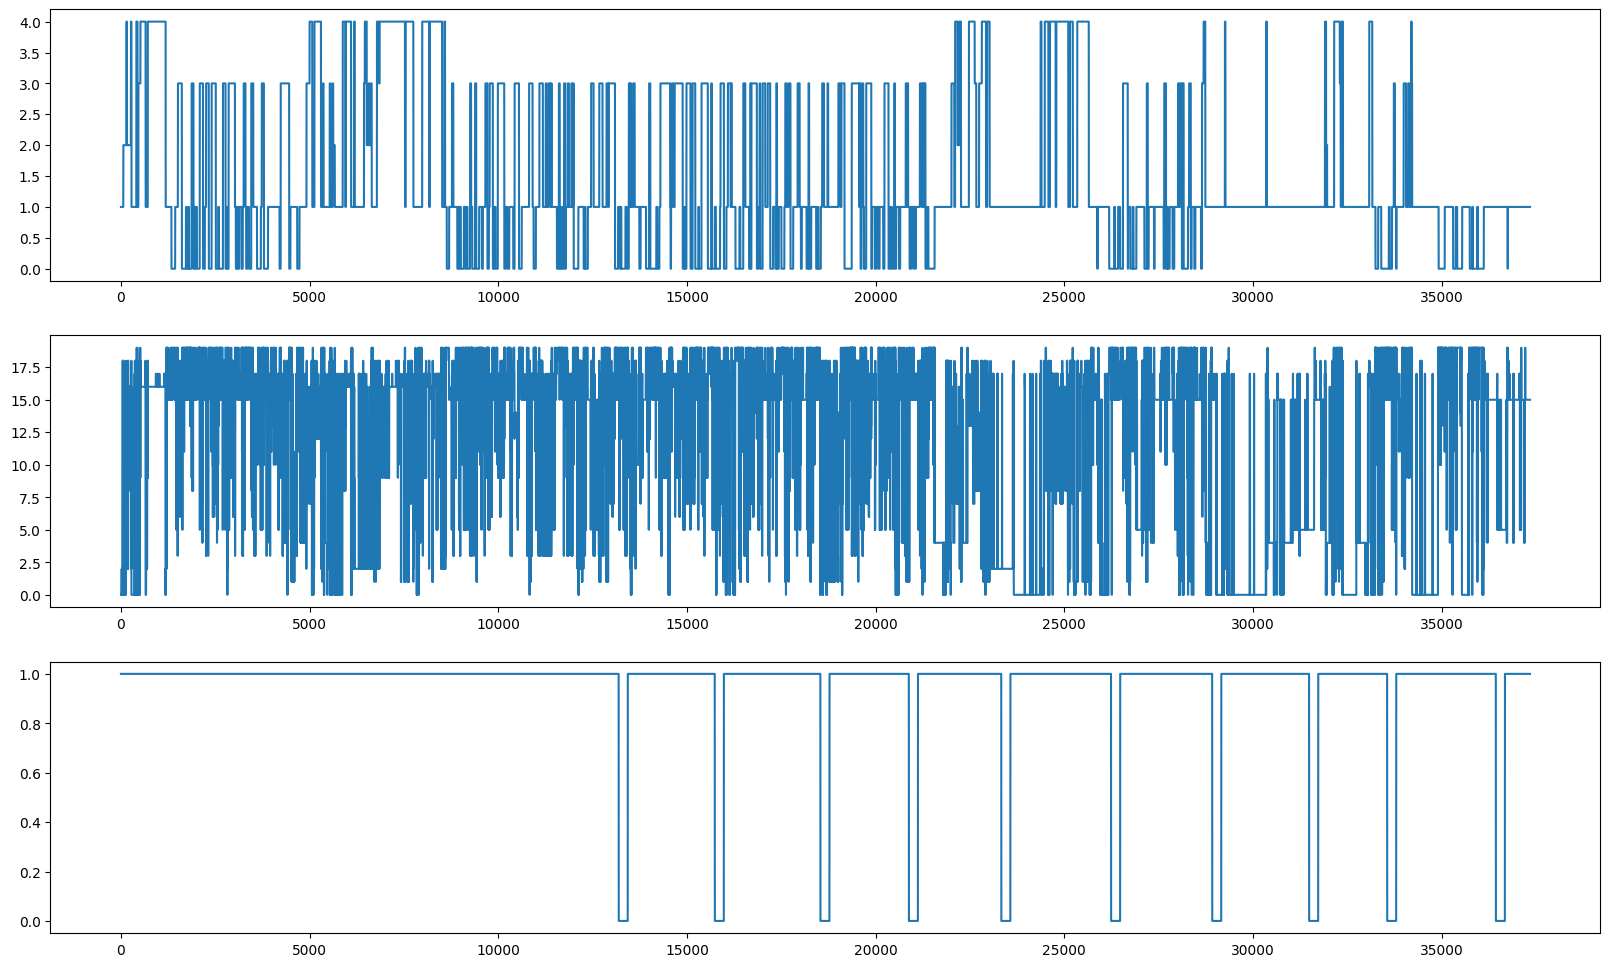

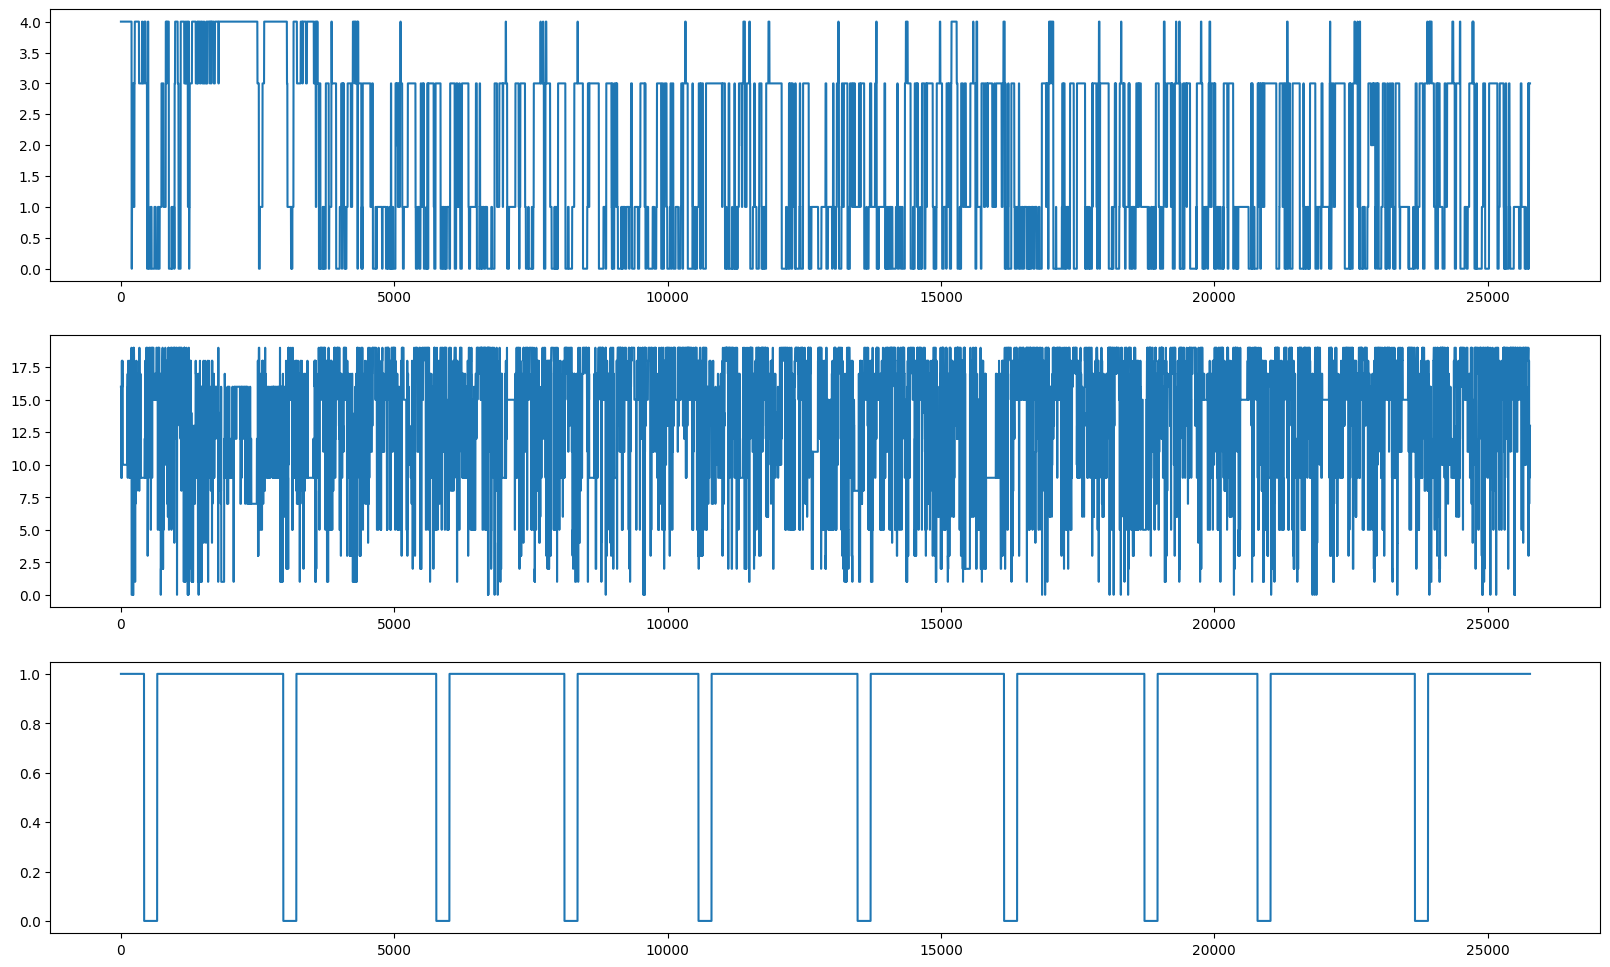

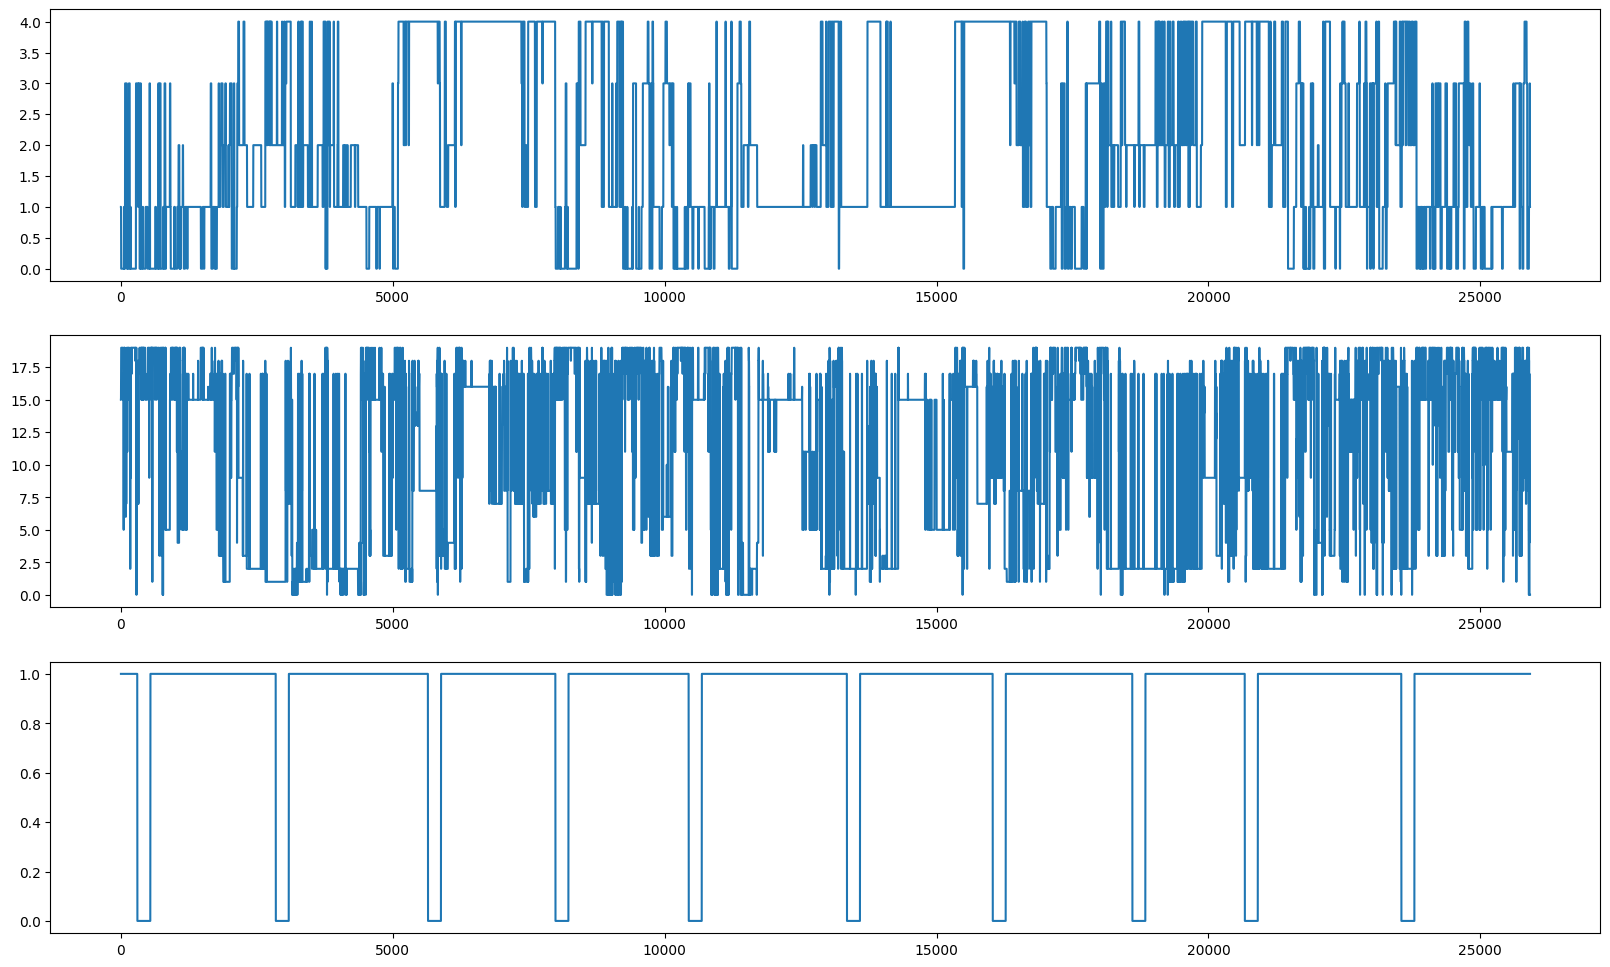

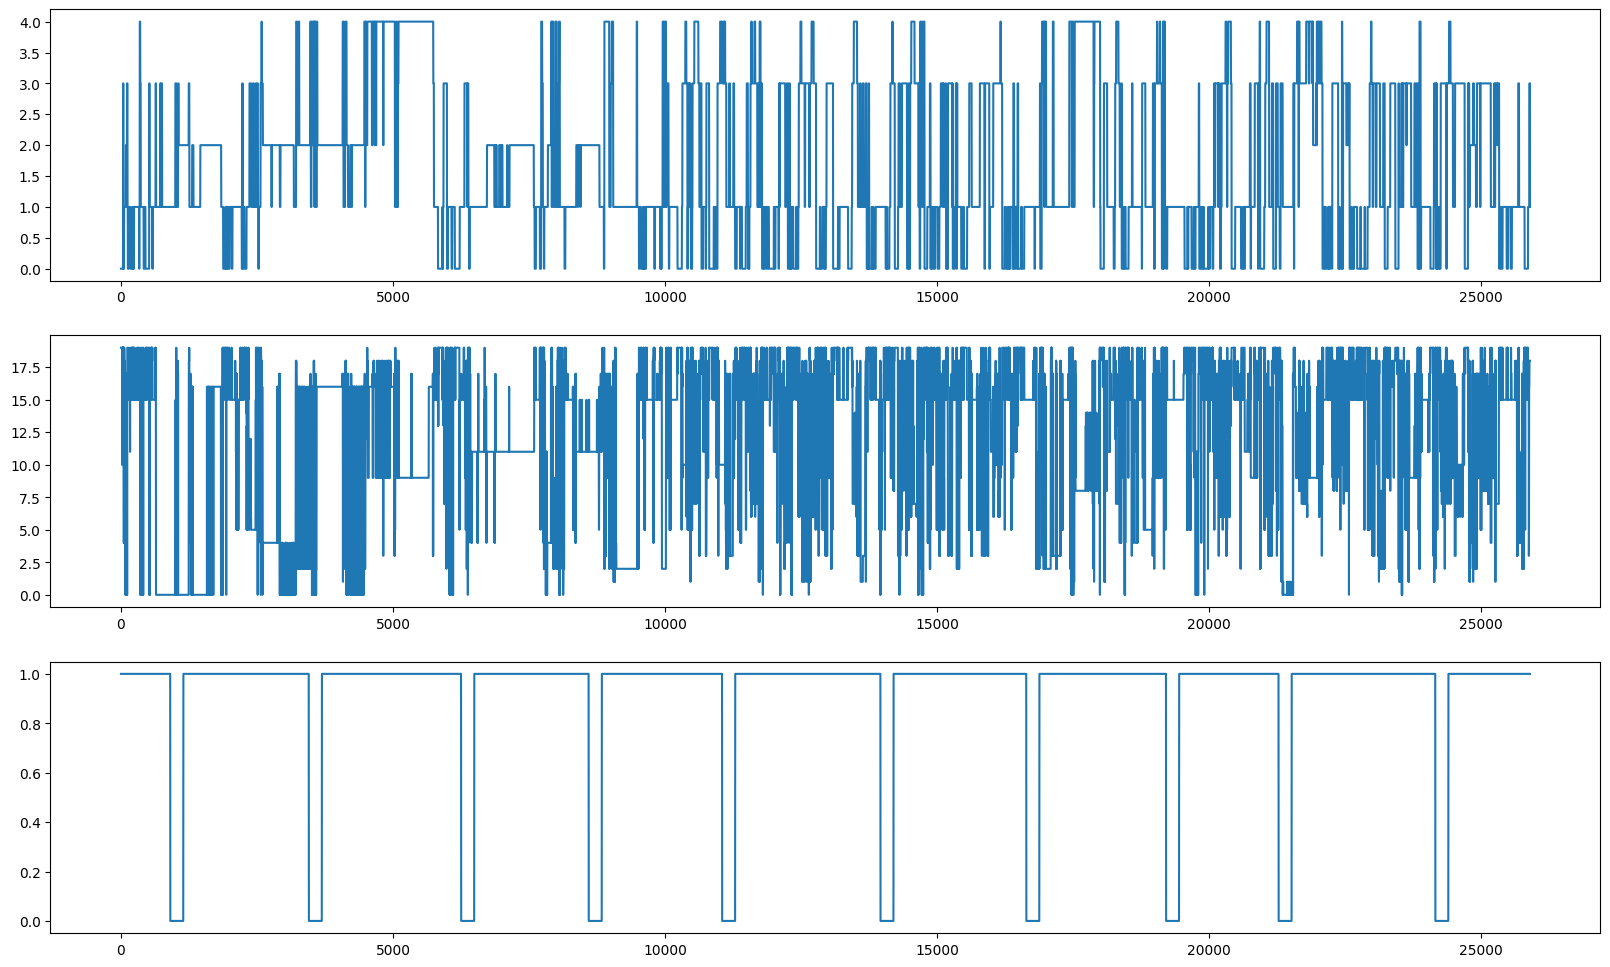

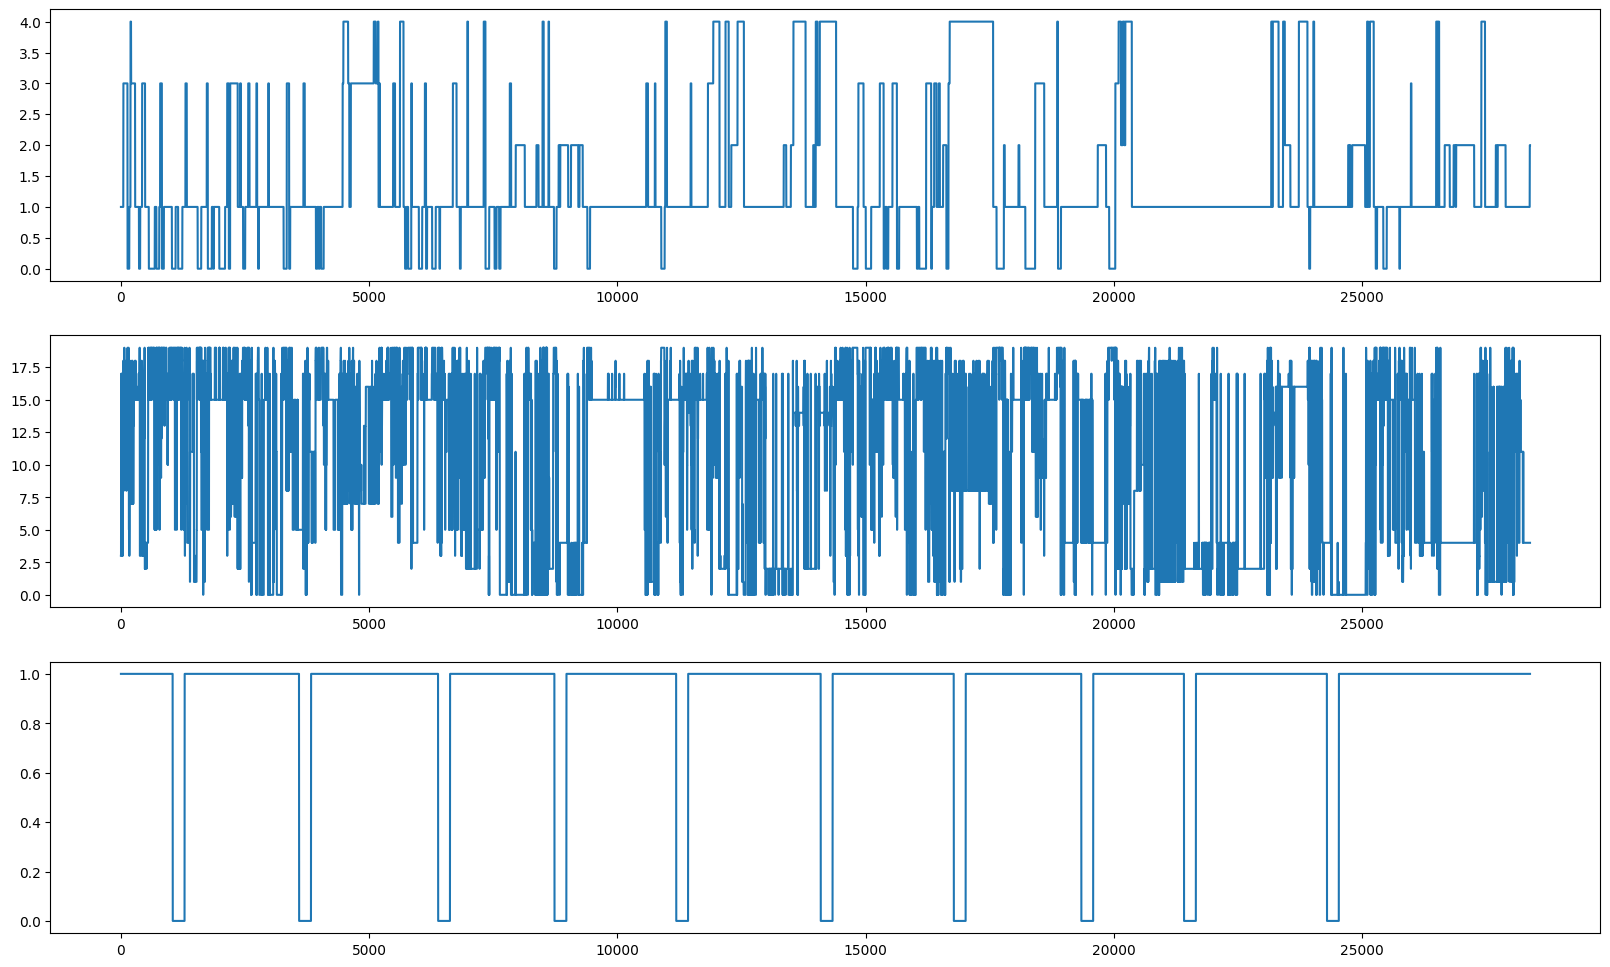

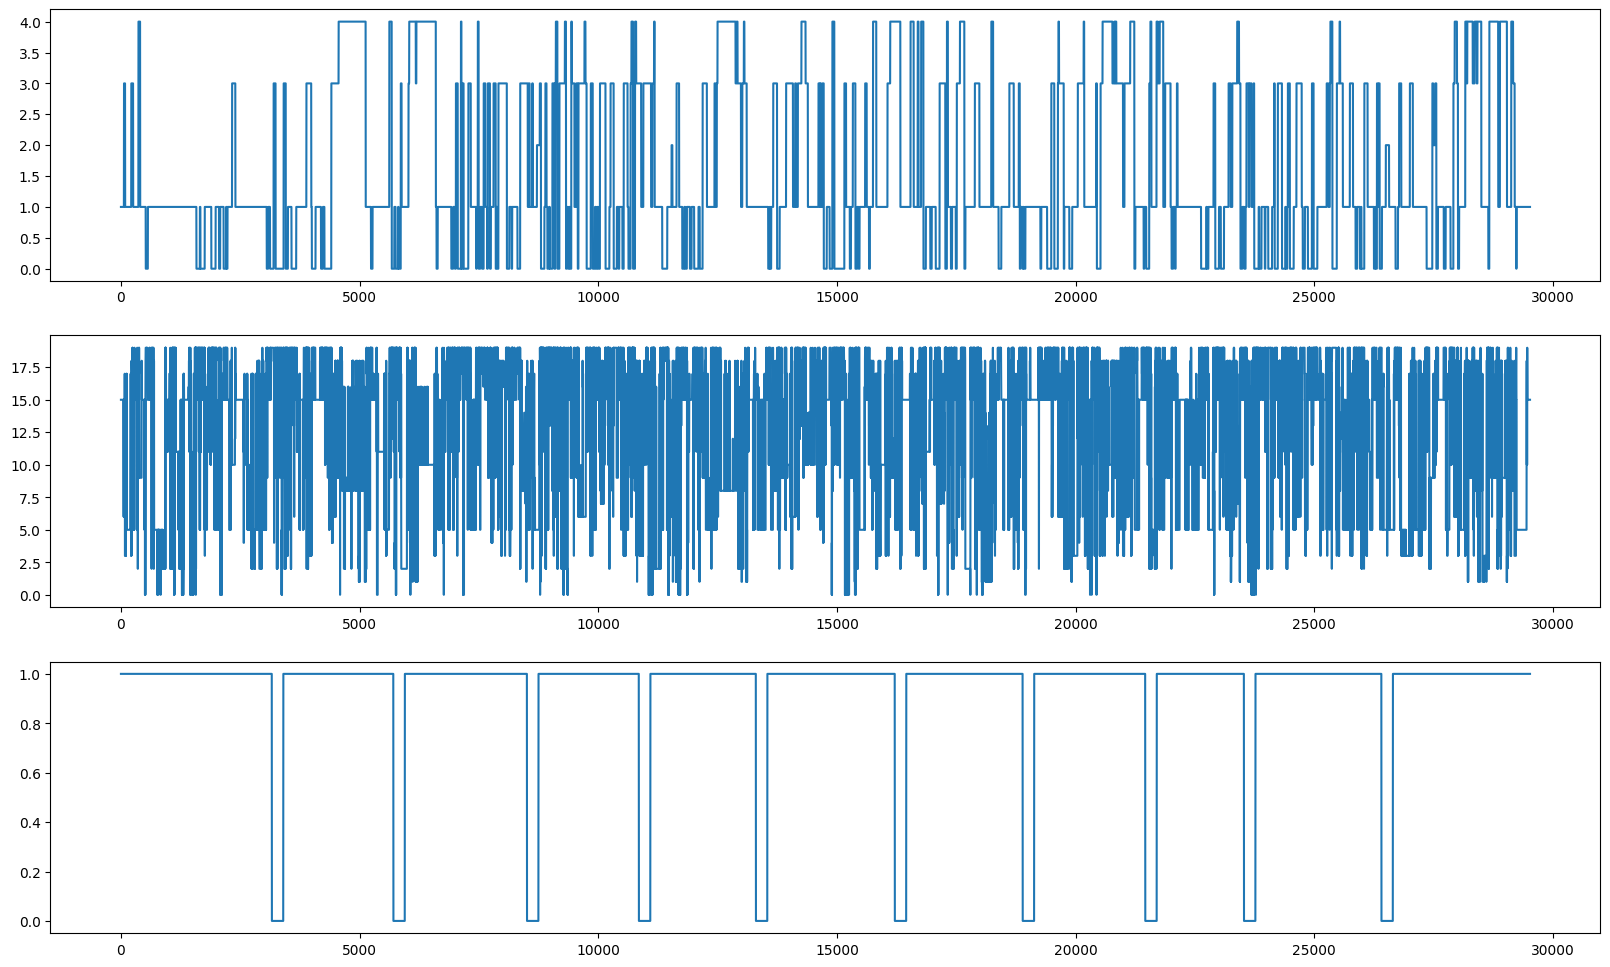

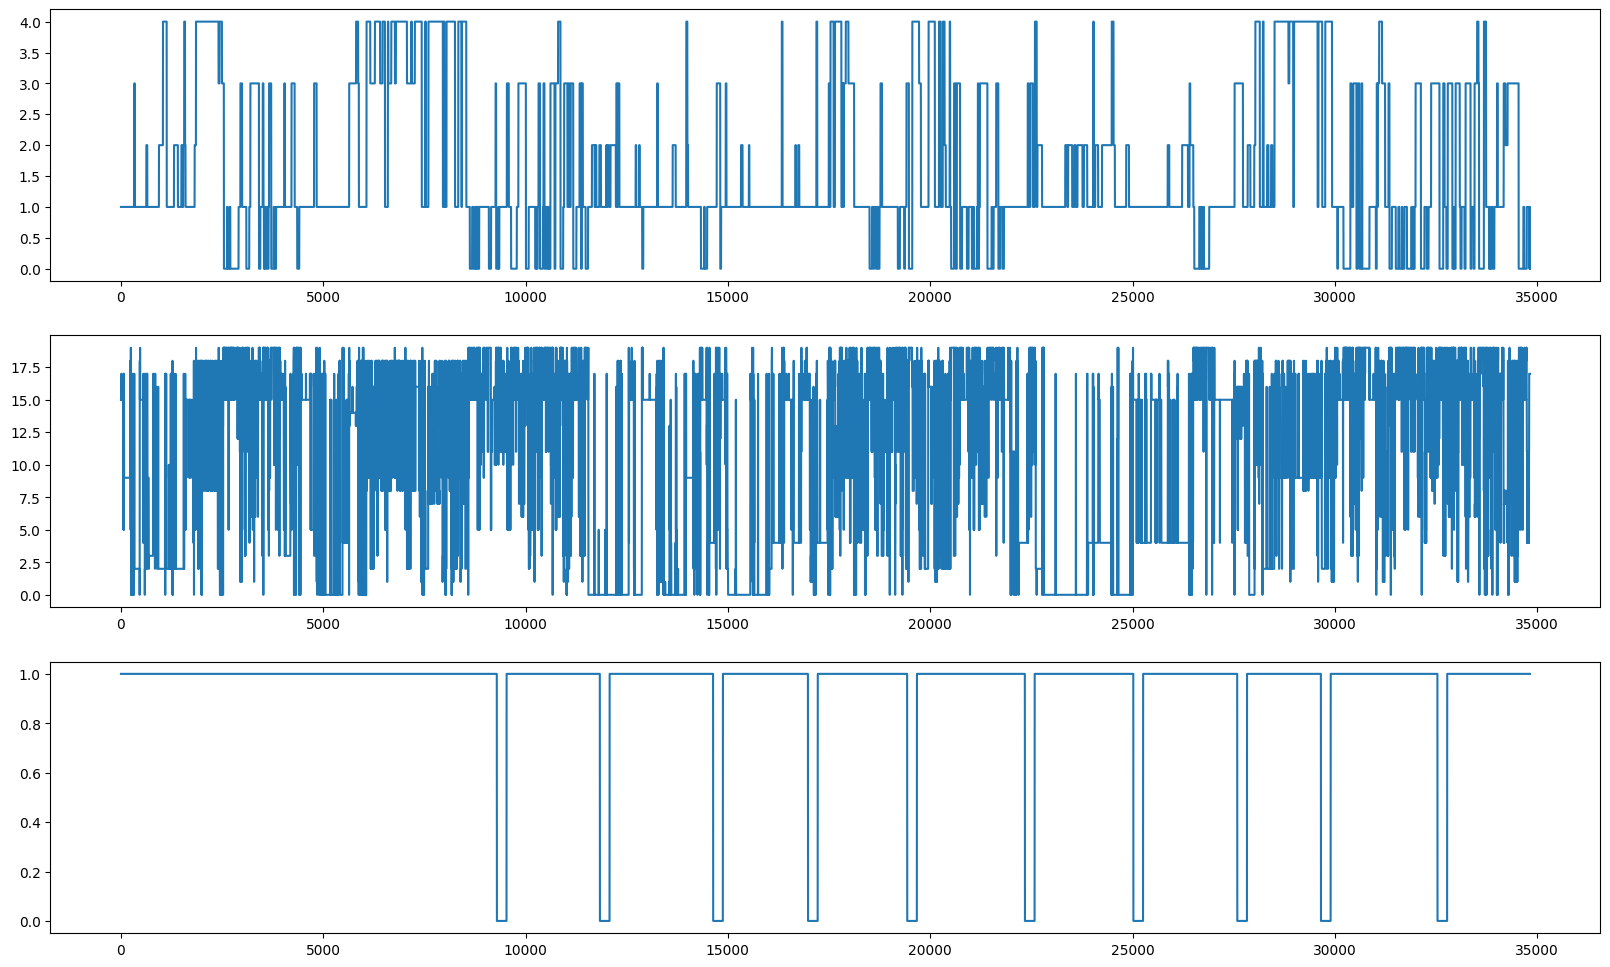

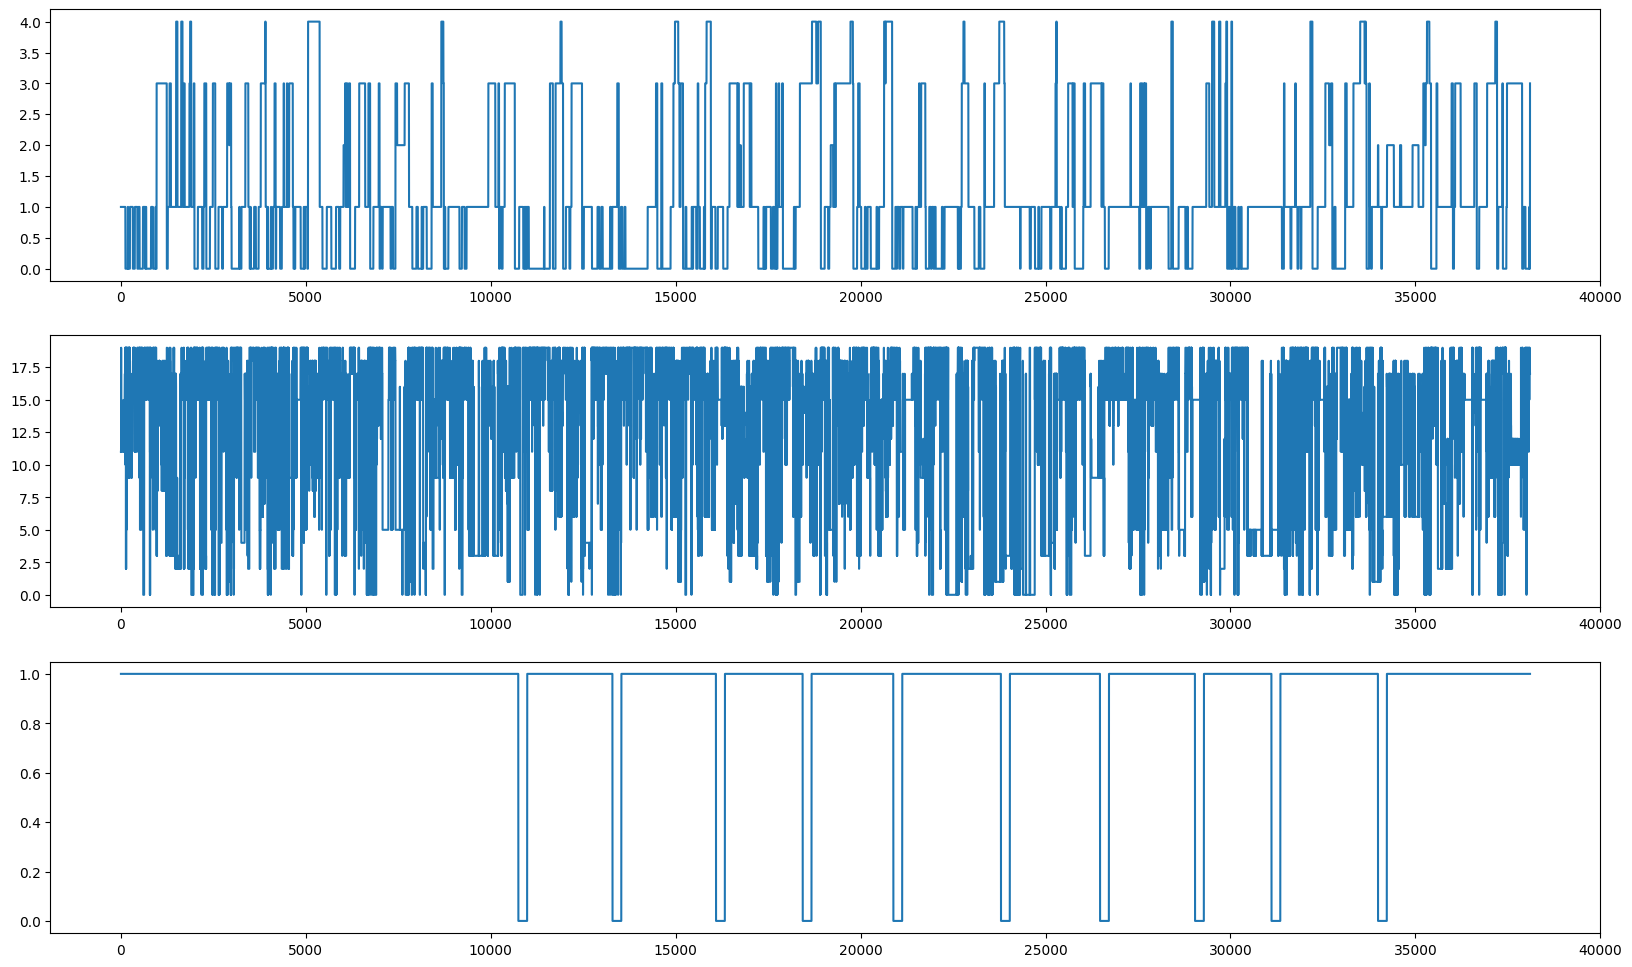

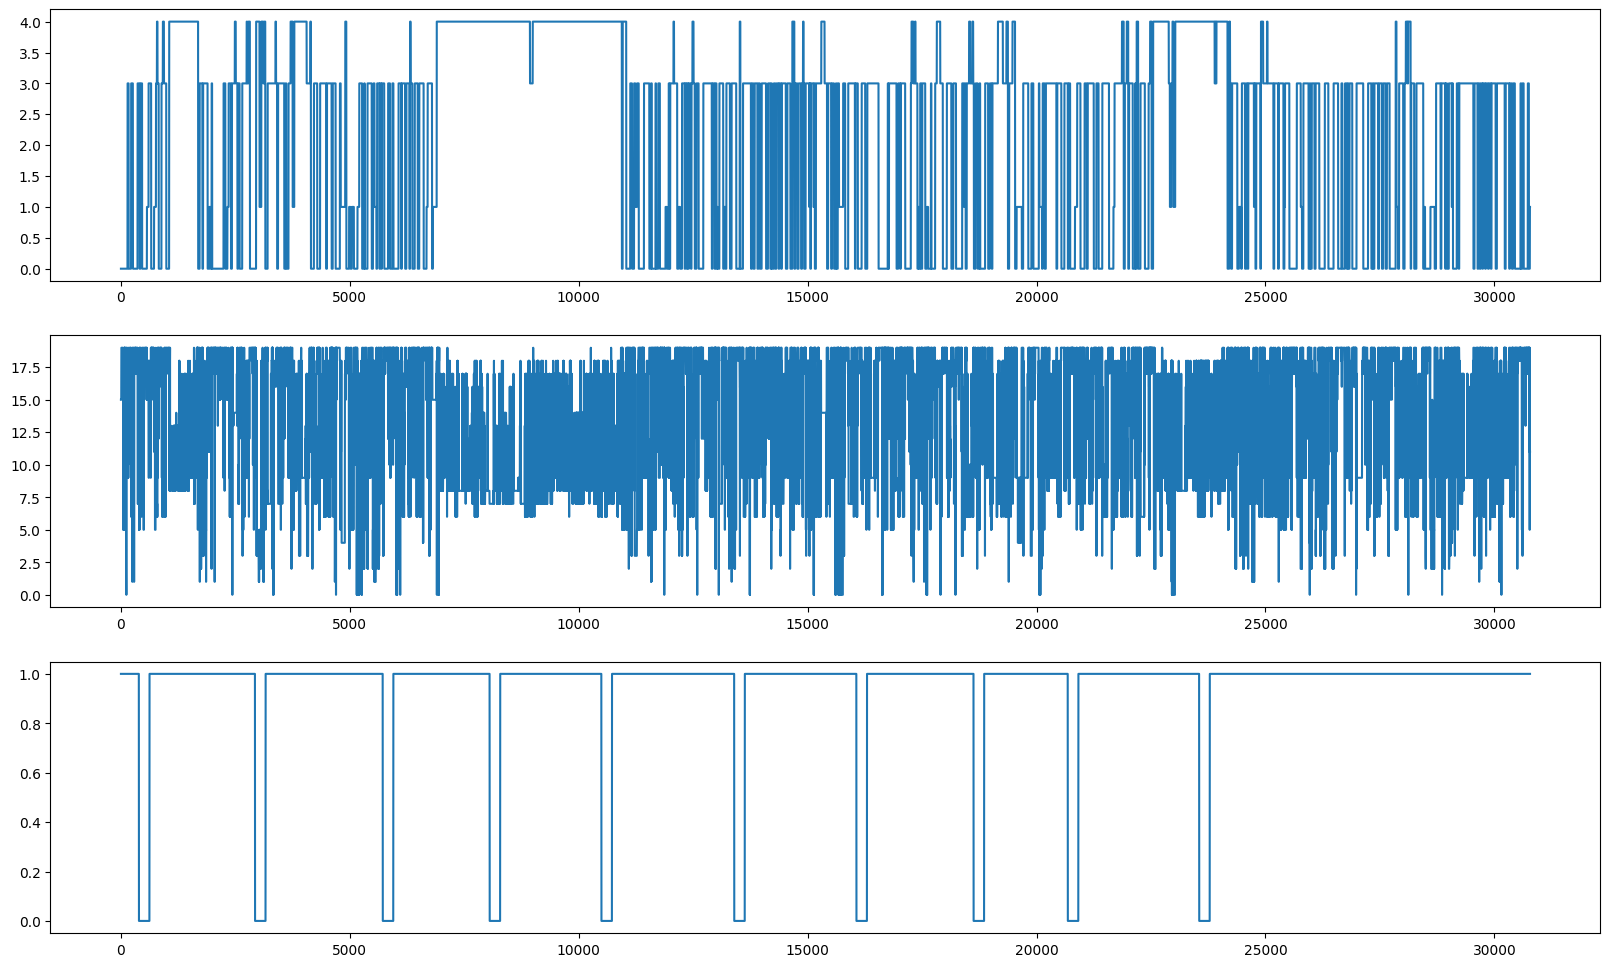

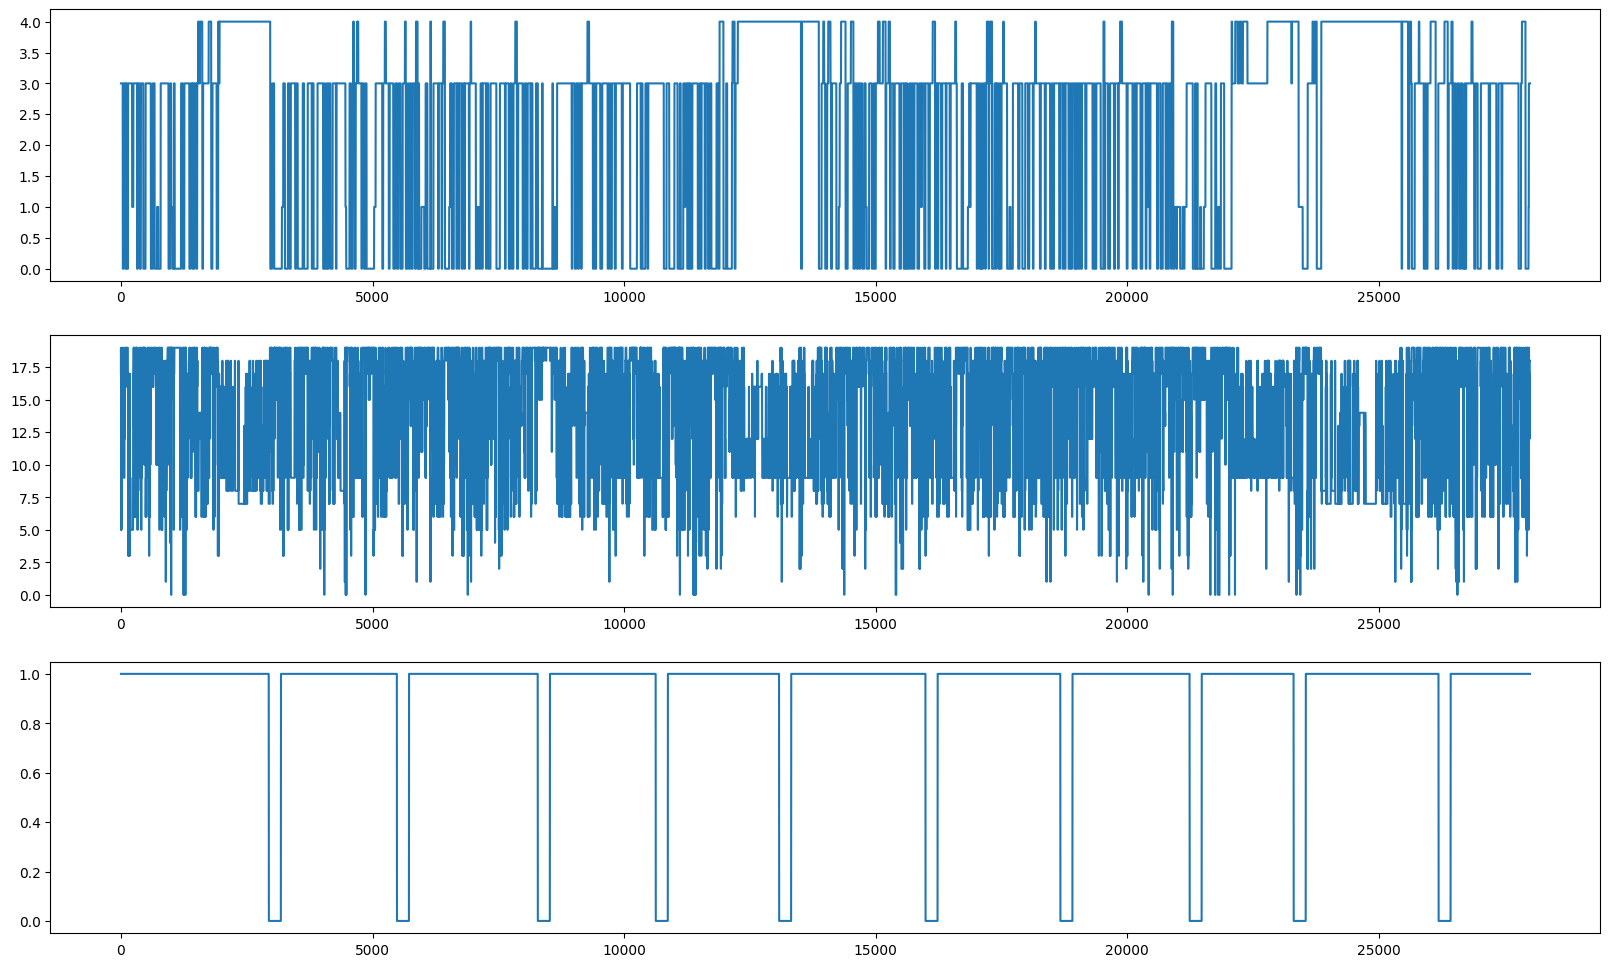

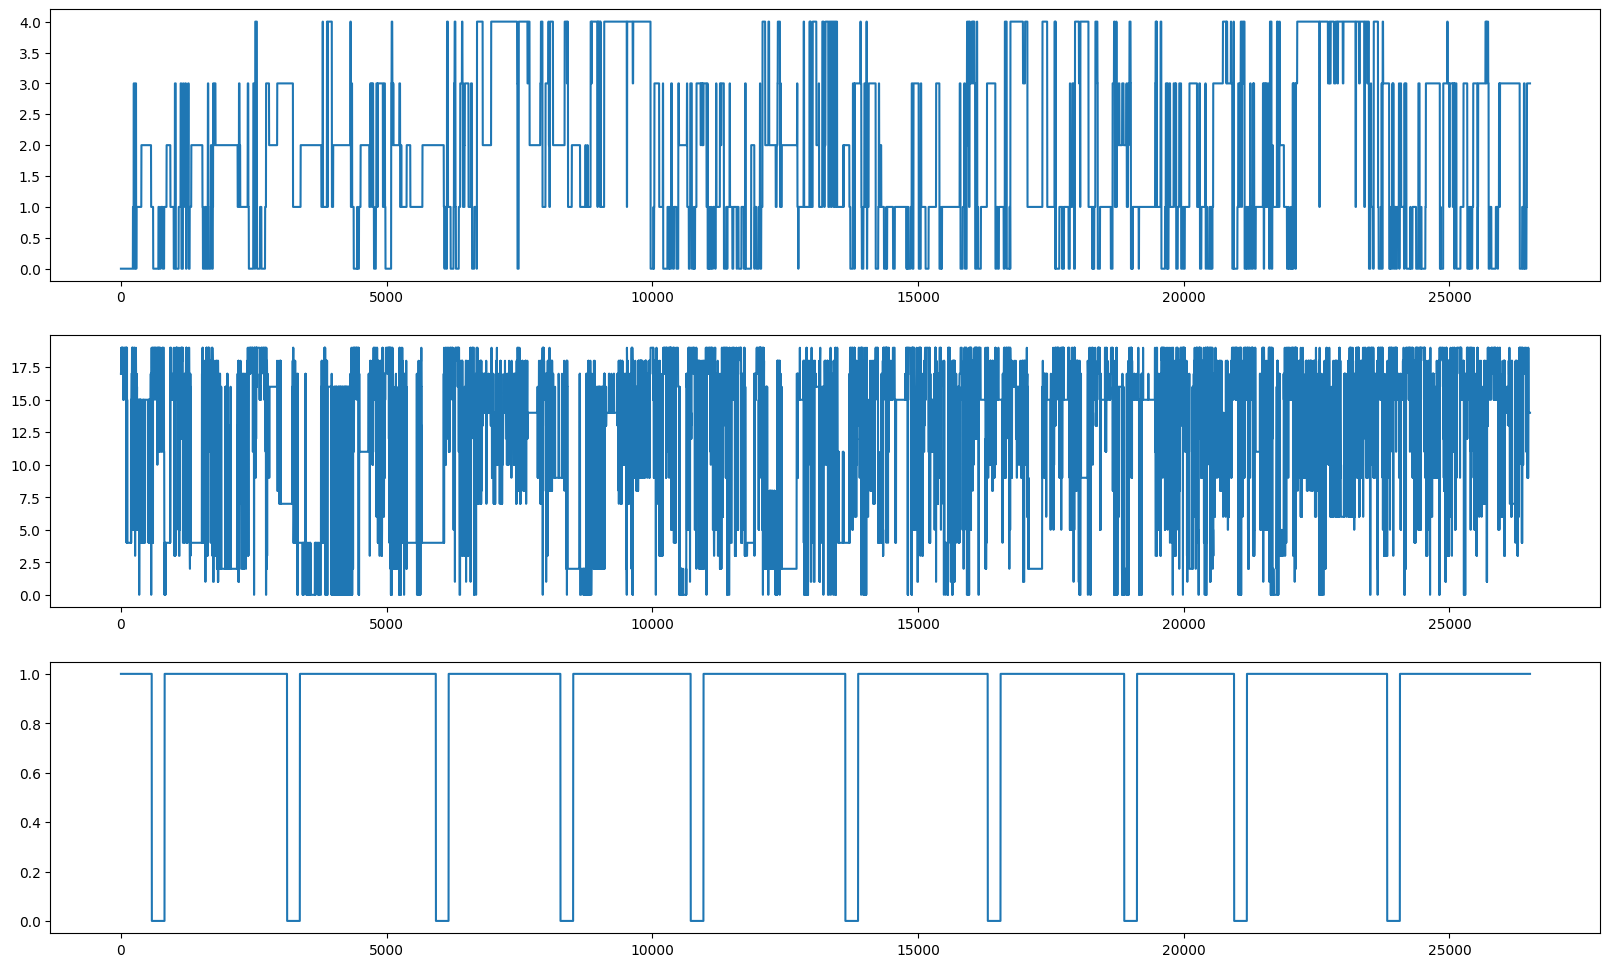

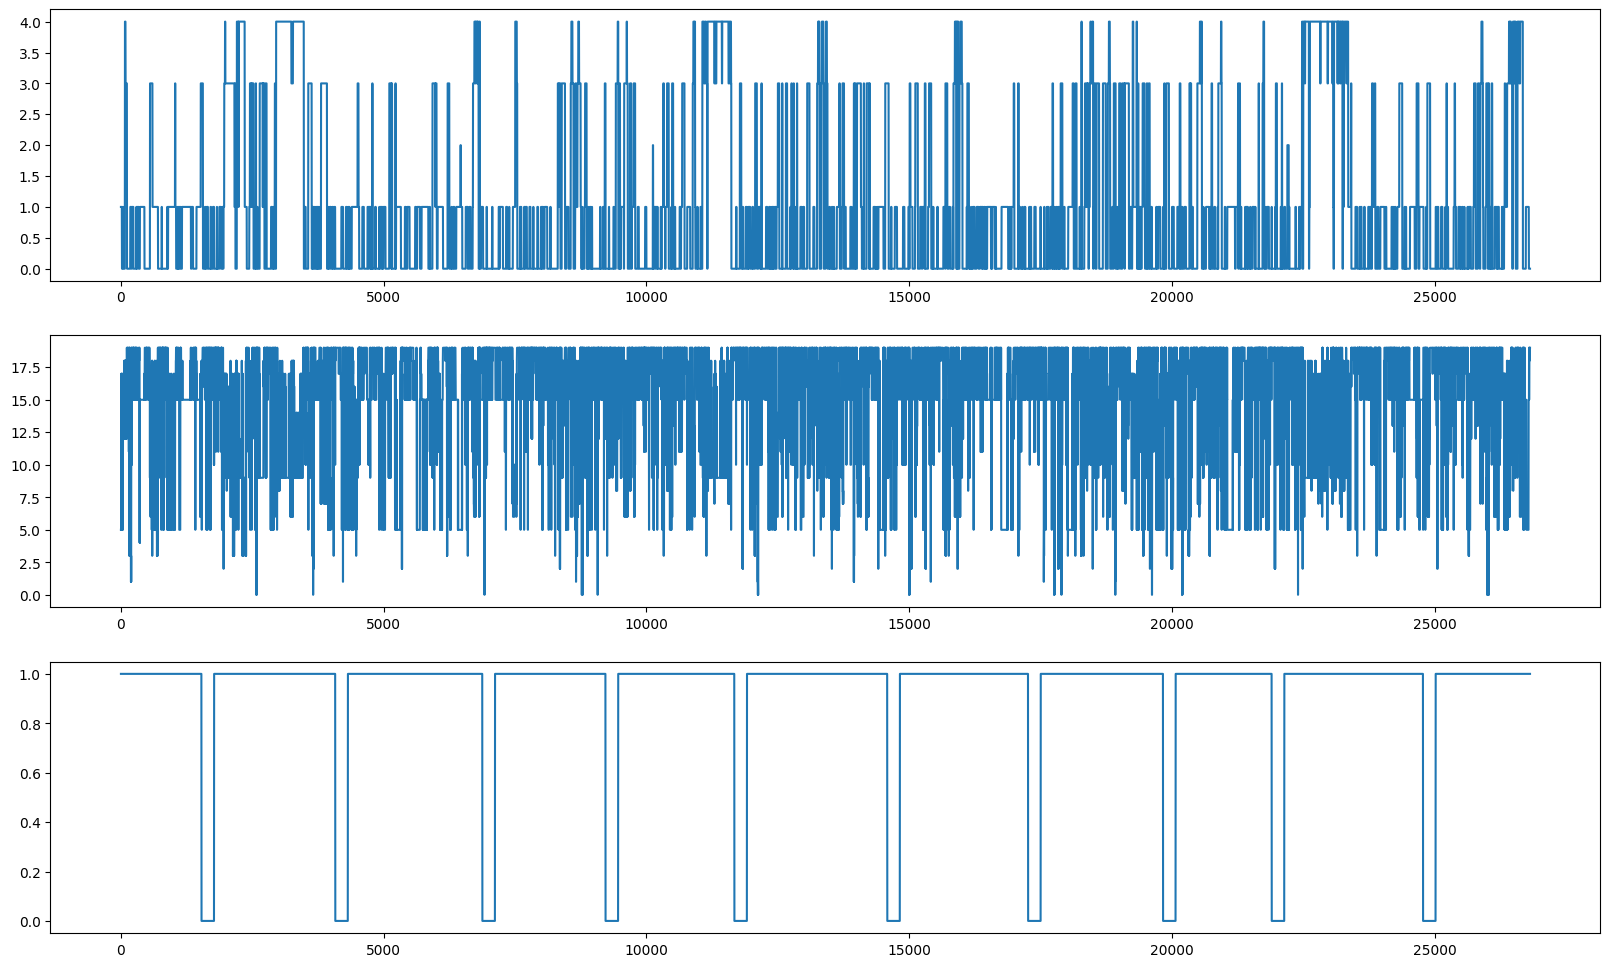

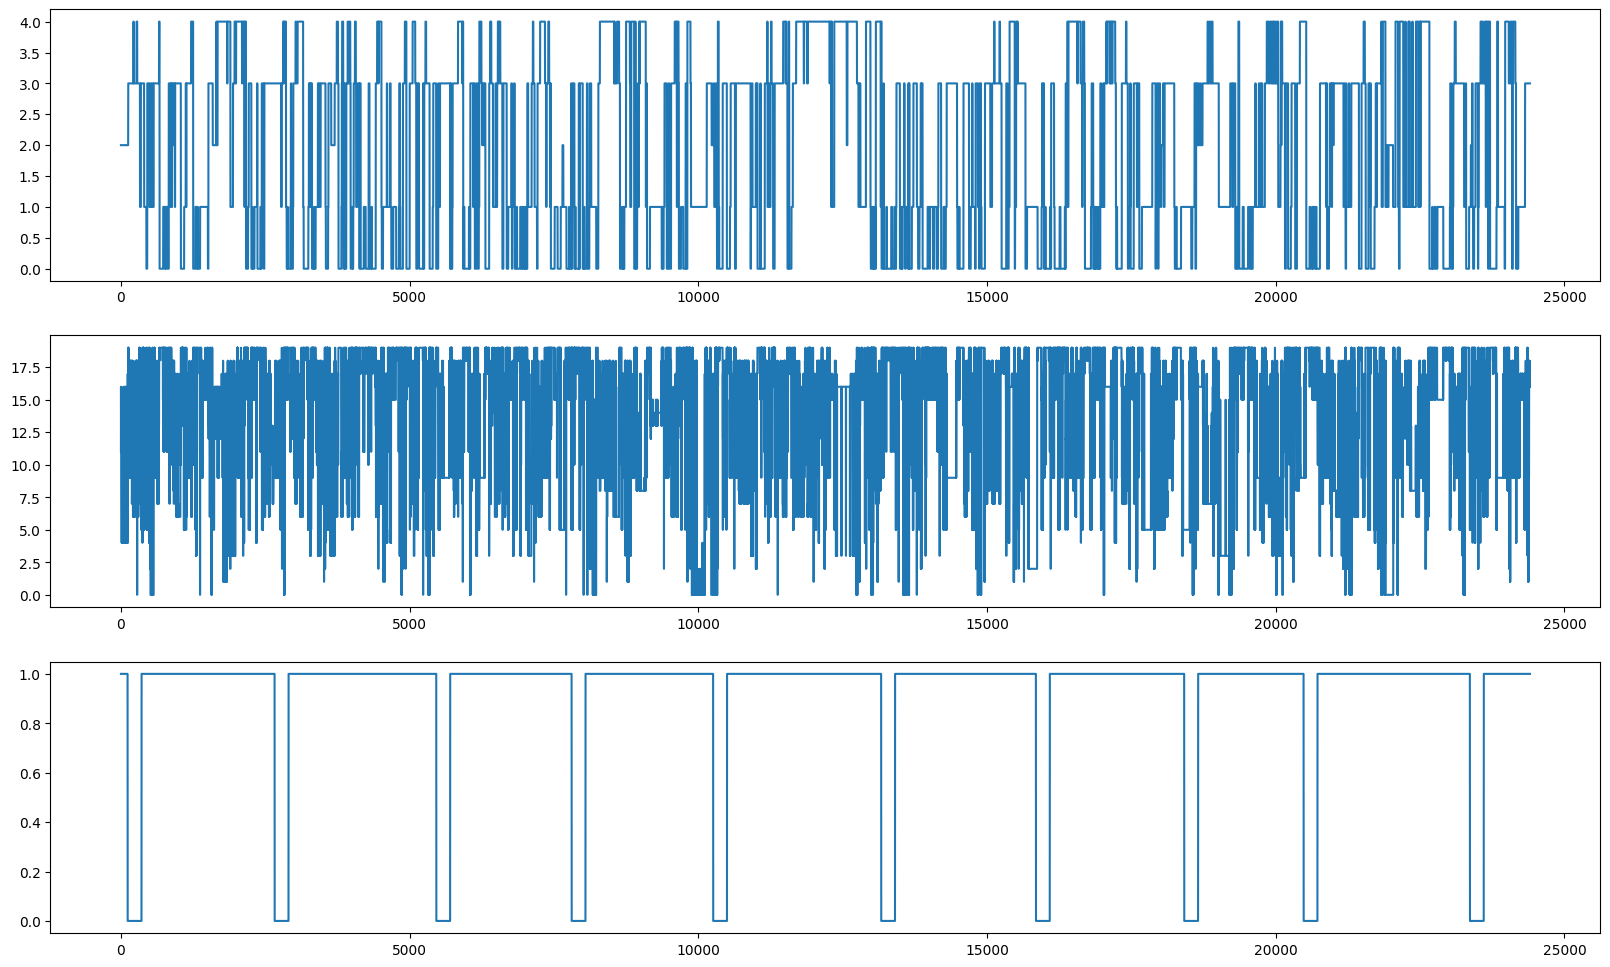

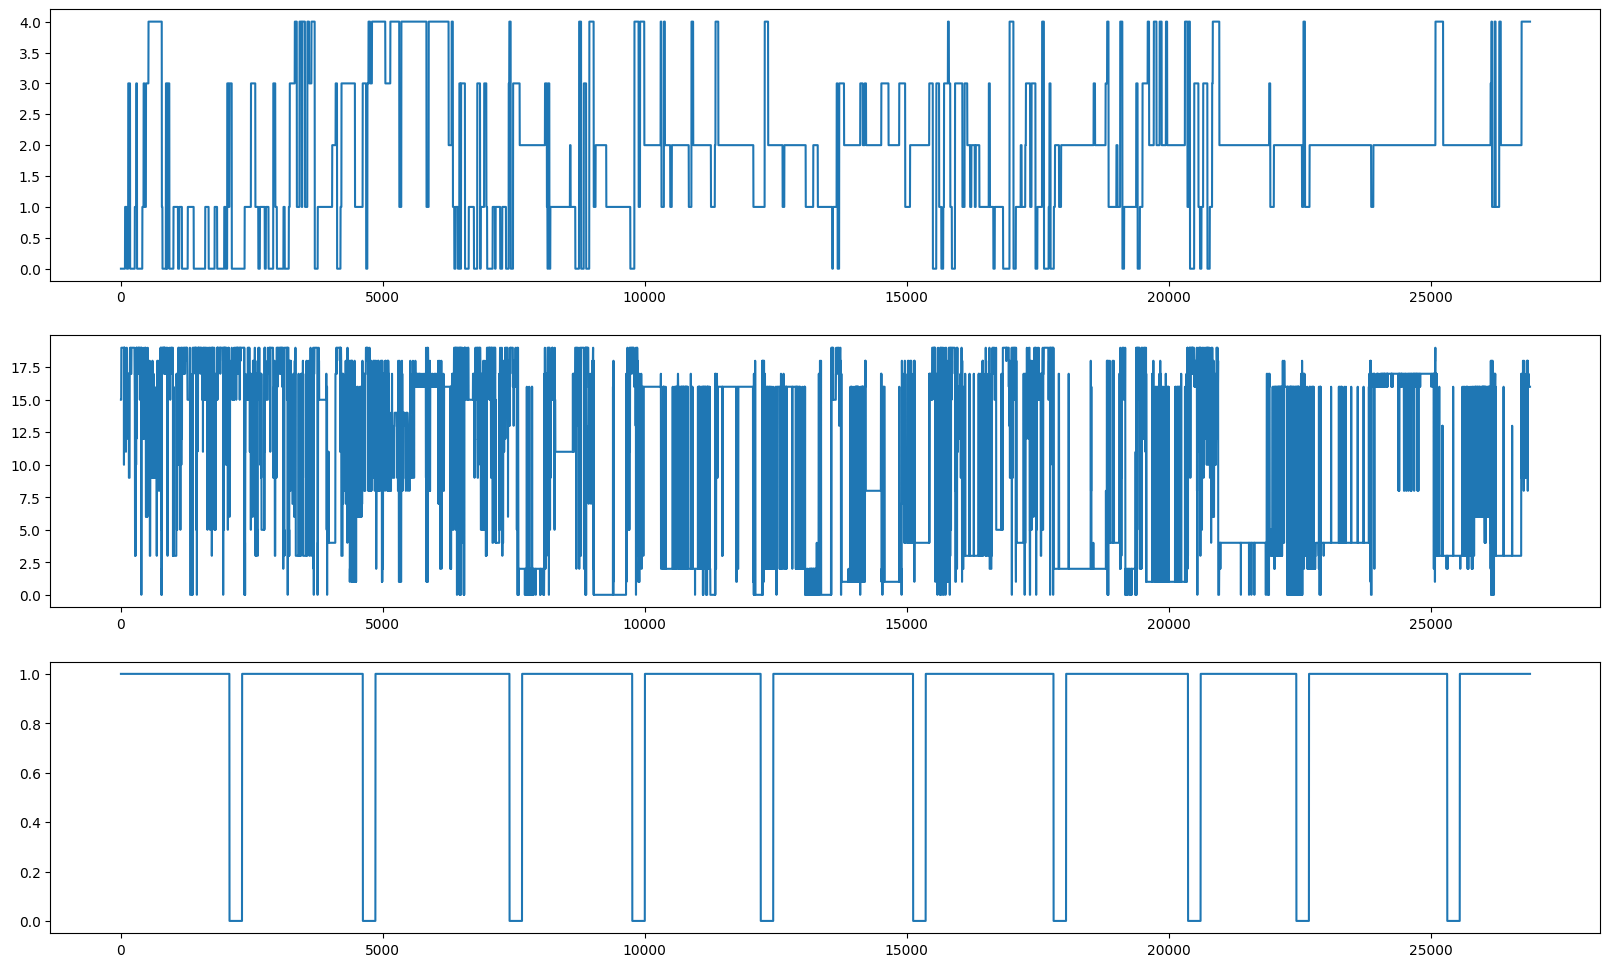

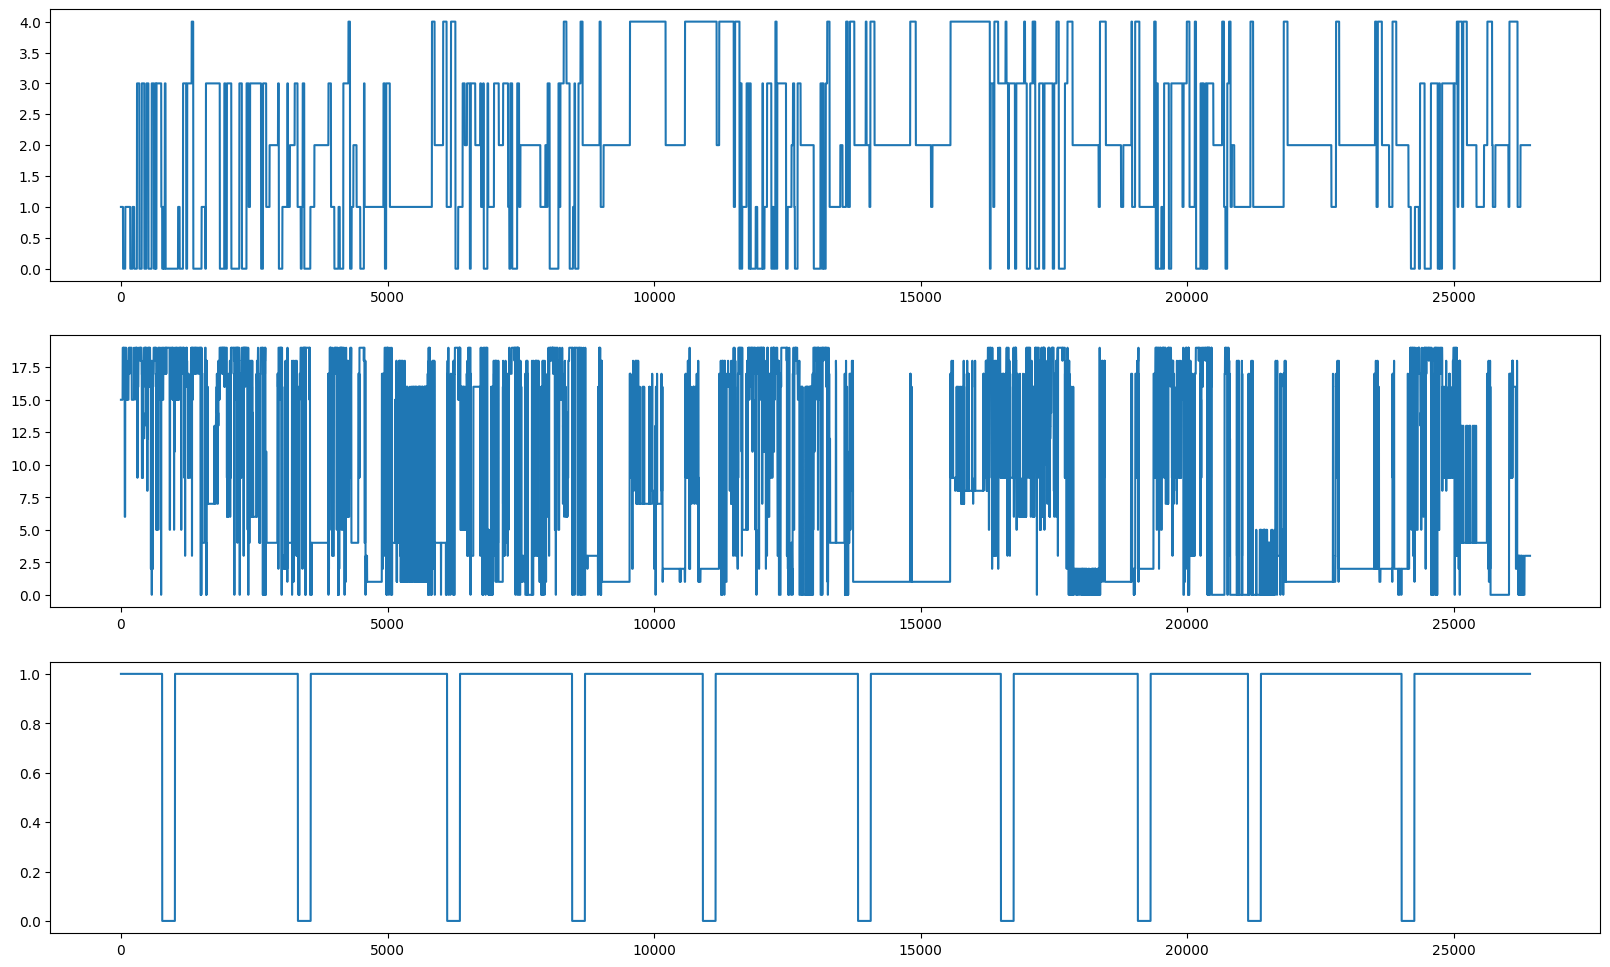

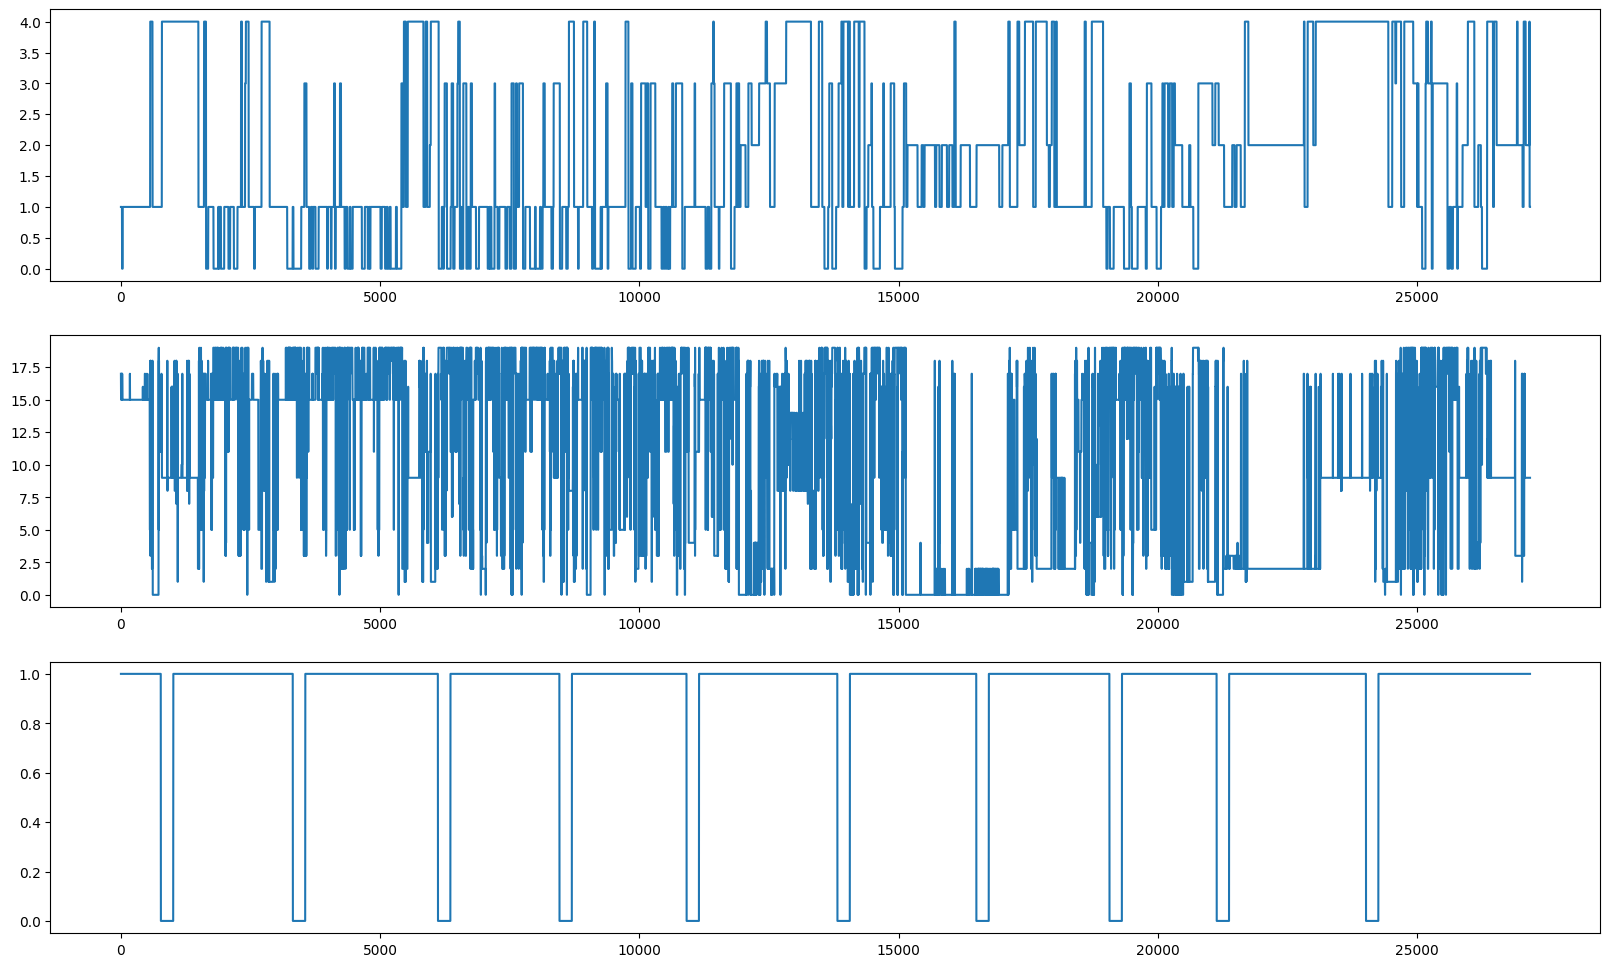

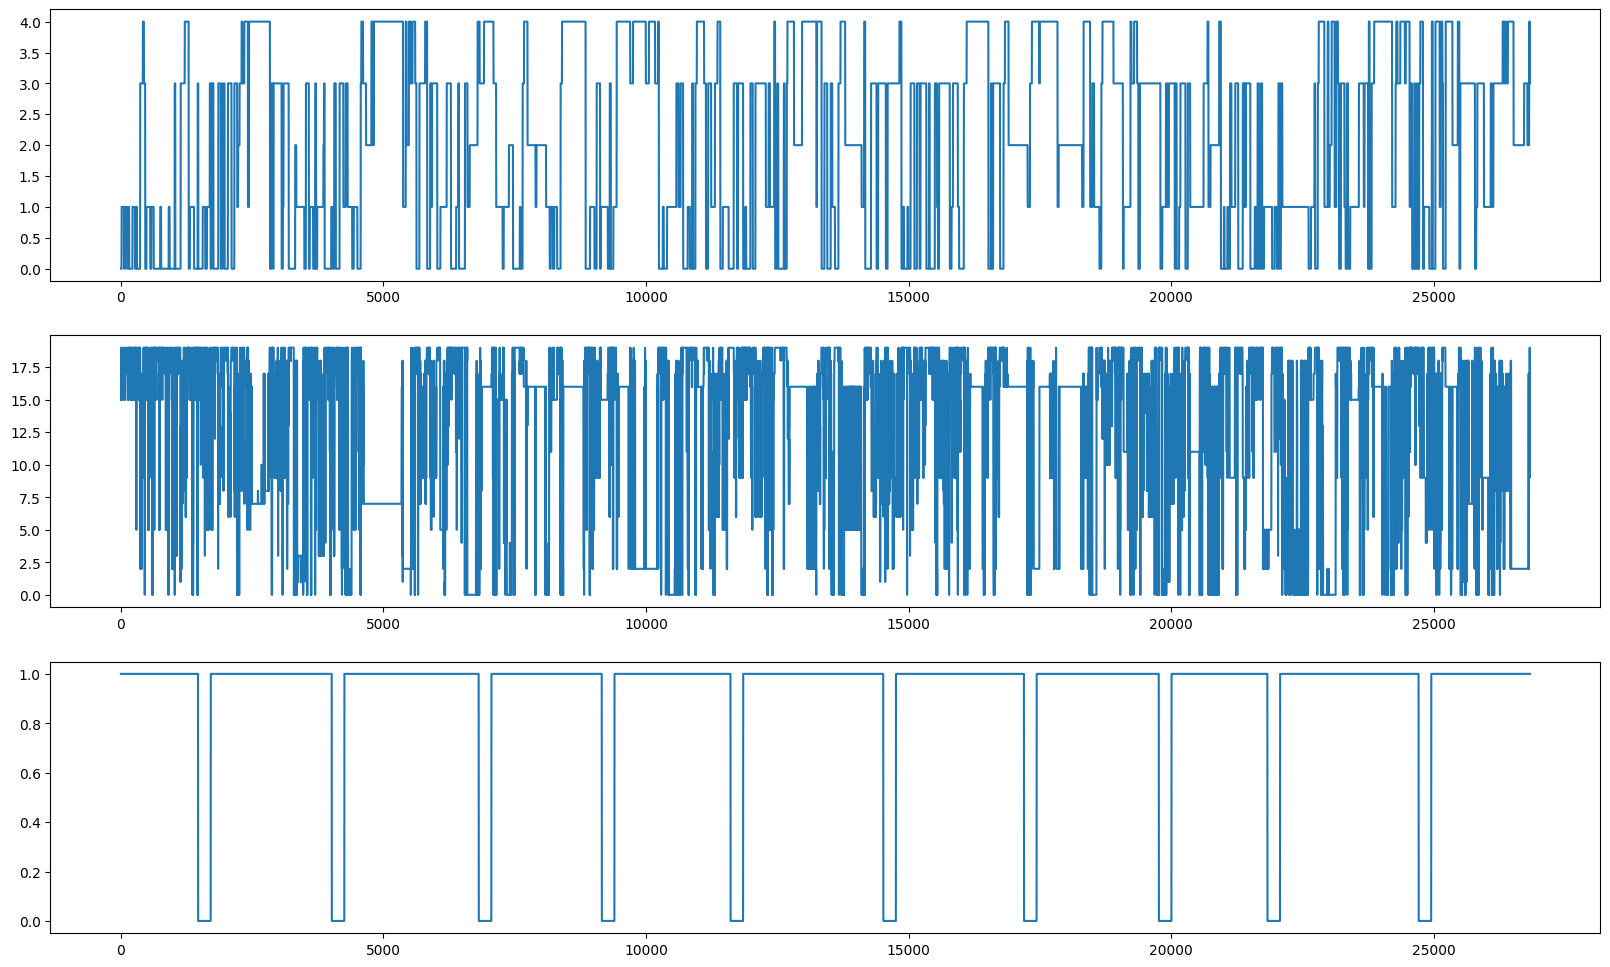

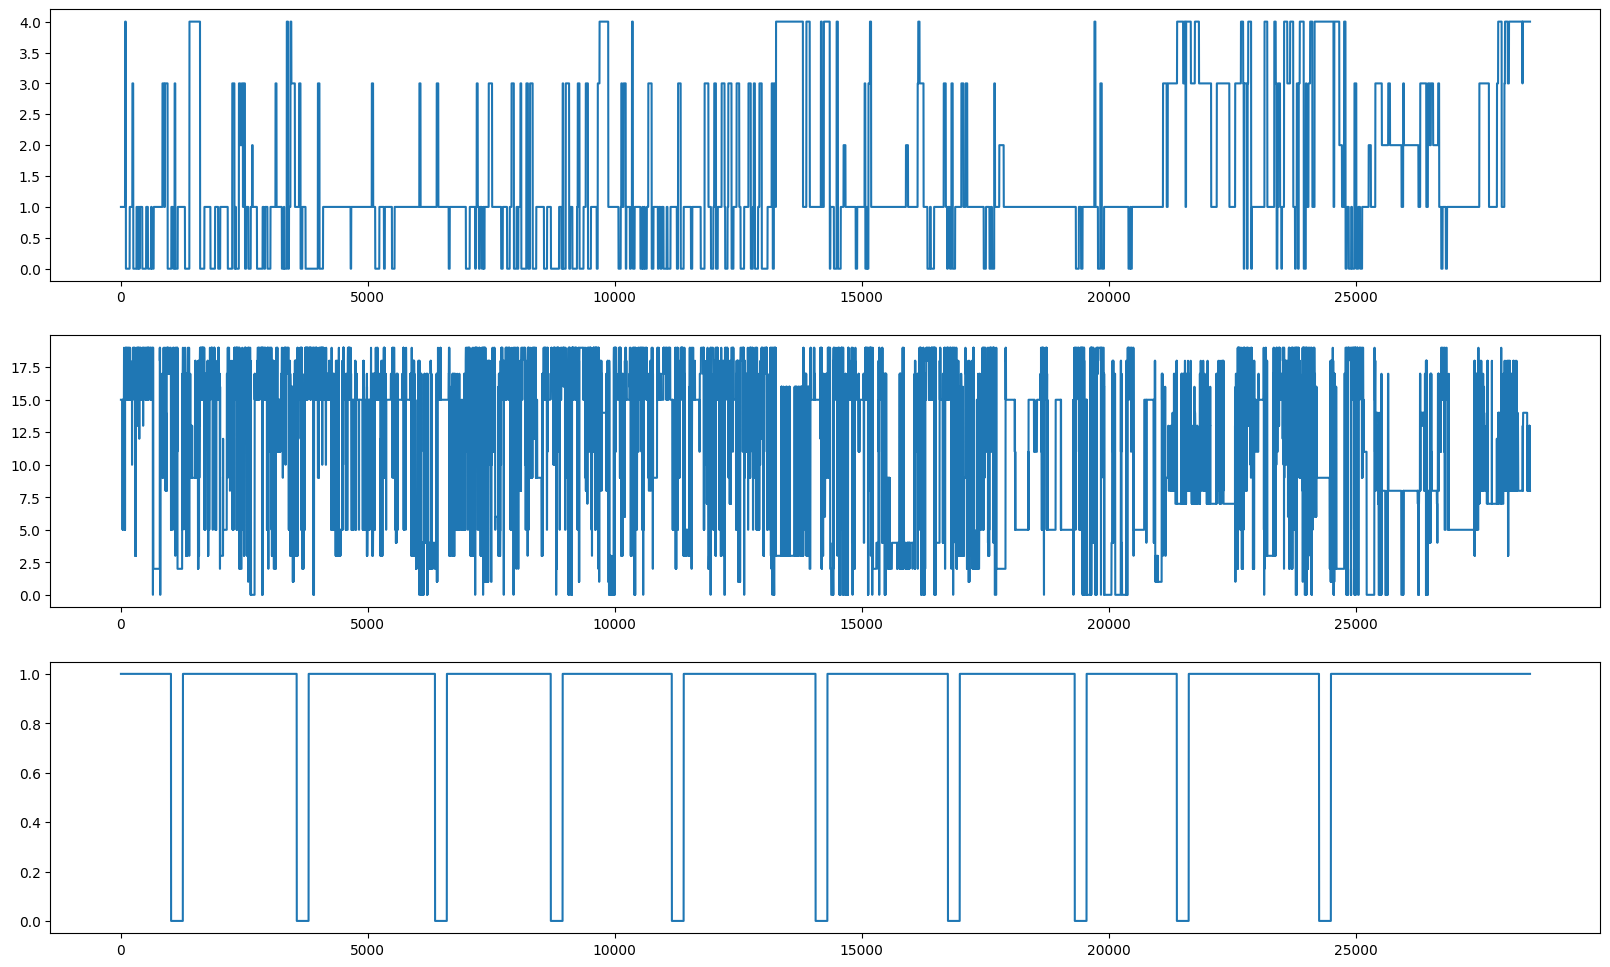

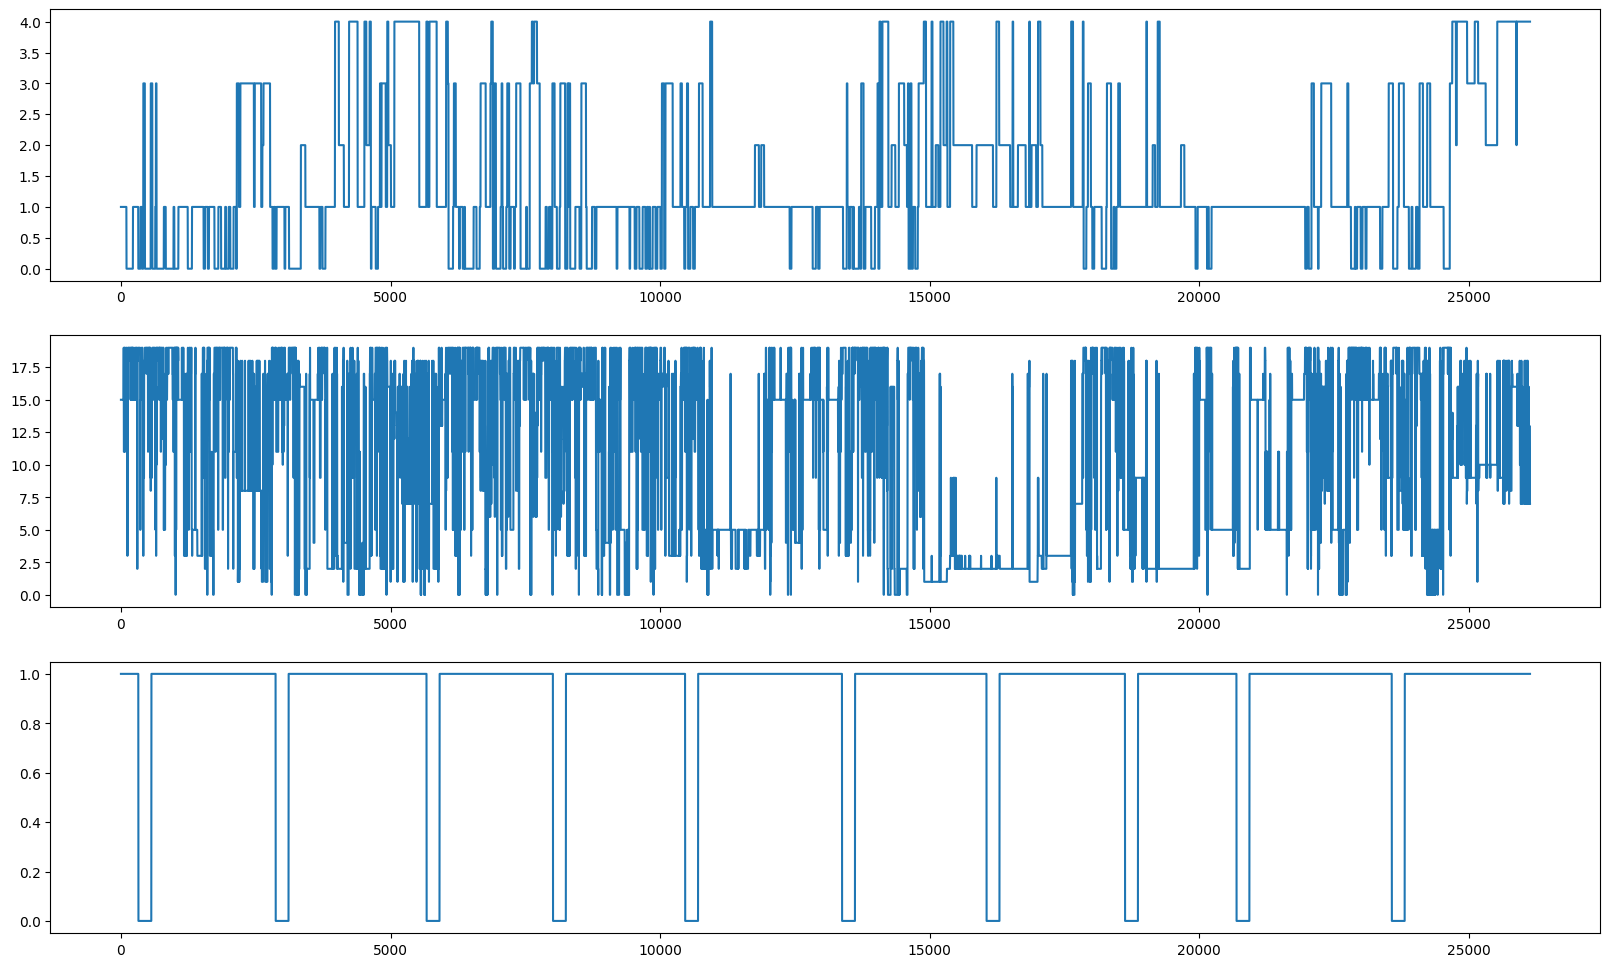

In [13]:
for id in range(8):
    plt.figure(figsize=(20,12))
    plt.subplot(311)
    plt.plot(PNOC_behavs[id])
    plt.subplot(312)
    plt.plot(PNOC_bsoidlabels[id])
    plt.subplot(313)
    plt.plot(PNOC_stims[id])

for id in range(11):
    plt.figure(figsize=(20,12))
    plt.subplot(311)
    plt.plot(NTS_behavs[id])
    plt.subplot(312)
    plt.plot(NTS_bsoidlabels[id])
    plt.subplot(313)
    plt.plot(NTS_stims[id])

plt.show()

### Overall Trend of each behavior

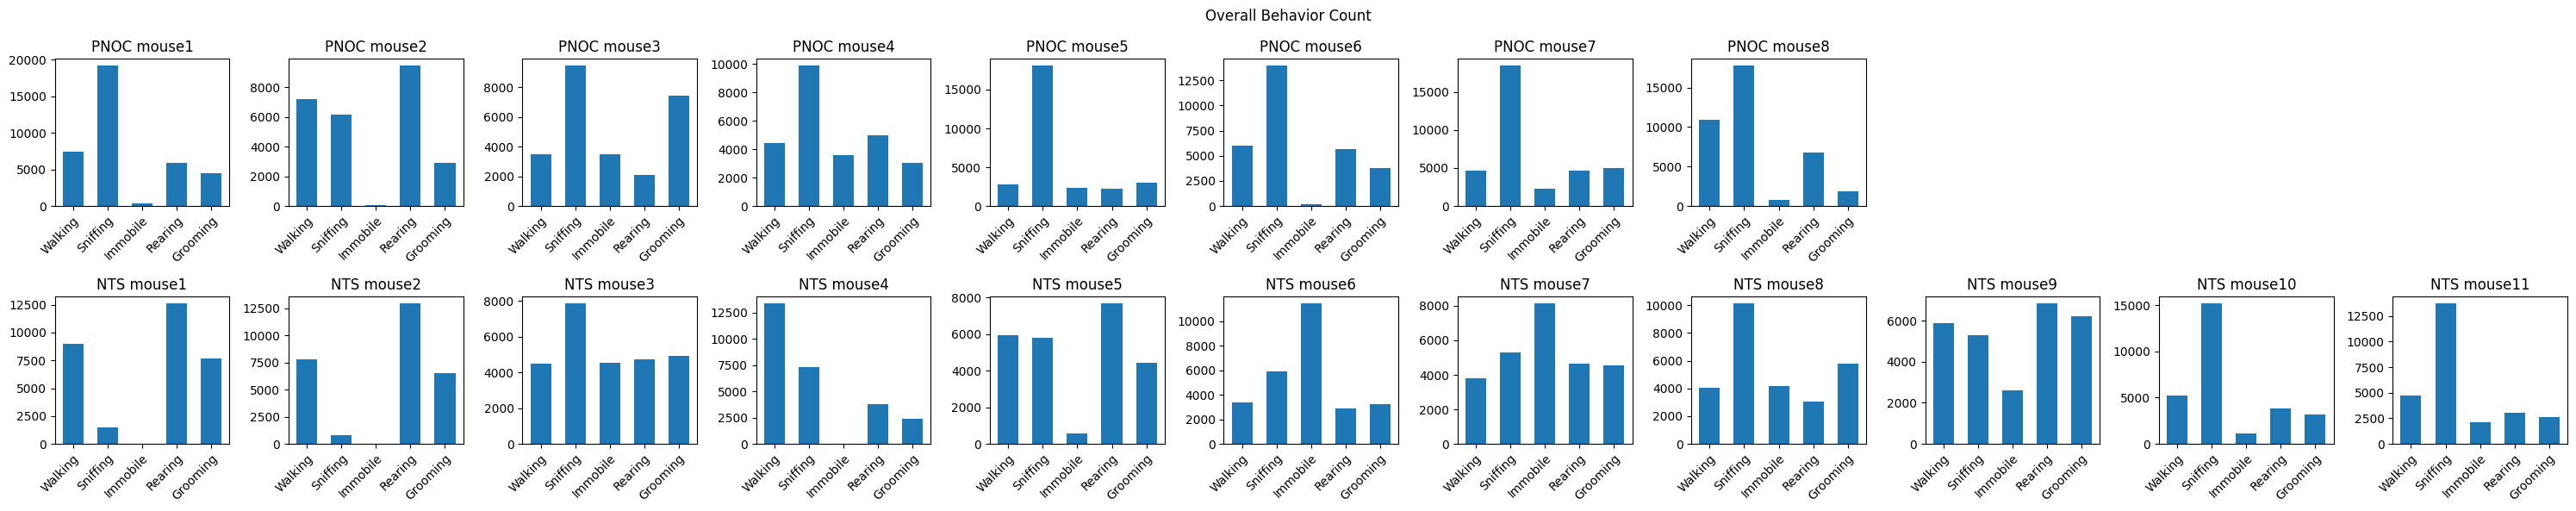

In [14]:
######## A-SOiD #############
plt.figure(figsize=(30,6))
plt.suptitle("Overall Behavior Count")
for i in range(8):
    plt.subplot(2,11,1+i)
    plt.title(f"PNOC mouse{i+1}")
    bin_edges = np.arange(-0.5, behav_num, 1)
    plt.hist(PNOC_behavs[i], bins = bin_edges,rwidth=0.6)
    plt.xticks(ticks=np.arange(0, behav_num), labels=Behav, rotation=45, ha='right', rotation_mode='anchor')

for i in range(11):
    plt.subplot(2,11,12+i)
    plt.title(f"NTS mouse{i+1}")
    bin_edges = np.arange(-0.5, behav_num, 1)
    plt.hist(NTS_behavs[i], bins = bin_edges,rwidth=0.6)
    plt.xticks(ticks=np.arange(0, behav_num), labels=Behav, rotation=45, ha='right', rotation_mode='anchor')


plt.tight_layout()
plt.show()

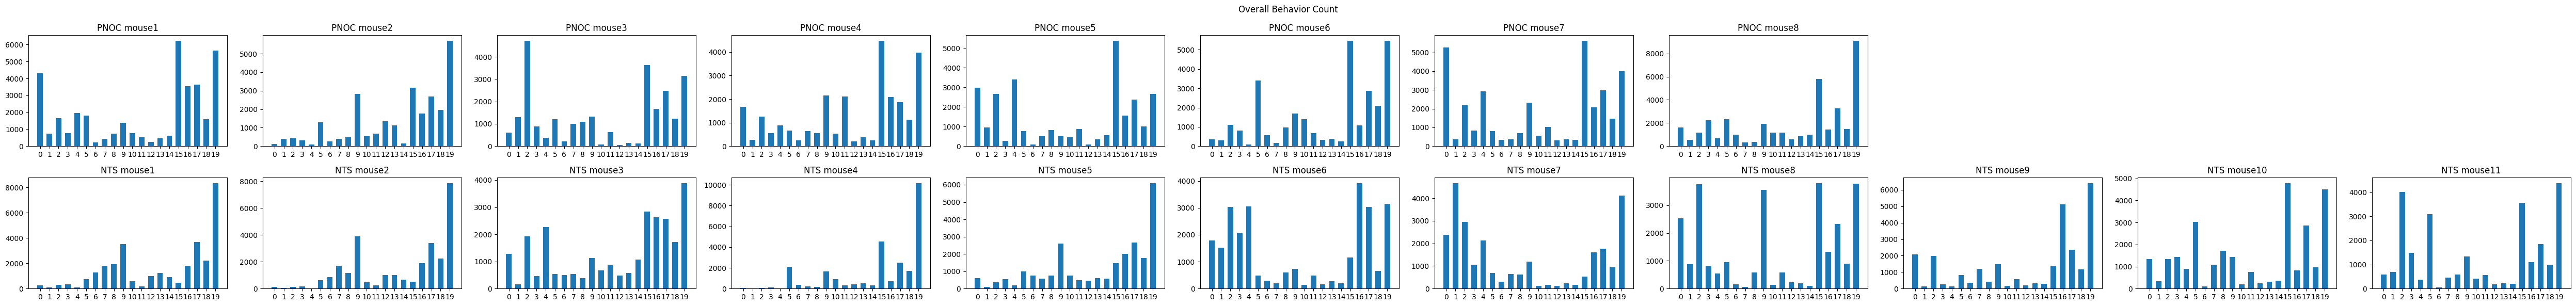

In [15]:
######## A-SOiD #############
plt.figure(figsize=(50,6))
plt.suptitle("Overall Behavior Count")
for i in range(8):
    plt.subplot(2,11,1+i)
    plt.title(f"PNOC mouse{i+1}")
    bin_edges = np.arange(-0.5, label_num, 1)
    plt.hist(PNOC_bsoidlabels[i], bins = bin_edges,rwidth=0.6)
    plt.xticks(ticks=np.arange(0, label_num))

for i in range(11):
    plt.subplot(2,11,12+i)
    plt.title(f"NTS mouse{i+1}")
    bin_edges = np.arange(-0.5, label_num, 1)
    plt.hist(NTS_bsoidlabels[i], bins = bin_edges,rwidth=0.6)
    plt.xticks(ticks=np.arange(0, label_num))


plt.tight_layout()
plt.show()

### Overall Bout Duration

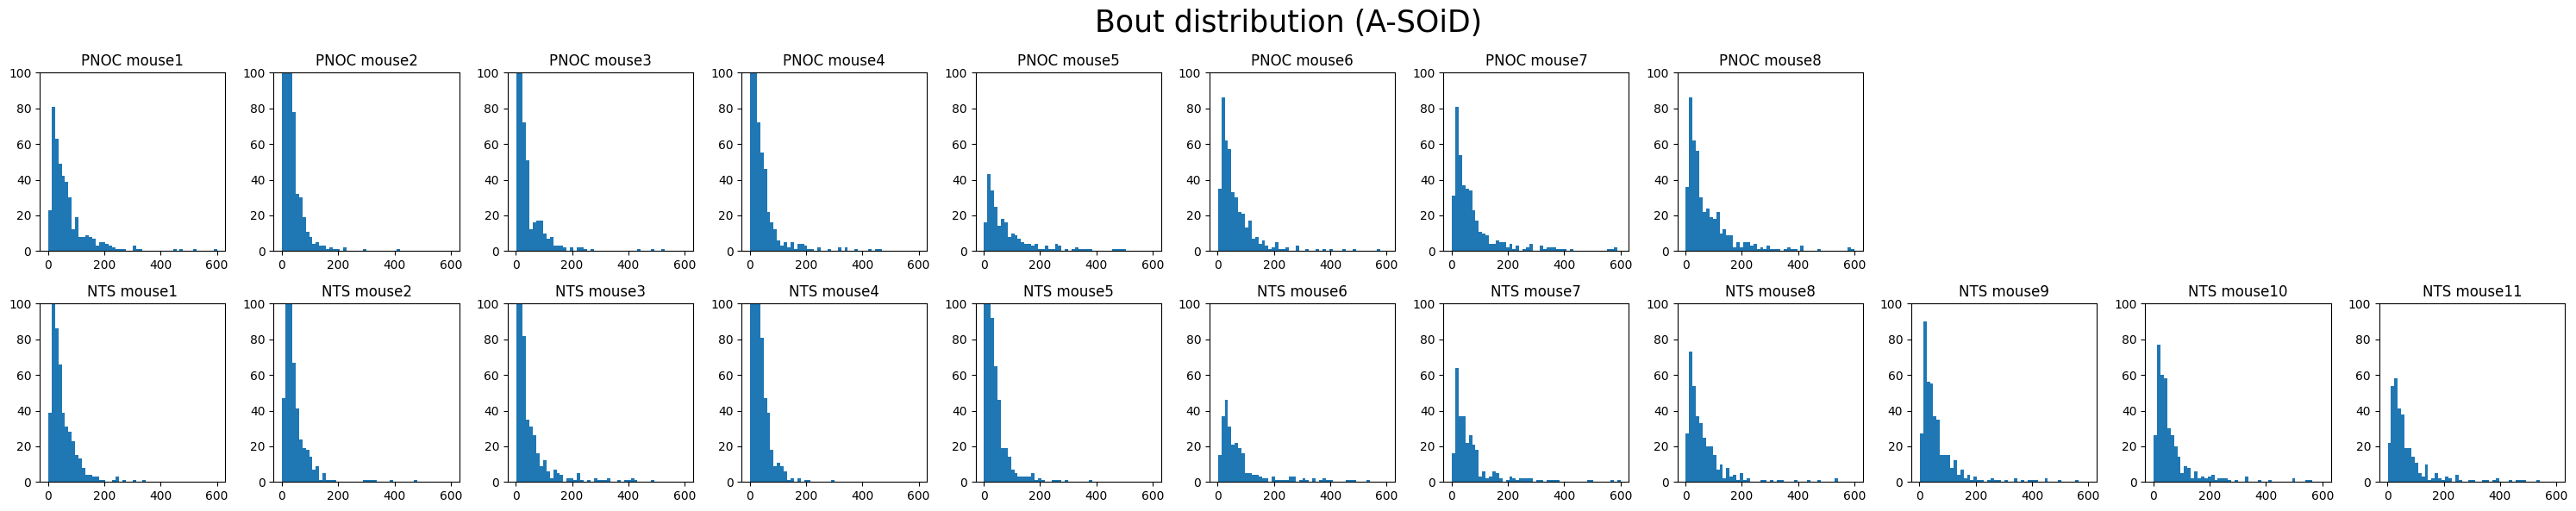

In [16]:
## Creae a bout duration array
PNOC_bout = []
NTS_bout = []
for i, data in enumerate(PNOC_behavs):
    bout_len = 0
    bout_array = np.zeros(len(data))
    for time in range(len(data)-1):
        bout_len+=1 
        if data[time] != data[time+1]:
            bout_array[time-(bout_len//2)] = bout_len
            bout_len = 0
        else:
            pass
    bout_array[-1] = bout_len
    PNOC_bout.append(bout_array)

for i, data in enumerate(NTS_behavs):
    bout_len = 0
    bout_array = np.zeros(len(data))
    for time in range(len(data)-1):
        bout_len+=1 
        if data[time] != data[time+1]:
            bout_array[time-(bout_len//2)] = bout_len
            bout_len = 0
        else:
            pass
    bout_array[-1] = bout_len
    NTS_bout.append(bout_array)

plt.figure(figsize=(30,6))
plt.suptitle("Bout distribution (A-SOiD)", fontsize=25)
for i in range(8):
    plt.subplot(2,11,1+i)
    plt.title(f"PNOC mouse{i+1}")
    plt.hist(PNOC_bout[i], bins = 50, range=[1,600])
    plt.ylim([0,100])

for i in range(11):
    plt.subplot(2,11,12+i)
    plt.title(f"NTS mouse{i+1}")
    plt.hist(NTS_bout[i], bins = 50, range=[1,600])
    plt.ylim([0,100])


plt.tight_layout()
plt.show()

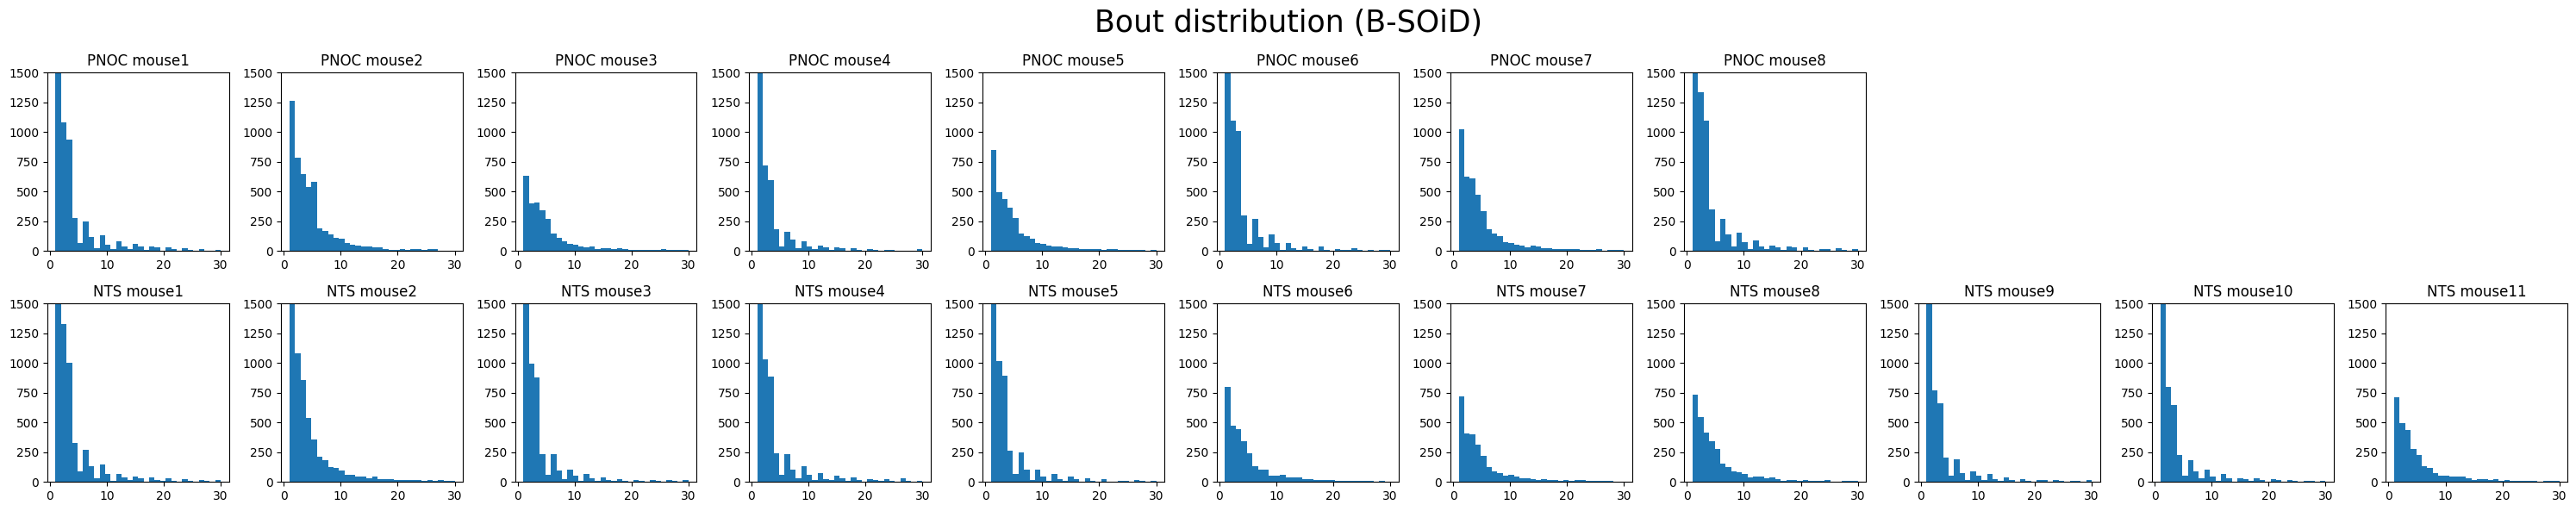

In [17]:
## Creae a bout duration array
plt.figure(figsize=(30,6))
plt.suptitle("Bout distribution (B-SOiD)", fontsize=25)
for i, file in enumerate(PNOC_bsoidbout_files):
    bout_data = pd.read_csv(file)["Run lengths"].to_numpy()
    plt.subplot(2,11,1+i)
    plt.title(f"PNOC mouse{i+1}")
    plt.hist(bout_data, bins = 30, range=[1,30])
    plt.ylim([0,1500])

for i, file in enumerate(NTS_bsoidbout_files):
    bout_data = pd.read_csv(file)["Run lengths"].to_numpy().astype(int)
    plt.subplot(2,11,12+i)
    plt.title(f"NTS mouse{i+1}")
    plt.hist(bout_data, bins = 30, range=[1,30])
    plt.ylim([0,1500])

plt.tight_layout()
plt.show()

### The relationship between B-SOiD clusters and A-SOiD ethograms

<Figure size 1000x1000 with 0 Axes>

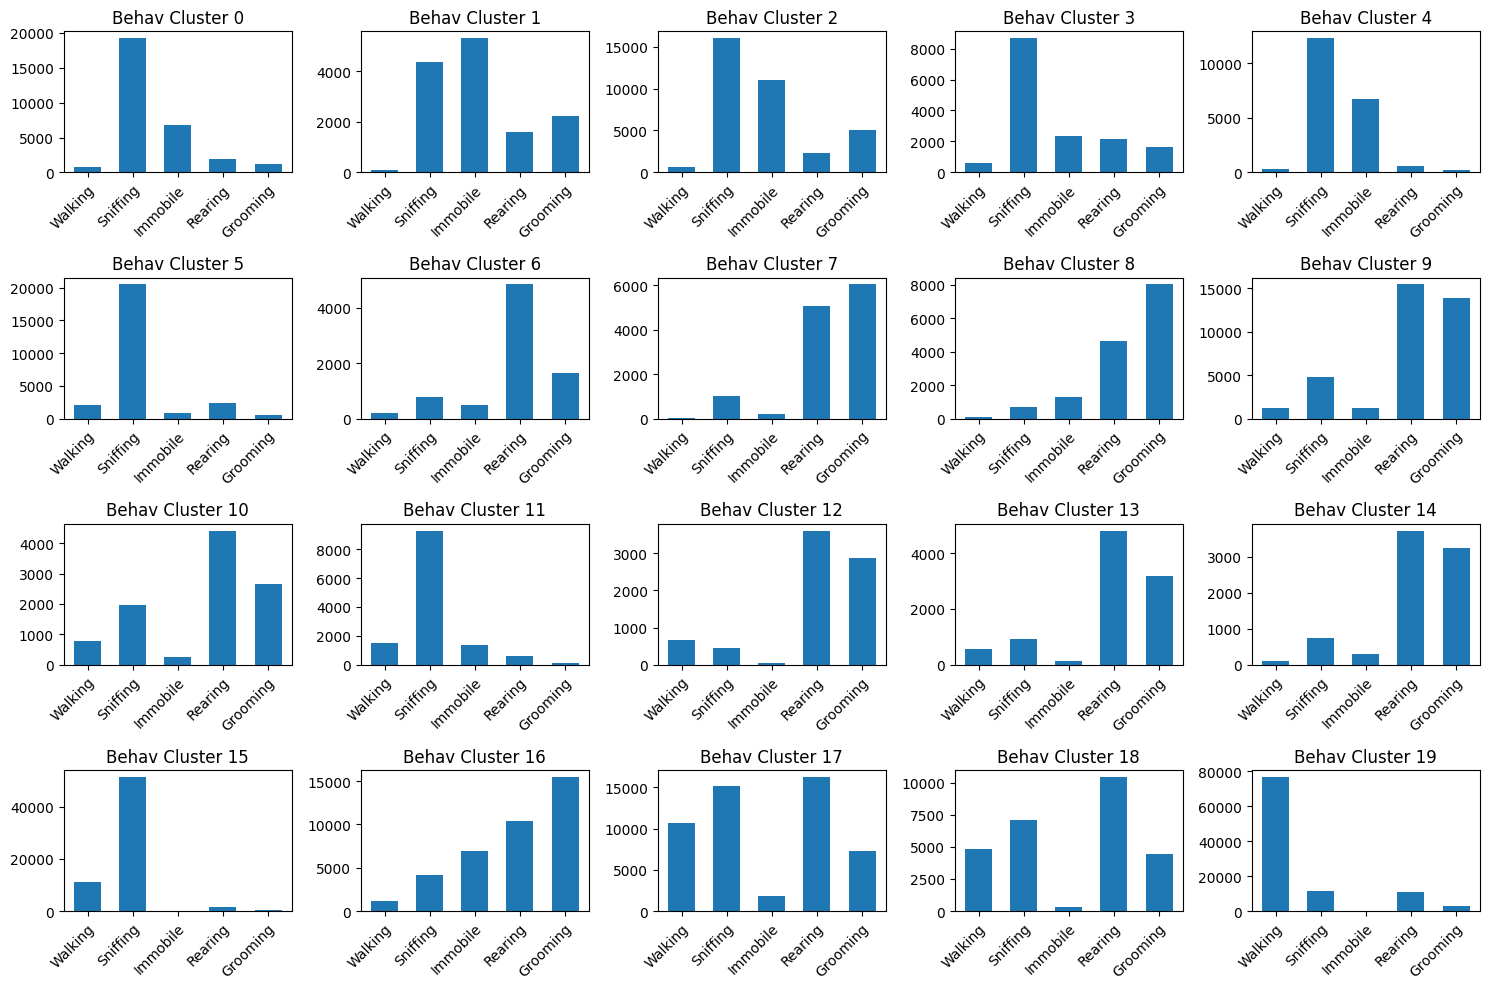

In [18]:
plt.figure(figsize = (10,10))
plt.suptitle("Correspondant ethogram for each behavioral cluster")
corr_ethogram = [[] for i in range(label_num)]
for i in range(8): ## PNOC
    for j in range(label_num):
        corr_ethogram[j].extend(PNOC_behavs[i][PNOC_bsoidlabels[i]==j])
    
for i in range(11): ## NTS
    for j in range(label_num):
        corr_ethogram[j].extend(NTS_behavs[i][NTS_bsoidlabels[i]==j])

plt.figure(figsize=(15,10))
for i in range(label_num):
    plt.subplot(4,5,i+1)
    plt.title(f"Behav Cluster {i}")
    bin_edges = np.arange(-0.5, behav_num, 1)
    plt.hist(corr_ethogram[i], bins = bin_edges,rwidth=0.6)
    plt.xticks(ticks=np.arange(0, behav_num), labels=Behav, rotation=45, ha='right', rotation_mode='anchor')

plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

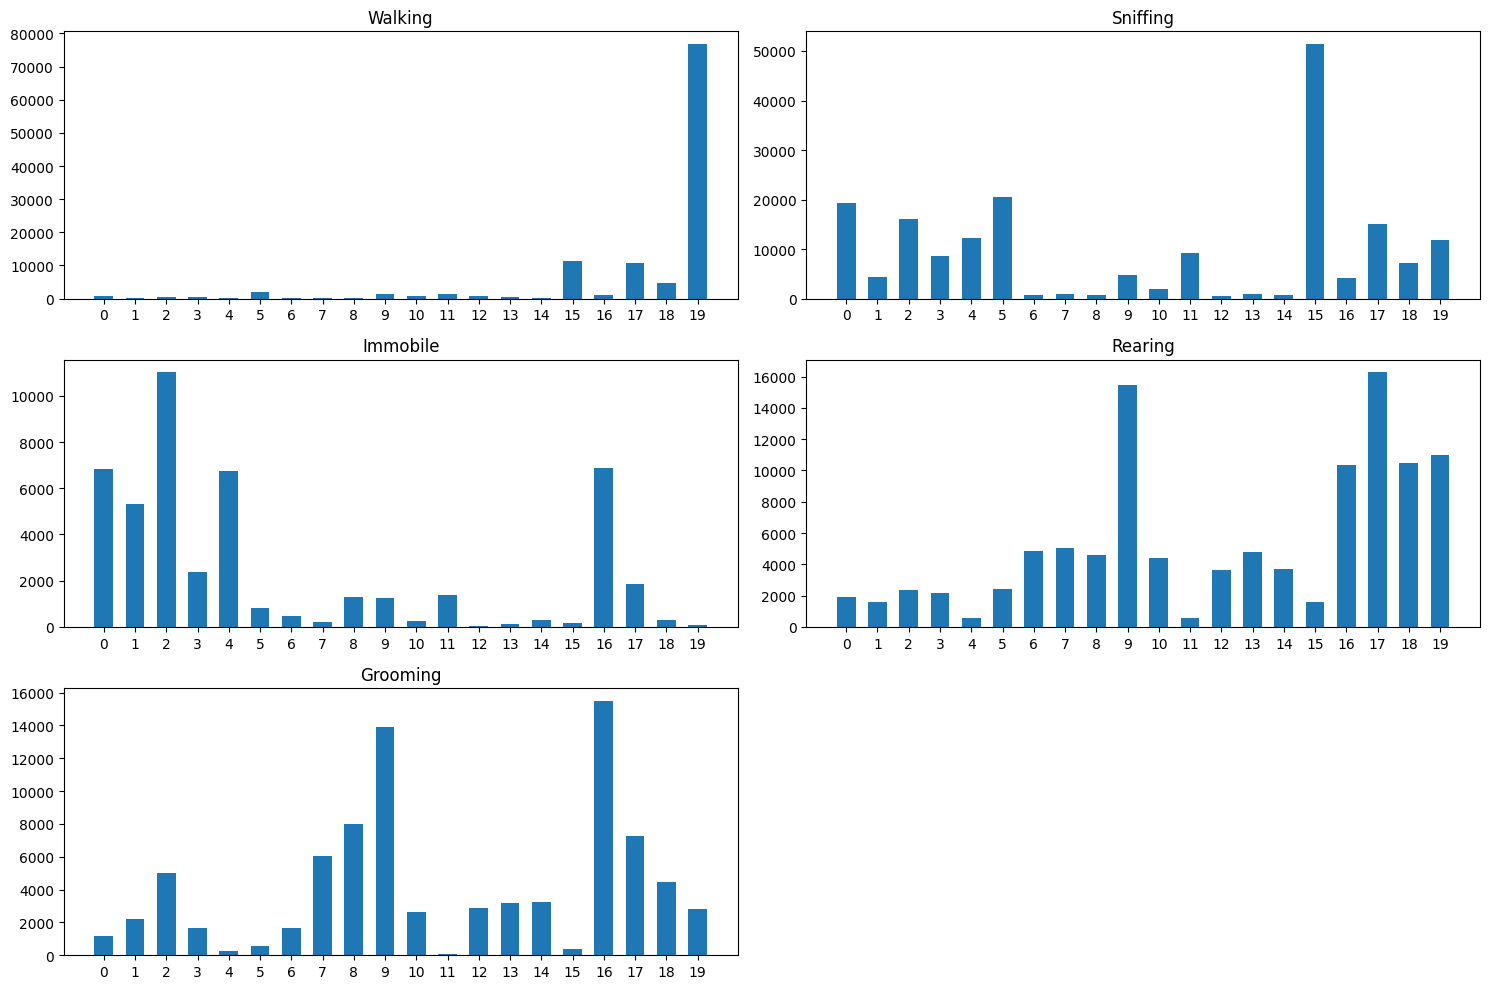

In [19]:
plt.figure(figsize = (8,6))
plt.suptitle("Correspondant ethogram for each behavioral cluster")
corr_ethogram = [[] for i in range(behav_num)]
for i in range(8): ## PNOC
    for j in range(behav_num):
        corr_ethogram[j].extend(PNOC_bsoidlabels[i][PNOC_behavs[i]==j])
    
for i in range(11): ## NTS
    for j in range(behav_num):
        corr_ethogram[j].extend(NTS_bsoidlabels[i][NTS_behavs[i]==j])

plt.figure(figsize=(15,10))
for i in range(behav_num):
    plt.subplot(3,2,i+1)
    plt.title(Behav[i])
    bin_edges = np.arange(-0.5, label_num, 1)
    plt.hist(corr_ethogram[i], bins = bin_edges,rwidth=0.6)
    plt.xticks(ticks=np.arange(0, label_num))

plt.tight_layout()
plt.show()

## Stimulation Effect on Behavioral Trend
* post-stimulation period still have effect of stimulation.
* Excluded the post-8sec period from stim-off period.

In [20]:
## return the normalized count of each behavioral counts.

def behav_dist(behav, stim, behav_num):
    # Behavior Distribution
    unique_behaviors, behavior_counts = np.unique(behav, return_counts=True)
    behavior_distribution = dict(zip(unique_behaviors, behavior_counts))
    
    switch_mask = np.zeros_like(stim, dtype=bool)
    for i in range(len(stim) - 1):
        if ~stim[i] and stim[i+1]: ## Detect the stim-of timing (False->True)
            switch_mask[max(i + 1, 0):min(i + 241, len(stim))] = True
            
    # Adjust stim to include only the relevant periods
    stim = np.where(switch_mask, False, stim)  # Set switch periods to False (switch post 8sec period as stim-on)
    
    # Initializing dictionaries to hold behavior counts during stimulation and no stimulation
    behavior_counts_stimulation = {i: 0 for i in range(behav_num)}
    behavior_counts_no_stimulation = {i: 0 for i in range(behav_num)}
    
    # Counting occurrences of each behavior during stimulation and no stimulation periods
    for behavior in range(behav_num):
        behavior_mask = behav == behavior
        stim_mask = (stim == False)  # Stim-on periods, excluding nans
        no_stim_mask = (stim == True)  # Stim-off periods, excluding nans
        
        # Count occurrences for each condition, normalized by the total counts, excluding nans
        behavior_counts_stimulation[behavior] = np.sum(behavior_mask & stim_mask) / np.sum(stim_mask) * 100
        behavior_counts_no_stimulation[behavior] = np.sum(behavior_mask & no_stim_mask) / np.sum(no_stim_mask) * 100
    
    return [behavior_counts_stimulation, behavior_counts_no_stimulation]

Walking TtestResult(statistic=0.9690133734208883, pvalue=0.34906891673528273, df=13.9252420428288)
Sniffing TtestResult(statistic=-0.6604504014388943, pvalue=0.5205147463820208, df=12.97924661971181)
Immobile TtestResult(statistic=-0.7547781113117491, pvalue=0.46399855184894634, df=12.843167743045809)
Rearing TtestResult(statistic=0.2966954997350387, pvalue=0.7714548683619549, df=12.810008886925221)
Grooming TtestResult(statistic=0.5284029981961478, pvalue=0.606376160432959, df=12.635887538065615)


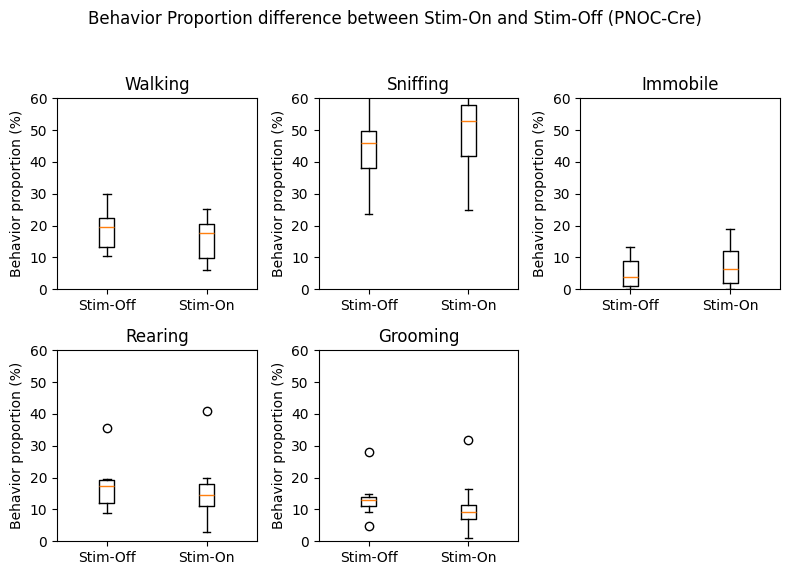

In [21]:
##################### A-SOiD #####################
## PNOC

behav_dist_stim = [behav_dist(PNOC_behavs[i], PNOC_stims[i], behav_num) for i in range(8)]

fig, axs = plt.subplots(2, 3, figsize=(8,6))
fig.suptitle('Behavior Proportion difference between Stim-On and Stim-Off (PNOC-Cre)')

stim_on_avgs = []
stim_off_avgs = []
for i, ax in enumerate(axs.flatten()):
    if i >= behav_num:
        continue 
    stim_on_avgs = [dist[0][i] for dist in behav_dist_stim]
    stim_off_avgs = [dist[1][i] for dist in behav_dist_stim]

    # ax.bar(['Stim-Off', 'Stim-On'],
    #        [np.mean(stim_off_avgs), np.mean(stim_on_avgs)],
    #        yerr = [SE(stim_off_avgs), SE(stim_on_avgs)])
    ax.boxplot([stim_off_avgs,stim_on_avgs],
               labels=['Stim-Off', 'Stim-On'])
    ax.set_title(Behav[i])
    ax.set_ylabel('Behavior proportion (%)')
    ax.set_ylim(0,60)

    #### T-test #######
    t_test_result = stats.ttest_ind(stim_off_avgs, stim_on_avgs, equal_var=False)  # Using Welch's t-test
    print(Behav[i], t_test_result)
fig.delaxes(axs[1, 2])   
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Walking TtestResult(statistic=1.3835534205538733, pvalue=0.18313384716221143, df=18.308362316556774)
Sniffing TtestResult(statistic=-0.27627845748188024, pvalue=0.785216539120111, df=19.667767781136995)
Immobile TtestResult(statistic=-0.26797179115103453, pvalue=0.7914890901678409, df=19.827007247329067)
Rearing TtestResult(statistic=-0.21939040576971022, pvalue=0.8285701187166696, df=19.994481400010343)
Grooming TtestResult(statistic=-0.676662472126738, pvalue=0.5081085655563795, df=16.301744365723792)


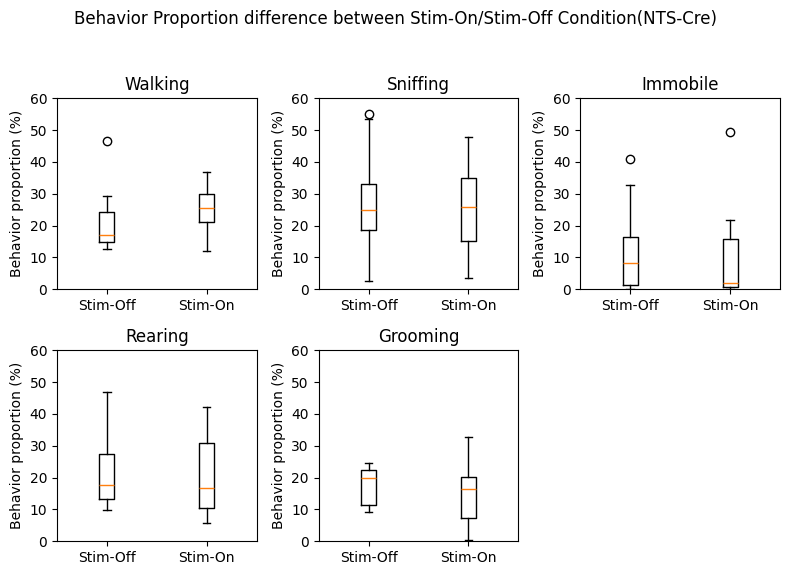

In [22]:
## NTS

behav_dist_stim = [behav_dist(NTS_behavs[i], NTS_stims[i], behav_num) for i in range(11)]

fig, axs = plt.subplots(2, 3, figsize=(8,6))
fig.suptitle('Behavior Proportion difference between Stim-On/Stim-Off Condition(NTS-Cre)')

stim_on_avgs = []
stim_off_avgs = []
for i, ax in enumerate(axs.flatten()):
    if i >= behav_num:
        continue 
    stim_on_avgs = [dist[0][i] for dist in behav_dist_stim]
    stim_off_avgs = [dist[1][i] for dist in behav_dist_stim]

    # Plotting
    # ax.bar(['Stim-Off', 'Stim-On'],
    #        [np.mean(stim_off_avgs), np.mean(stim_on_avgs)],
    #        yerr = [SE(stim_off_avgs), SE(stim_on_avgs)])
    ax.boxplot([stim_off_avgs,stim_on_avgs],
               labels=['Stim-Off', 'Stim-On']
               )
    ax.set_title(Behav[i])
    ax.set_ylabel('Behavior proportion (%)')
    ax.set_ylim(0,60)

    #### T-test #######
    t_test_result = stats.ttest_ind(stim_on_avgs, stim_off_avgs, equal_var=False)  # Using Welch's t-test
    print(Behav[i], t_test_result)
    
fig.delaxes(axs[1, 2])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Behav cluster 0 TtestResult(statistic=-0.20484874695426025, pvalue=0.8406618858513365, df=13.889391957661534)
Behav cluster 1 TtestResult(statistic=-0.9990765245168164, pvalue=0.338107615913113, df=11.620542085786537)
Behav cluster 2 TtestResult(statistic=-0.7557243173688086, pvalue=0.4662539277653224, df=10.61491148692802)
Behav cluster 3 TtestResult(statistic=0.1211917861586177, pvalue=0.9052644698162651, df=13.974673596326356)
Behav cluster 4 TtestResult(statistic=-0.2744217825247348, pvalue=0.7888804539650305, df=10.924390478676434)
Behav cluster 5 TtestResult(statistic=-0.7554821941541503, pvalue=0.4664926712910955, df=10.54964097142596)
Behav cluster 6 TtestResult(statistic=0.16907854094903352, pvalue=0.8698136921693616, df=8.236526349565846)
Behav cluster 7 TtestResult(statistic=1.6479361194508448, pvalue=0.12201674579287962, df=13.750680464277327)
Behav cluster 8 TtestResult(statistic=-0.49810336841432995, pvalue=0.63129880065461, df=8.327379317359263)
Behav cluster 9 TtestResu

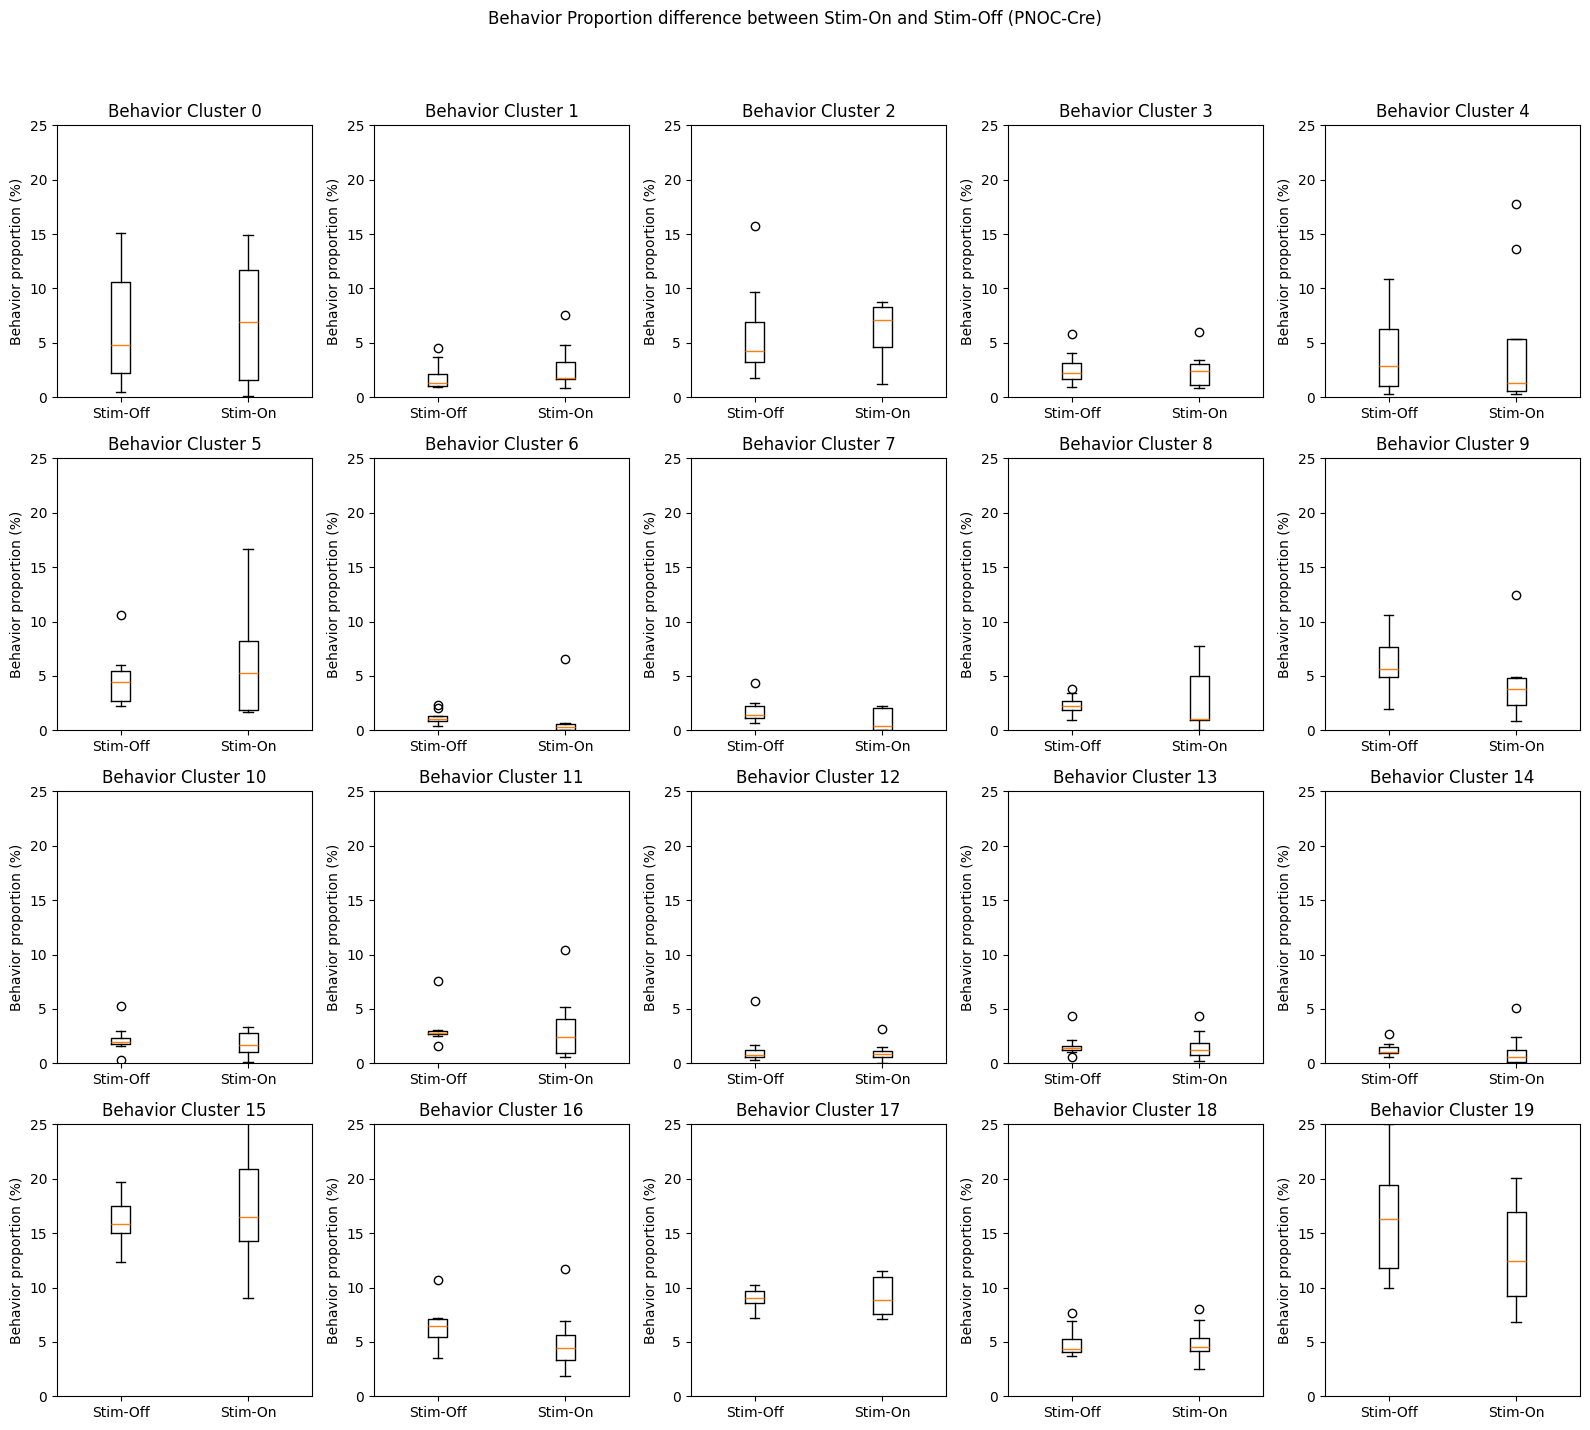

In [23]:
##################### B-SOiD #####################
## PNOC

behav_dist_stim_PNOC = [behav_dist(PNOC_bsoidlabels[i], PNOC_stims[i], label_num) for i in range(8)]

fig, axs = plt.subplots(4, 5, figsize=(16,15))
fig.suptitle('Behavior Proportion difference between Stim-On and Stim-Off (PNOC-Cre)')

stim_on_avgs_PNOC = []
stim_off_avgs_PNOC = []
for i, ax in enumerate(axs.flatten()):
    if i >= label_num:
        continue 
    stim_on_avgs_PNOC = [dist[0][i] for dist in behav_dist_stim_PNOC]
    stim_off_avgs_PNOC = [dist[1][i] for dist in behav_dist_stim_PNOC]

    # Plotting
    # ax.bar(['Stim-Off', 'Stim-On'],
    #        [np.mean(stim_off_avgs_PNOC), np.mean(stim_on_avgs_PNOC)],
    #        yerr = [SE(stim_off_avgs_PNOC), SE(stim_on_avgs_PNOC)])
    ax.boxplot([stim_off_avgs_PNOC, stim_on_avgs_PNOC],
               labels=['Stim-Off', 'Stim-On']
               )
    ax.set_title(f"Behavior Cluster {i}")
    ax.set_ylabel('Behavior proportion (%)')
    ax.set_ylim(0,25)

    #### T-test #######
    t_test_result = stats.ttest_ind(stim_off_avgs_PNOC, stim_on_avgs_PNOC, equal_var=False)  # Using Welch's t-test
    print(f"Behav cluster {i}", t_test_result) 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Behav cluster 0 TtestResult(statistic=0.5275006743029094, pvalue=0.6036740631783188, df=19.91416181779996)
Behav cluster 1 TtestResult(statistic=0.807594909244697, pvalue=0.43115670058400435, df=16.014184653755276)
Behav cluster 2 TtestResult(statistic=-0.7726329124723788, pvalue=0.45007526048573887, df=17.455984908701936)
Behav cluster 3 TtestResult(statistic=-0.4172933847629149, pvalue=0.6818032477917989, df=16.623987903070137)
Behav cluster 4 TtestResult(statistic=0.13010592056564618, pvalue=0.8977872992450577, df=19.92310457108242)
Behav cluster 5 TtestResult(statistic=0.9247218011751716, pvalue=0.3690767660397506, df=15.733812297538341)
Behav cluster 6 TtestResult(statistic=0.7461904375235606, pvalue=0.46424083961668183, df=19.983379692003695)
Behav cluster 7 TtestResult(statistic=-0.09180244729406023, pvalue=0.9279647299763605, df=16.43426189536609)
Behav cluster 8 TtestResult(statistic=2.1654222893199404, pvalue=0.04513431896060061, df=16.704109153475525)
Behav cluster 9 TtestRe

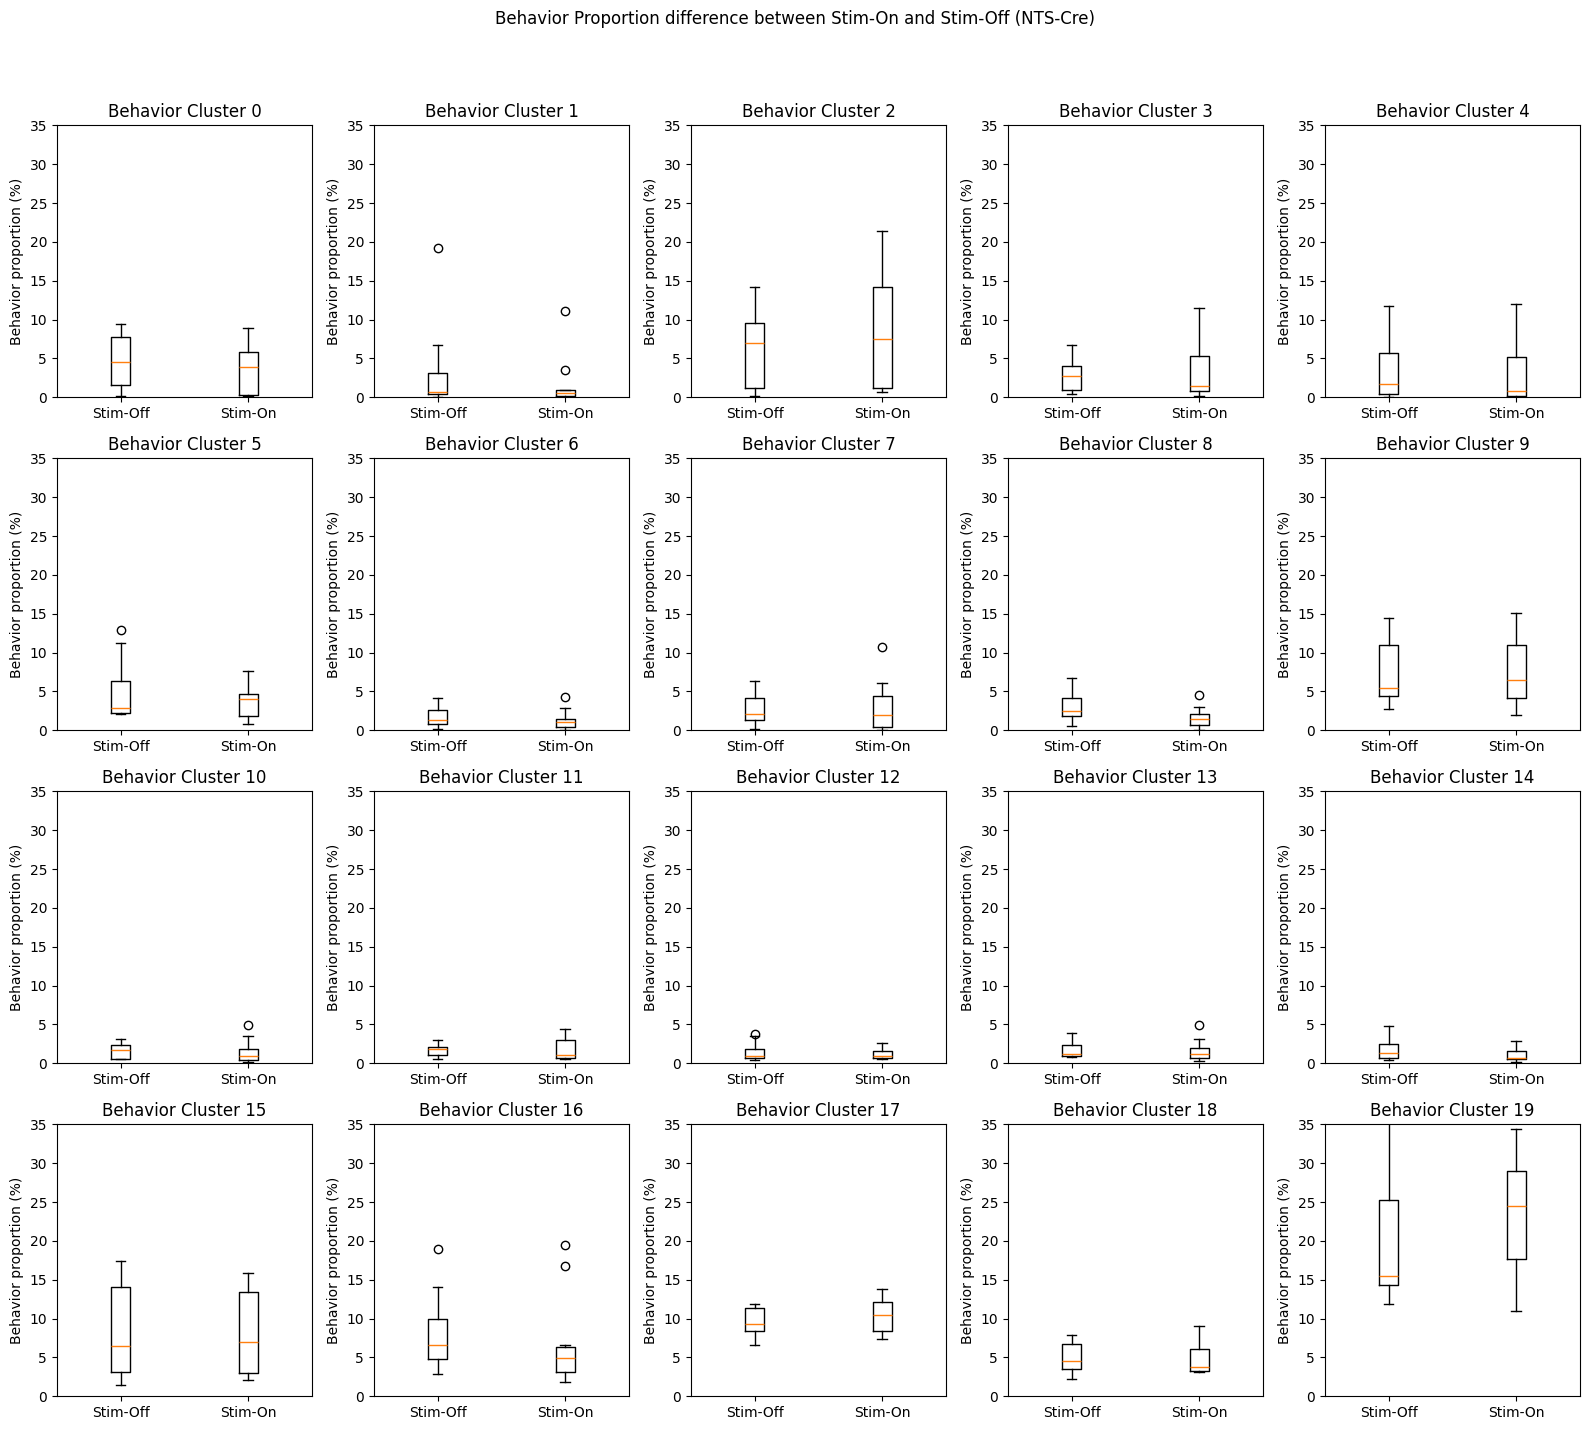

In [24]:
##################### B-SOiD #####################
## NTS

behav_dist_stim_NTS = [behav_dist(NTS_bsoidlabels[i], NTS_stims[i], label_num) for i in range(11)]

fig, axs = plt.subplots(4, 5, figsize=(16,15))
fig.suptitle('Behavior Proportion difference between Stim-On and Stim-Off (NTS-Cre)')

stim_on_avgs_NTS = []
stim_off_avgs_NTS = []
for i, ax in enumerate(axs.flatten()):
    if i >= label_num:
        continue 
    stim_on_avgs_NTS = [dist[0][i] for dist in behav_dist_stim_NTS]
    stim_off_avgs_NTS = [dist[1][i] for dist in behav_dist_stim_NTS]

    # ax.bar(['Stim-Off', 'Stim-On'],
    #        [np.mean(stim_off_avgs), np.mean(stim_on_avgs)],
    #        yerr = [SE(stim_off_avgs), SE(stim_on_avgs)])
    ax.boxplot([stim_off_avgs_NTS, stim_on_avgs_NTS],
               labels=['Stim-Off', 'Stim-On']
              )
    ax.set_title(f"Behavior Cluster {i}")
    ax.set_ylabel('Behavior proportion (%)')
    ax.set_ylim(0,35)

    #### T-test #######
    t_test_result = stats.ttest_ind(stim_off_avgs_NTS, stim_on_avgs_NTS, equal_var=False)  # Using Welch's t-test
    print(f"Behav cluster {i}", t_test_result) 
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/183045731.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(sorted_indices)
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/183045731.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(sorted_indices)
/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/183045731.py:71: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


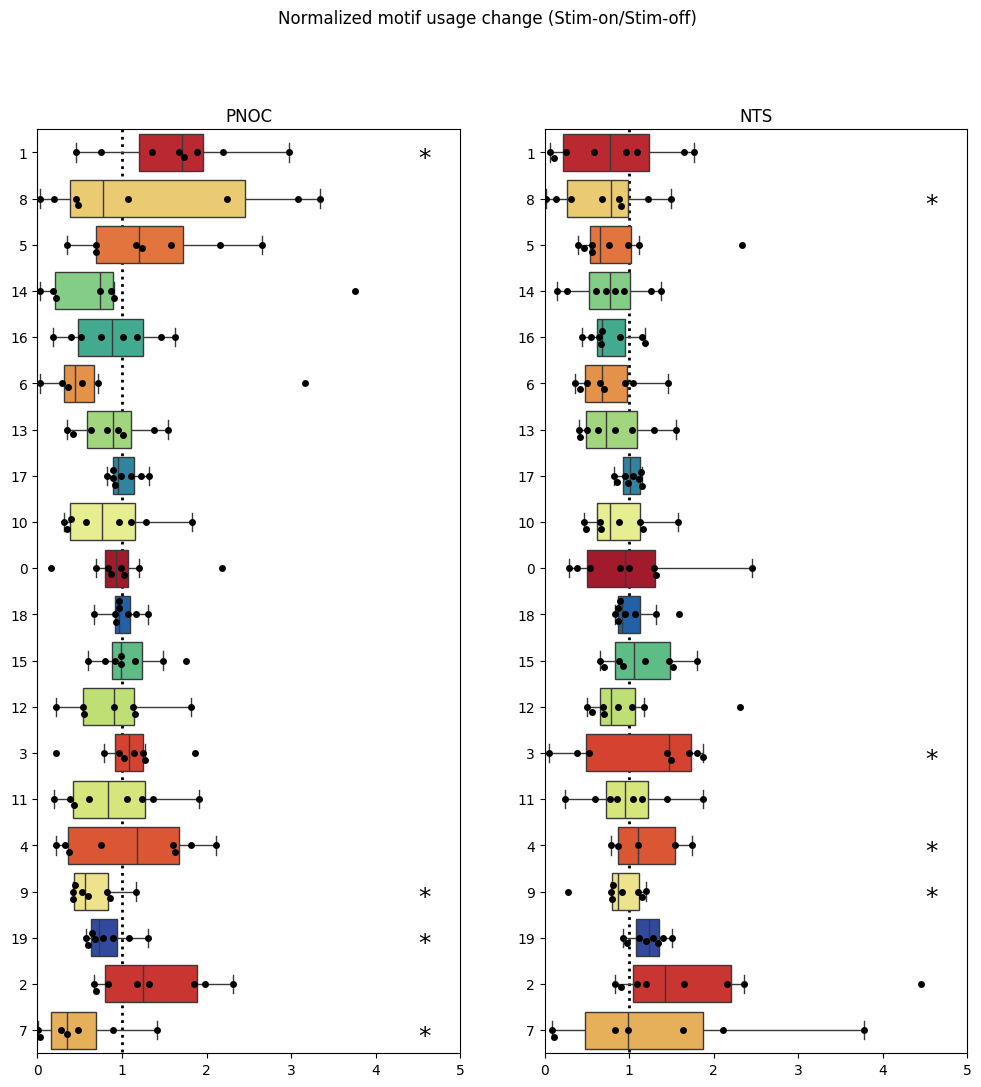

In [58]:
# ratio_PNOC = [[] for i in range(label_num)]
ratio_PNOC = [np.full(8, np.nan) for _ in range(label_num)]
for i in range(8):
    for j in range(label_num):
        stim_on = behav_dist_stim_PNOC[i][0][j]
        stim_off = behav_dist_stim_PNOC[i][1][j]
        if stim_on==0 or stim_off==0:
            continue
        else:
            ratio_PNOC[j][i] = stim_on/stim_off

# ratio_NTS = [[] for i in range(label_num)]
ratio_NTS = [np.full(11, np.nan) for _ in range(label_num)]
for i in range(8):
    for j in range(label_num):
        stim_on = behav_dist_stim_NTS[i][0][j]
        stim_off = behav_dist_stim_NTS[i][1][j]
        if stim_on==0 or stim_off==0:
            continue
        else:
            ratio_NTS[j][i] = stim_on/stim_off

ratio_PNOC = np.array(ratio_PNOC)
ratio_NTS = np.array(ratio_NTS)

medians_PNOC = np.nanmean(ratio_PNOC, axis=1)
medians_NTS = np.nanmean(ratio_NTS, axis=1)

medians_sub = medians_PNOC-medians_NTS

# quantile_PNOC = np.nanquantile(ratio_PNOC, 0.25, axis=1)
# quantile_NTS = np.nanquantile(ratio_NTS, 0.25, axis=1)
# quantile_sub = quantile_PNOC-quantile_NTS

sorted_indices = np.argsort(-medians_sub)
# sorted_indices = np.arange(20)
sorted_ratio_PNOC = ratio_PNOC[sorted_indices]
sorted_ratio_NTS = ratio_NTS[sorted_indices]

colors = sns.color_palette("Spectral", n_colors=20)
for i in range(20):
    max_color = max(colors[i][0], colors[i][1], colors[i][2])
    max_color2 = max(colors[i][0]**2, colors[i][1]**2, colors[i][2]**2)
    ratio = max_color/max_color2
    colors[i] = (colors[i][0]**2*ratio, colors[i][1]**2*ratio, colors[i][2]**2*ratio)
sorted_colors = [colors[i] for i in sorted_indices]

fig, ax = plt.subplots(1,2,figsize=(12,12))
fig.suptitle("Normalized motif usage change (Stim-on/Stim-off)")
positions = np.arange(sorted_ratio_PNOC.shape[0])

# ax[0].violinplot(ratio_PNOC, positions=positions, widths=0.5, vert=False)
ax[0].vlines(1, -0.5, 19.5, color="k", linewidth=2, linestyles="dotted")
sns.boxplot(sorted_ratio_PNOC.T, ax=ax[0], orient="h", fliersize=0, palette=sorted_colors)
sns.swarmplot(sorted_ratio_PNOC.T, ax=ax[0], orient="h", color="k")
ax[0].set_title("PNOC")
ax[0].set_xlim([0,5])
ax[0].set_yticklabels(sorted_indices)
for y1 in [0,16,17,19]: # 1,7,9,19
    ax[0].text(x=4.5, y=y1+0.28, s="*", fontsize=18)

ax[1].vlines(1, -0.5, 19.5, color="k", linewidth=2, linestyles="dotted")
sns.boxplot(sorted_ratio_NTS.T, ax=ax[1], orient="h", fliersize=0, palette=sorted_colors)
sns.swarmplot(sorted_ratio_NTS.T, ax=ax[1], orient="h", color="k")
ax[1].set_title("NTS")
ax[1].set_xlim([0,5])
ax[1].set_yticklabels(sorted_indices)
for y1 in [1,13,15,16]: # 2,8,14,19
    ax[1].text(x=4.5, y=y1+0.28, s="*", fontsize=18)

fig.show()
fig.savefig("figure1.svg", format="svg")

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]
[0.         0.         0.         0.         0.         0.04474273
 0.07220979 0.08762118 0.06823266 0.05878697 0.05418842 0.04710415
 0.0398956  0.03716132 0.03430276 0.03405419 0.03169277 0.02759135
 0.02560278 0.02448422 0.02361422 0.02261994 0.02224708 0.02050708
 0.01702709 0.01677852 0.01553567 0.01590853 0.0144171  0.01242854
 0.01217997 0.01230425 0.01168282 0.01068854 0.0101914  0.00956997
 0.00882426 0.00782998 0.00820283 0.00770569 0.00770569 0.00546856
 0.00497141 0.00671141 0.00434999]


/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/2751297966.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


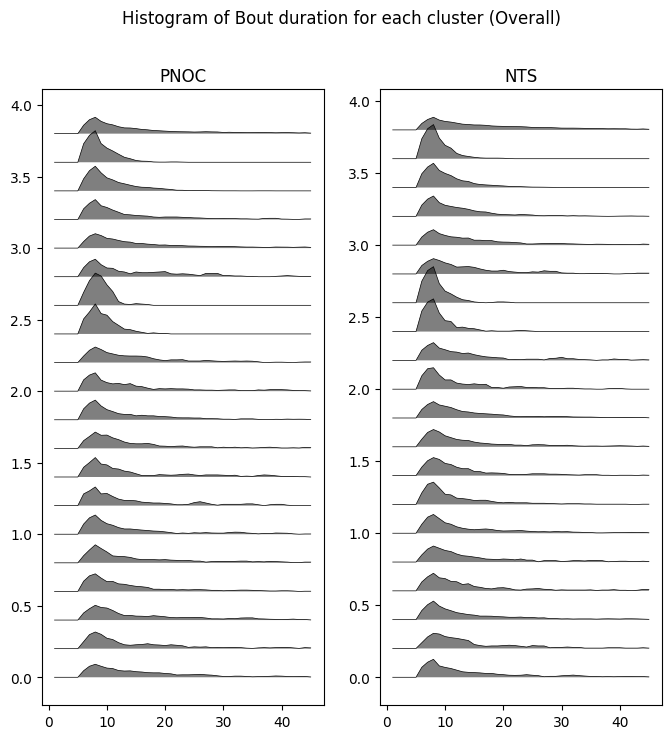

In [26]:
bsoidboutdists4eachcluster_PNOC = [[] for i in range(label_num)]
for i in range(8):
    bsoidbout_PNOC = pd.read_csv(PNOC_bsoidbout_files[i])
    for j in range(label_num):
        bouts = bsoidbout_PNOC["Run lengths"][bsoidbout_PNOC["B-SOiD labels"]==j]
        bouts = bouts[bouts>5]
        bsoidboutdists4eachcluster_PNOC[j].extend(bouts)

bsoidboutdists4eachcluster_NTS = [[] for i in range(label_num)]
for i in range(11):
    bsoidbout_NTS = pd.read_csv(NTS_bsoidbout_files[i])
    for j in range(label_num):
        bouts = bsoidbout_NTS["Run lengths"][bsoidbout_NTS["B-SOiD labels"]==j]
        bouts = bouts[bouts>5]
        bsoidboutdists4eachcluster_NTS[j].extend(bouts)

fig, ax = plt.subplots(1,2,figsize=(8,8))
fig.suptitle("Histogram of Bout duration for each cluster (Overall)")
window = np.ones(3)/3
maxlength = 45

for i in range(label_num):
    density, bins = np.histogram(bsoidboutdists4eachcluster_PNOC[i], bins=maxlength, range = (0,maxlength), density=True)
    density = np.convolve(density, window, mode="same")
    ax[0].plot(np.arange(1,maxlength+1), density+i*0.2, color="k",linewidth=0.5)
    ax[0].fill_between(np.arange(1,maxlength+1), i*0.2, density+i*0.2, facecolor='black', alpha=0.5)
    ax[0].set_title("PNOC")

for i in range(label_num):
    density, bins = np.histogram(bsoidboutdists4eachcluster_NTS[i], bins=maxlength, range = (0,maxlength), density=True)
    density = np.convolve(density, window, mode="same")
    ax[1].plot(np.arange(1,maxlength+1), density+i*0.2, color="k", linewidth=0.5)
    ax[1].fill_between(np.arange(1,maxlength+1), i*0.2, density+i*0.2, facecolor='black', alpha=0.5)
    ax[1].set_title("NTS")


print(bins)
print(density)
fig.show()

0.44224354004529853
0.2615943479787922


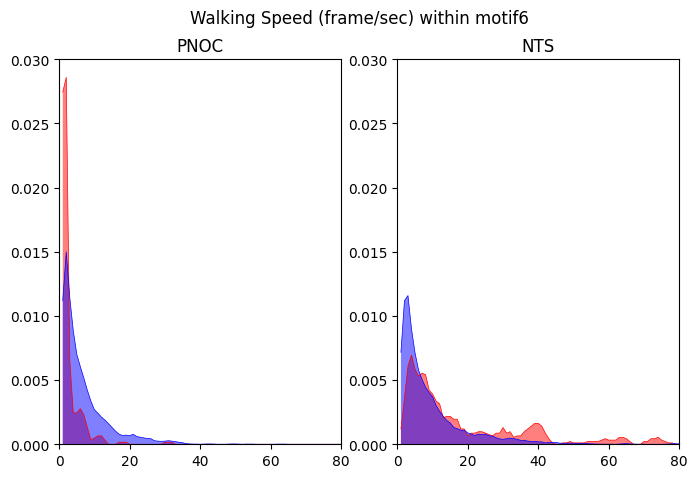

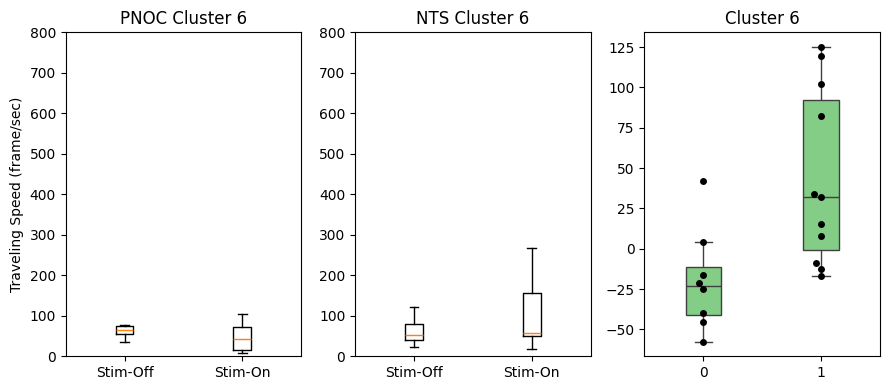

In [56]:
speeddists4eachcluster_PNOC_stimon = [[] for i in range(label_num)]
speeddists4eachcluster_PNOC_stimoff = [[] for i in range(label_num)]
speed_each_PNOC_stimon = [[] for i in range(label_num)]
speed_each_PNOC_stimoff = [[] for i in range(label_num)]
speed_sub_PNOC = [[] for i in range(label_num)]
for i in range(8):
    for j in range(label_num):
        speeds_on = PNOC_speed[i][(PNOC_bsoidlabels[i]==j) & (~PNOC_stims[i])]
        speeds_off = PNOC_speed[i][(PNOC_bsoidlabels[i]==j) & (PNOC_stims[i])]
        speeddists4eachcluster_PNOC_stimon[j].extend(speeds_on)
        speeddists4eachcluster_PNOC_stimoff[j].extend(speeds_off)
        if len(speeds_on)!=0:
            speed_each_PNOC_stimon[j].append(np.mean(speeds_on))
        if len(speeds_off)!=0:
            speed_each_PNOC_stimoff[j].append(np.mean(speeds_off))
        if len(speeds_on)!=0 and len(speeds_off)!=0:
            speed_sub_PNOC[j].append(np.mean(speeds_on)-np.mean(speeds_off))

speeddists4eachcluster_NTS_stimon = [[] for i in range(label_num)]
speeddists4eachcluster_NTS_stimoff = [[] for i in range(label_num)]
speed_each_NTS_stimon = [[] for i in range(label_num)]
speed_each_NTS_stimoff = [[] for i in range(label_num)]
speed_sub_NTS = [[] for i in range(label_num)]
for i in range(11):
    for j in range(label_num):
        speeds_on = NTS_speed[i][(NTS_bsoidlabels[i]==j) & (~NTS_stims[i])]
        speeds_off = NTS_speed[i][(NTS_bsoidlabels[i]==j) & (NTS_stims[i])]
        speeddists4eachcluster_NTS_stimon[j].extend(speeds_on)
        speeddists4eachcluster_NTS_stimoff[j].extend(speeds_off)
        if len(speeds_on)!=0:
            speed_each_NTS_stimon[j].append(np.mean(speeds_on))
        if len(speeds_off)!=0:
            speed_each_NTS_stimoff[j].append(np.mean(speeds_off))
        if len(speeds_on)!=0 and len(speeds_off)!=0:
            speed_sub_NTS[j].append(np.mean(speeds_on)-np.mean(speeds_off))


window = np.ones(3)/3
maxspeed = 120
diff = 0.1
for i in range(6,7):
    fig, ax = plt.subplots(1,2,figsize=(8,5))
    ## PNOC
    density, bins = np.histogram(speeddists4eachcluster_PNOC_stimon[i], bins=maxspeed, range = (0,maxspeed*10), density=True)
    density = np.convolve(density, window, mode="same")
    ax[0].plot(np.arange(1,maxspeed+1), density, color="red",linewidth=0.5)
    ax[0].fill_between(np.arange(1,maxspeed+1), 0, density, facecolor='red', alpha=0.5)
    
    density, bins = np.histogram(speeddists4eachcluster_PNOC_stimoff[i], bins=maxspeed, range = (0,maxspeed*10), density=True)
    density = np.convolve(density, window, mode="same")
    ax[0].plot(np.arange(1,maxspeed+1), density, color="blue",linewidth=0.5)
    ax[0].fill_between(np.arange(1,maxspeed+1), 0, density, facecolor='blue', alpha=0.5)
    
    ax[0].set_title("PNOC")
    ax[0].set_ylim(0,0.03)
    ax[0].set_xlim(0,80)
    ## NTS
    # i=19
    density, bins = np.histogram(speeddists4eachcluster_NTS_stimon[i], bins=maxspeed, range = (0,maxspeed*10), density=True)
    density = np.convolve(density, window, mode="same")
    ax[1].plot(np.arange(1,maxspeed+1), density, color="red",linewidth=0.5)
    ax[1].fill_between(np.arange(1,maxspeed+1), 0, density, facecolor='red', alpha=0.5)
    
    density, bins = np.histogram(speeddists4eachcluster_NTS_stimoff[i], bins=maxspeed, range = (0,maxspeed*10), density=True)
    density = np.convolve(density, window, mode="same")
    ax[1].plot(np.arange(1,maxspeed+1), density, color="blue",linewidth=0.5)
    ax[1].fill_between(np.arange(1,maxspeed+1), 0, density, facecolor='blue', alpha=0.5)
    ax[1].set_title("NTS")
    ax[1].set_ylim(0,0.03)
    ax[1].set_xlim(0,80)
    
    fig.suptitle(f"Walking Speed (frame/sec) within motif{i}")
    fig.savefig("figureD1.svg", format="svg")
    
    
    fig, ax = plt.subplots(1,3,figsize=(9,4))
    ax[0].boxplot([speed_each_PNOC_stimoff[i], speed_each_PNOC_stimon[i]],
                   labels=['Stim-Off', 'Stim-On'],
                    showfliers=False
                   )
    ax[0].set_ylabel('Traveling Speed (frame/sec)')
    ax[0].set_ylim(0,800)
    t_test_result = stats.ttest_ind(speed_each_PNOC_stimoff[i], speed_each_PNOC_stimon[i], equal_var=False)
    print(t_test_result.pvalue)
    ax[0].set_title(f"PNOC Cluster {i}")
    
    
    ax[1].boxplot([speed_each_NTS_stimoff[i], speed_each_NTS_stimon[i]],
                   labels=['Stim-Off', 'Stim-On'],
                    showfliers=False
                   )
    ax[1].set_ylim(0,800)
    t_test_result = stats.ttest_ind(speed_each_NTS_stimoff[i], speed_each_NTS_stimon[i], equal_var=False)
    print(t_test_result.pvalue)
    ax[1].set_title(f"NTS Cluster {i}")

    speed_sub_PNOC[i].extend([-40,-25])
    speed_sub_NTS[i].extend([125])
    
    sns.boxplot([speed_sub_PNOC[i], speed_sub_NTS[i]], ax=ax[2], orient="v", fliersize=0, width = 0.3,color = colors[14])
    sns.swarmplot([speed_sub_PNOC[i], speed_sub_NTS[i]], ax=ax[2], orient="v", color="k")
    ax[2].set_title(f"Cluster {i}")
    
    fig.tight_layout()
    fig.savefig("figureD2.svg", format="svg")

0.4032038244525512
0.021178377463573542


/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_84632/634327241.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


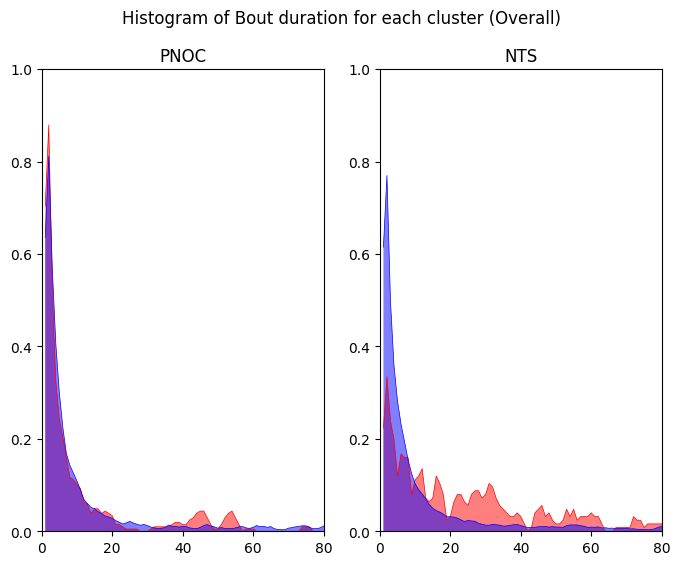

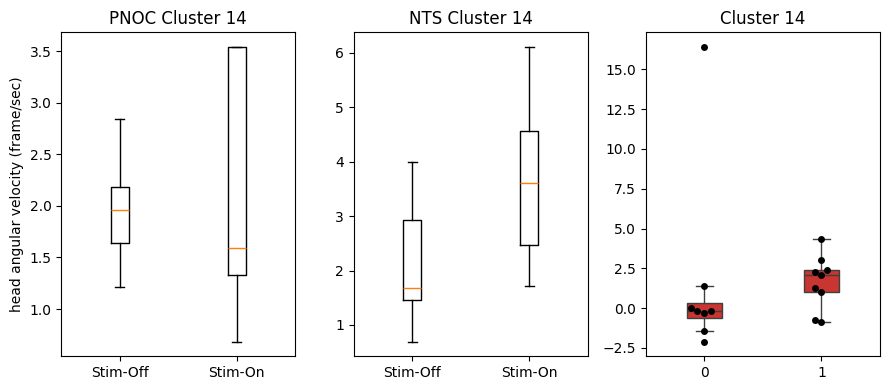

In [59]:
headdists4eachcluster_PNOC_stimon = [[] for i in range(label_num)]
headdists4eachcluster_PNOC_stimoff = [[] for i in range(label_num)]
head_each_PNOC_stimon = [[] for i in range(label_num)]
head_each_PNOC_stimoff = [[] for i in range(label_num)]
head_sub_PNOC = [[] for i in range(label_num)]
for i in range(8):
    for j in range(label_num):
        head_on = np.abs(PNOC_head_twist[i][(PNOC_bsoidlabels[i]==j) & (~PNOC_stims[i])])
        head_off = np.abs(PNOC_head_twist[i][(PNOC_bsoidlabels[i]==j) & (PNOC_stims[i])])
        headdists4eachcluster_PNOC_stimon[j].extend(head_on)
        headdists4eachcluster_PNOC_stimoff[j].extend(head_off)
        if len(head_on)!=0:
            head_each_PNOC_stimon[j].append(np.mean(head_on))
        if len(head_off)!=0:
            head_each_PNOC_stimoff[j].append(np.mean(head_off))
        if len(head_on)!=0 and len(head_off)!=0:
            head_sub_PNOC[j].append(np.mean(head_on)-np.mean(head_off))

headdists4eachcluster_NTS_stimon = [[] for i in range(label_num)]
headdists4eachcluster_NTS_stimoff = [[] for i in range(label_num)]
head_each_NTS_stimon = [[] for i in range(label_num)]
head_each_NTS_stimoff = [[] for i in range(label_num)]
head_sub_NTS = [[] for i in range(label_num)]
for i in range(11):
    for j in range(label_num):
        head_on = np.abs(NTS_head_twist[i][(NTS_bsoidlabels[i]==j) & (~NTS_stims[i])])
        head_off = np.abs(NTS_head_twist[i][(NTS_bsoidlabels[i]==j) & (NTS_stims[i])])
        headdists4eachcluster_NTS_stimon[j].extend(head_on)
        headdists4eachcluster_NTS_stimoff[j].extend(head_off)
        if len(head_on)!=0:
            head_each_NTS_stimon[j].append(np.mean(head_on))
        if len(head_off)!=0:
            head_each_NTS_stimoff[j].append(np.mean(head_off))
        if len(head_on)!=0 and len(head_off)!=0:
            head_sub_NTS[j].append(np.mean(head_on)-np.mean(head_off))

fig, ax = plt.subplots(1,2,figsize=(8,6))
fig.suptitle("Histogram of Bout duration for each cluster (Overall)")
window = np.ones(3)/3
maxspeed = 20
diff = 0.5

i=14
density, bins = np.histogram(headdists4eachcluster_PNOC_stimon[i], bins=maxspeed*5, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[0].plot(np.arange(1,maxspeed*5+1), density, color="red",linewidth=0.5)
ax[0].fill_between(np.arange(1,maxspeed*5+1), 0, density, facecolor='red', alpha=0.5)

density, bins = np.histogram(headdists4eachcluster_PNOC_stimoff[i], bins=maxspeed*5, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[0].plot(np.arange(1,maxspeed*5+1), density, color="blue",linewidth=0.5)
ax[0].fill_between(np.arange(1,maxspeed*5+1), 0, density, facecolor='blue', alpha=0.5)

ax[0].set_title("PNOC")
ax[0].set_ylim(0,1.0)
ax[0].set_xlim(0,80)

density, bins = np.histogram(headdists4eachcluster_NTS_stimon[i], bins=maxspeed*5, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[1].plot(np.arange(1,maxspeed*5+1), density, color="red",linewidth=0.5)
ax[1].fill_between(np.arange(1,maxspeed*5+1), 0, density, facecolor='red', alpha=0.5)

density, bins = np.histogram(headdists4eachcluster_NTS_stimoff[i], bins=maxspeed*5, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[1].plot(np.arange(1,maxspeed*5+1), density, color="blue",linewidth=0.5)
ax[1].fill_between(np.arange(1,maxspeed*5+1), 0, density, facecolor='blue', alpha=0.5)
ax[1].set_title("NTS")
ax[1].set_ylim(0,1.0)
ax[1].set_xlim(0,80)
fig.savefig("figureC1.svg", format="svg")



fig, ax = plt.subplots(1,3,figsize=(9,4))
ax[0].boxplot([head_each_PNOC_stimoff[i], head_each_PNOC_stimon[i]],
               labels=['Stim-Off', 'Stim-On'],
                showfliers=False
               )
ax[0].set_ylabel('head angular velocity (frame/sec)')
t_test_result = stats.ttest_ind(head_each_PNOC_stimoff[i], head_each_PNOC_stimon[i], equal_var=False)
print(t_test_result.pvalue)
ax[0].set_title(f"PNOC Cluster {i}")

ax[1].boxplot([head_each_NTS_stimoff[i], head_each_NTS_stimon[i]],
               labels=['Stim-Off', 'Stim-On'],
                showfliers=False
               )
t_test_result = stats.ttest_ind(head_each_NTS_stimoff[i], head_each_NTS_stimon[i], equal_var=False)
print(t_test_result.pvalue)
ax[1].set_title(f"NTS Cluster {i}")

head_sub_PNOC[i].extend([-0.2,0,-2.1])
sns.boxplot([head_sub_PNOC[i], head_sub_NTS[i]], ax=ax[2], orient="v", fliersize=0, width = 0.3,color = colors[2])
sns.swarmplot([head_sub_PNOC[i], head_sub_NTS[i]], ax=ax[2], orient="v", color="k")
ax[2].set_title(f"Cluster {i}")

fig.tight_layout()
fig.savefig("figureC2.svg", format="svg")
fig.show()

In [167]:
head_sub_PNOC[i].extend([-0.2,0,-2.1])
head_sub_PNOC[i]

[-0.1850722150549533,
 -0.3125733393824841,
 16.401356154969477,
 -1.465432341715974,
 1.395846940995423,
 [-0.2, 0, 1.1],
 [-0.2, 0, 1.1],
 [-0.2, 0, 1.1],
 -0.2,
 0,
 1.1]

0.5701292899768029
0.11731208549852283


/var/folders/z7/s77cy2p96jg2dp0synyyllsm0000gn/T/ipykernel_75627/3274385640.py:81: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


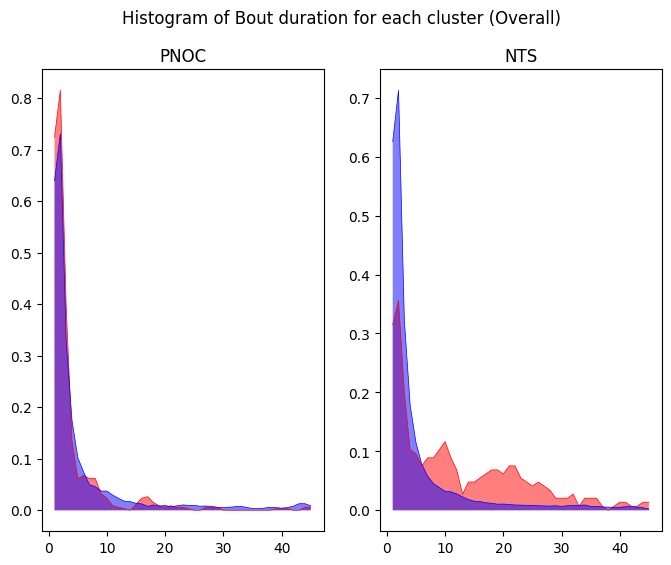

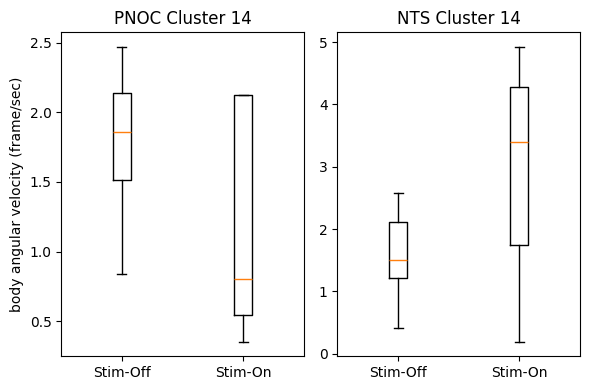

In [161]:
bodydists4eachcluster_PNOC_stimon = [[] for i in range(label_num)]
bodydists4eachcluster_PNOC_stimoff = [[] for i in range(label_num)]
body_each_PNOC_stimon = [[] for i in range(label_num)]
body_each_PNOC_stimoff = [[] for i in range(label_num)]
for i in range(8):
    for j in range(label_num):
        body_on = np.abs(PNOC_body_twist[i][(PNOC_bsoidlabels[i]==j) & (~PNOC_stims[i])])
        body_off = np.abs(PNOC_body_twist[i][(PNOC_bsoidlabels[i]==j) & (PNOC_stims[i])])
        bodydists4eachcluster_PNOC_stimon[j].extend(body_on)
        bodydists4eachcluster_PNOC_stimoff[j].extend(body_off)
        if len(body_on)!=0:
            body_each_PNOC_stimon[j].append(np.mean(body_on))
        if len(body_off)!=0:
            body_each_PNOC_stimoff[j].append(np.mean(body_off))

bodydists4eachcluster_NTS_stimon = [[] for i in range(label_num)]
bodydists4eachcluster_NTS_stimoff = [[] for i in range(label_num)]
body_each_NTS_stimon = [[] for i in range(label_num)]
body_each_NTS_stimoff = [[] for i in range(label_num)]
for i in range(8):
    for j in range(label_num):
        body_on = np.abs(NTS_body_twist[i][(NTS_bsoidlabels[i]==j) & (~NTS_stims[i])])
        body_off = np.abs(NTS_body_twist[i][(NTS_bsoidlabels[i]==j) & (NTS_stims[i])])
        bodydists4eachcluster_NTS_stimon[j].extend(body_on)
        bodydists4eachcluster_NTS_stimoff[j].extend(body_off)
        if len(body_on)!=0:
            body_each_NTS_stimon[j].append(np.mean(body_on))
        if len(body_off)!=0:
            body_each_NTS_stimoff[j].append(np.mean(body_off))

fig, ax = plt.subplots(1,2,figsize=(8,6))
fig.suptitle("Histogram of Bout duration for each cluster (Overall)")
window = np.ones(3)/3
maxspeed = 15
diff = 0.5

i=14
density, bins = np.histogram(bodydists4eachcluster_PNOC_stimon[i], bins=maxspeed*3, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[0].plot(np.arange(1,maxspeed*3+1), density, color="red",linewidth=0.5)
ax[0].fill_between(np.arange(1,maxspeed*3+1), 0, density, facecolor='red', alpha=0.5)

density, bins = np.histogram(bodydists4eachcluster_PNOC_stimoff[i], bins=maxspeed*3, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[0].plot(np.arange(1,maxspeed*3+1), density, color="blue",linewidth=0.5)
ax[0].fill_between(np.arange(1,maxspeed*3+1), 0, density, facecolor='blue', alpha=0.5)

ax[0].set_title("PNOC")

density, bins = np.histogram(bodydists4eachcluster_NTS_stimon[i], bins=maxspeed*3, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[1].plot(np.arange(1,maxspeed*3+1), density, color="red",linewidth=0.5)
ax[1].fill_between(np.arange(1,maxspeed*3+1), 0, density, facecolor='red', alpha=0.5)

density, bins = np.histogram(bodydists4eachcluster_NTS_stimoff[i], bins=maxspeed*3, range = (0,maxspeed), density=True)
density = np.convolve(density, window, mode="same")
ax[1].plot(np.arange(1,maxspeed*3+1), density, color="blue",linewidth=0.5)
ax[1].fill_between(np.arange(1,maxspeed*3+1), 0, density, facecolor='blue', alpha=0.5)
ax[1].set_title("NTS")
fig.savefig("figure2.png")

fig, ax = plt.subplots(1,2,figsize=(6,4))
ax[0].boxplot([body_each_PNOC_stimoff[i], body_each_PNOC_stimon[i]],
               labels=['Stim-Off', 'Stim-On'],
                showfliers=False
               )
ax[0].set_ylabel('body angular velocity (frame/sec)')
t_test_result = stats.ttest_ind(body_each_PNOC_stimoff[i], body_each_PNOC_stimon[i], equal_var=False)
print(t_test_result.pvalue)
ax[0].set_title(f"PNOC Cluster {i}")

ax[1].boxplot([body_each_NTS_stimoff[i], body_each_NTS_stimon[i]],
               labels=['Stim-Off', 'Stim-On'],
                showfliers=False
               )
t_test_result = stats.ttest_ind(body_each_NTS_stimoff[i], body_each_NTS_stimon[i], equal_var=False)
print(t_test_result.pvalue)
ax[1].set_title(f"NTS Cluster {i}")

fig.tight_layout()
fig.show()

### Behavioral Frequency within each 8sec window from 8 sec before the stim-onset to 40 sec after the stim-offset.
* Window: Pre-stim(-8–0), During stim(0–8), Post-stim 1(8–16), Post-stim 2(16–24), Post-stim 3(24–32), Post-stim 4(32–40), Post-stim 5(40–48).

In [ ]:
#### Each mouse pre and post stimulation change of behavior

def find_stimulation_start_events(stim_array):
    # Identifying True to False transitions as the start of stimulation events
    transitions = np.where(np.diff(stim_array.astype(int)) == -1)[0] + 1
    return transitions

def analyze_behavior_around_stimulation(behav_array, stim_array, behav_num, window=240):
    change_points = find_stimulation_start_events(stim_array)
    behavior_changes = {i: [] for i in range(behav_num)}  # Initialize dictionary to hold changes for each behavior

    for point in change_points:
        # Define windows around the stimulation point
        pre_window = behav_array[max(0, point-window):point]
        during_window = behav_array[point:min(len(behav_array), point+window)]
        post1_window = behav_array[min(len(behav_array), point+window): min(len(behav_array), point+2*window)]
        post2_window = behav_array[min(len(behav_array), point+2*window): min(len(behav_array), point+3*window)]
        post3_window = behav_array[min(len(behav_array), point+3*window): min(len(behav_array), point+4*window)]
        post4_window = behav_array[min(len(behav_array), point+4*window): min(len(behav_array), point+5*window)]
        post5_window = behav_array[min(len(behav_array), point+5*window): min(len(behav_array), point+6*window)]
        # Count occurrences of each behavior in the pre and post windows
        for behavior in range(behav_num):
            pre_count = np.sum(pre_window == behavior)
            during_count = np.sum(during_window == behavior)
            post1_count = np.sum(post1_window == behavior)
            post2_count = np.sum(post2_window == behavior)
            post3_count = np.sum(post3_window == behavior)
            post4_count = np.sum(post4_window == behavior)
            post5_count = np.sum(post5_window == behavior)
            behavior_changes[behavior].append((pre_count, during_count, post1_count, post2_count, post3_count, post4_count, post5_count))
    
    return behavior_changes

In [ ]:
# Analyze behavior changes
# window_size = 240  # Define the size of the window before and after stimulation events
# behavior_changes_around_stim = analyze_behavior_around_stimulation(PNOC_mouse3_behav, PNOC_mouse3_stim, window=window_size)

# # Visualization
# fig, axs = plt.subplots(5, 1, figsize=(9, 15))
# fig.suptitle('Behavioral frequency Changes Around Stimulation Events (PNOC_mouse3)')

# for i, ax in enumerate(axs.flatten()):
#     pre_counts = [change[0] for change in behavior_changes_around_stim[i]]
#     during_counts = [change[1] for change in behavior_changes_around_stim[i]]
#     post1_counts = [change[2] for change in behavior_changes_around_stim[i]]
    
#     # Plotting
#     ax.plot(pre_counts, label='Pre-Stimulation')
#     ax.plot(during_counts, label='During-Stimulation')
#     ax.plot(post_counts, label='Post1-Stimulation')
#     ax.set_title(Behav[i])
#     ax.legend()
#     ax.set_xlabel('Time around Stimulation Onset (Stim-onset=10)')
#     ax.set_ylabel('Behavior Count')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [ ]:
######################### A-SOiD ##########################

# Analyze behavior changes for each mouse
window_size = 240
behavior_changes_mice = [analyze_behavior_around_stimulation(PNOC_behavs[i], PNOC_stims[i], behav_num, window=window_size) for i in range(8)]
    
# Calculate averages across mice
average_behavior_changes = {i: [] for i in range(behav_num)}
for behavior in range(behav_num):
    for mouse_changes in behavior_changes_mice:
        pre_avgs = np.mean([change[0] for change in mouse_changes[behavior]])
        during_avgs = np.mean([change[1] for change in mouse_changes[behavior]])
        post1_avgs = np.mean([change[2] for change in mouse_changes[behavior]])
        post2_avgs = np.mean([change[3] for change in mouse_changes[behavior]])
        post3_avgs = np.mean([change[4] for change in mouse_changes[behavior]])
        post4_avgs = np.mean([change[5] for change in mouse_changes[behavior]])
        post5_avgs = np.mean([change[6] for change in mouse_changes[behavior]])
        average_behavior_changes[behavior].append((pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs))

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(12,10))
fig.suptitle('Behavioral Changes Around Stimulation Across Mice (PNOC-Cre)')

for i, ax in enumerate(axs.flatten()):
    if i >= behav_num:
        continue
    pre_avgs = [change[0] for change in average_behavior_changes[i]]
    during_avgs = [change[1] for change in average_behavior_changes[i]]
    post1_avgs = [change[2] for change in average_behavior_changes[i]]
    post2_avgs = [change[3] for change in average_behavior_changes[i]]
    post3_avgs = [change[4] for change in average_behavior_changes[i]]
    post4_avgs = [change[5] for change in average_behavior_changes[i]]
    post5_avgs = [change[6] for change in average_behavior_changes[i]]
    
    # Plotting
    ax.bar(['Pre', 'During', 'Post1', 'Post2', 'Post3', 'Post4', 'Post5'],
           [np.mean(pre_avgs), np.mean(during_avgs), np.mean(post1_avgs), np.mean(post2_avgs), np.mean(post3_avgs), np.mean(post4_avgs), np.mean(post5_avgs)],
           yerr = [SE(pre_avgs), SE(during_avgs), SE(post1_avgs), SE(post2_avgs), SE(post3_avgs), SE(post4_avgs), SE(post5_avgs)]
          )
    ax.set_title(Behav[i])
    ax.set_ylabel('Frames in 8sec', fontsize=12)
    # ax.set_ylim(0,100)
    
    ######### Multiple comparison################
    # ANOVA
    _, p = f_oneway(pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs)
    
    # Post-hoc multiple comparisons
    groups = np.array(['Pre']*len(pre_avgs) + ['During']*len(during_avgs) + ['Post1']*len(post1_avgs)+ ['Post2']*len(post2_avgs)+ ['Post3']*len(post3_avgs)+ ['Post4']*len(post4_avgs)+ ['Post5']*len(post5_avgs))
    mc = MultiComparison(np.concatenate([pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs]), groups)
    result = mc.tukeyhsd()

    print(Behav[i])
    print("ANOVA: P-Value", p)
    # print(result.summary())

    t_test_result = stats.ttest_ind(pre_avgs, during_avgs, equal_var=False)  # Using Welch's t-test
    print("t-test:", t_test_result)
    
    #############################################

fig.delaxes(axs[2, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Analyze behavior changes for each mouse
window_size = 240
behavior_changes_mice = [analyze_behavior_around_stimulation(NTS_behavs[i], NTS_stims[i], behav_num, window=window_size) for i in range(11)]
    
# Calculate averages across mice
average_behavior_changes = {i: [] for i in range(behav_num)}
for behavior in range(behav_num):
    for mouse_changes in behavior_changes_mice:
        pre_avgs = np.mean([change[0] for change in mouse_changes[behavior]])
        during_avgs = np.mean([change[1] for change in mouse_changes[behavior]])
        post1_avgs = np.mean([change[2] for change in mouse_changes[behavior]])
        post2_avgs = np.mean([change[3] for change in mouse_changes[behavior]])
        post3_avgs = np.mean([change[4] for change in mouse_changes[behavior]])
        post4_avgs = np.mean([change[5] for change in mouse_changes[behavior]])
        post5_avgs = np.mean([change[6] for change in mouse_changes[behavior]])
        average_behavior_changes[behavior].append((pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs))

# Visualization
fig, axs = plt.subplots(3, 2, figsize=(12,10))
fig.suptitle('Behavioral Changes Around Stimulation Across Mice (NTS-Cre)')

for i, ax in enumerate(axs.flatten()):
    if i >= behav_num:
        continue
    pre_avgs = [change[0] for change in average_behavior_changes[i]]
    during_avgs = [change[1] for change in average_behavior_changes[i]]
    post1_avgs = [change[2] for change in average_behavior_changes[i]]
    post2_avgs = [change[3] for change in average_behavior_changes[i]]
    post3_avgs = [change[4] for change in average_behavior_changes[i]]
    post4_avgs = [change[5] for change in average_behavior_changes[i]]
    post5_avgs = [change[6] for change in average_behavior_changes[i]]
    
    # Plotting
    ax.bar(['Pre', 'During', 'Post1', 'Post2', 'Post3', 'Post4', 'Post5'],
           [np.mean(pre_avgs), np.mean(during_avgs), np.mean(post1_avgs), np.mean(post2_avgs), np.mean(post3_avgs), np.mean(post4_avgs), np.mean(post5_avgs)],
           yerr = [SE(pre_avgs), SE(during_avgs), SE(post1_avgs), SE(post2_avgs), SE(post3_avgs), SE(post4_avgs), SE(post5_avgs)])
    ax.set_title(Behav[i])
    ax.set_ylabel('Frames in 8sec', fontsize=12)
    ax.set_ylim(0,120)
    
    ######### Multiple comparison################
    # ANOVA
    _, p = f_oneway(pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs)
    
    # Post-hoc multiple comparisons
    groups = np.array(['Pre']*len(pre_avgs) + ['During']*len(during_avgs) + ['Post1']*len(post1_avgs)+ ['Post2']*len(post2_avgs)+ ['Post3']*len(post3_avgs)+ ['Post4']*len(post4_avgs)+ ['Post5']*len(post5_avgs))
    mc = MultiComparison(np.concatenate([pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs]), groups)
    result = mc.tukeyhsd()

    print(Behav[i])
    print("ANOVA: P-Value", p)
    # print(result.summary())

    t_test_result = stats.ttest_ind(pre_avgs, during_avgs, equal_var=False)  # Using Welch's t-test
    print("t-test:", t_test_result)
    
    #############################################

fig.delaxes(axs[2, 1])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
######################### B-SOiD ##########################

# Analyze behavior changes for each mouse
window_size = 240
behavior_changes_mice = [analyze_behavior_around_stimulation(PNOC_bsoidlabels[i], PNOC_stims[i], label_num, window=window_size) for i in range(8)]
    
# Calculate averages across mice
average_behavior_changes = {i: [] for i in range(label_num)}
for behavior in range(label_num):
    for mouse_changes in behavior_changes_mice:
        pre_avgs = np.mean([change[0] for change in mouse_changes[behavior]])
        during_avgs = np.mean([change[1] for change in mouse_changes[behavior]])
        post1_avgs = np.mean([change[2] for change in mouse_changes[behavior]])
        post2_avgs = np.mean([change[3] for change in mouse_changes[behavior]])
        post3_avgs = np.mean([change[4] for change in mouse_changes[behavior]])
        post4_avgs = np.mean([change[5] for change in mouse_changes[behavior]])
        post5_avgs = np.mean([change[6] for change in mouse_changes[behavior]])
        average_behavior_changes[behavior].append((pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs))

# Visualization
fig, axs = plt.subplots(10, 2, figsize=(12, 28))
fig.suptitle('Behavioral Changes Around Stimulation Across Mice (PNOC-Cre)')

for i, ax in enumerate(axs.flatten()):
    if i >= label_num:
        continue
    pre_avgs = [change[0] for change in average_behavior_changes[i]]
    during_avgs = [change[1] for change in average_behavior_changes[i]]
    post1_avgs = [change[2] for change in average_behavior_changes[i]]
    post2_avgs = [change[3] for change in average_behavior_changes[i]]
    post3_avgs = [change[4] for change in average_behavior_changes[i]]
    post4_avgs = [change[5] for change in average_behavior_changes[i]]
    post5_avgs = [change[6] for change in average_behavior_changes[i]]
    
    # Plotting
    ax.bar(['Pre', 'During', 'Post1', 'Post2', 'Post3', 'Post4', 'Post5'],
           [np.mean(pre_avgs), np.mean(during_avgs), np.mean(post1_avgs), np.mean(post2_avgs), np.mean(post3_avgs), np.mean(post4_avgs), np.mean(post5_avgs)],
           yerr = [SE(pre_avgs), SE(during_avgs), SE(post1_avgs), SE(post2_avgs), SE(post3_avgs), SE(post4_avgs), SE(post5_avgs)])
    ax.set_title(f"Behav Cluster {i}")
    ax.set_ylabel('Frames in 8sec')
    # ax.set_ylim(0,100)
    
    ######### Multiple comparison################
    # ANOVA
    _, p = f_oneway(pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs)
    
    # Post-hoc multiple comparisons
    groups = np.array(['Pre']*len(pre_avgs) + ['During']*len(during_avgs) + ['Post1']*len(post1_avgs)+ ['Post2']*len(post2_avgs)+ ['Post3']*len(post3_avgs)+ ['Post4']*len(post4_avgs)+ ['Post5']*len(post5_avgs))
    mc = MultiComparison(np.concatenate([pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs]), groups)
    result = mc.tukeyhsd()

    print(f"Behav cluster {i}")
    print("ANOVA: P-Value", p)
    # print(result.summary())

    t_test_result = stats.ttest_ind(pre_avgs, during_avgs, equal_var=False)  # Using Welch's t-test
    print("t-test:", t_test_result)
    
    #############################################

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
######################### B-SOiD ##########################

# Analyze behavior changes for each mouse
window_size = 240
behavior_changes_mice = [analyze_behavior_around_stimulation(NTS_bsoidlabels[i], NTS_stims[i], label_num, window=window_size) for i in range(8)]
    
# Calculate averages across mice
average_behavior_changes = {i: [] for i in range(label_num)}
for behavior in range(label_num):
    for mouse_changes in behavior_changes_mice:
        pre_avgs = np.mean([change[0] for change in mouse_changes[behavior]])
        during_avgs = np.mean([change[1] for change in mouse_changes[behavior]])
        post1_avgs = np.mean([change[2] for change in mouse_changes[behavior]])
        post2_avgs = np.mean([change[3] for change in mouse_changes[behavior]])
        post3_avgs = np.mean([change[4] for change in mouse_changes[behavior]])
        post4_avgs = np.mean([change[5] for change in mouse_changes[behavior]])
        post5_avgs = np.mean([change[6] for change in mouse_changes[behavior]])
        average_behavior_changes[behavior].append((pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs))

# Visualization
fig, axs = plt.subplots(10, 2, figsize=(12, 28))
fig.suptitle('Behavioral Changes Around Stimulation Across Mice (NTS-Cre)')

for i, ax in enumerate(axs.flatten()):
    if i >= label_num:
        continue
    pre_avgs = [change[0] for change in average_behavior_changes[i]]
    during_avgs = [change[1] for change in average_behavior_changes[i]]
    post1_avgs = [change[2] for change in average_behavior_changes[i]]
    post2_avgs = [change[3] for change in average_behavior_changes[i]]
    post3_avgs = [change[4] for change in average_behavior_changes[i]]
    post4_avgs = [change[5] for change in average_behavior_changes[i]]
    post5_avgs = [change[6] for change in average_behavior_changes[i]]
    
    # Plotting
    ax.bar(['Pre', 'During', 'Post1', 'Post2', 'Post3', 'Post4', 'Post5'],
           [np.mean(pre_avgs), np.mean(during_avgs), np.mean(post1_avgs), np.mean(post2_avgs), np.mean(post3_avgs), np.mean(post4_avgs), np.mean(post5_avgs)],
           yerr = [SE(pre_avgs), SE(during_avgs), SE(post1_avgs), SE(post2_avgs), SE(post3_avgs), SE(post4_avgs), SE(post5_avgs)])
    ax.set_title(f"Behav Cluster {i}")
    ax.set_ylabel('Frames in 8sec')
    # ax.set_ylim(0,100)
    
    ######### Multiple comparison################
    # ANOVA
    _, p = f_oneway(pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs)
    
    # Post-hoc multiple comparisons
    groups = np.array(['Pre']*len(pre_avgs) + ['During']*len(during_avgs) + ['Post1']*len(post1_avgs)+ ['Post2']*len(post2_avgs)+ ['Post3']*len(post3_avgs)+ ['Post4']*len(post4_avgs)+ ['Post5']*len(post5_avgs))
    mc = MultiComparison(np.concatenate([pre_avgs, during_avgs, post1_avgs, post2_avgs, post3_avgs, post4_avgs, post5_avgs]), groups)
    result = mc.tukeyhsd()

    print(f"Behav cluster {i}")
    print("ANOVA: P-Value", p)
    # print(result.summary())

    t_test_result = stats.ttest_ind(pre_avgs, during_avgs, equal_var=False)  # Using Welch's t-test
    print("t-test:", t_test_result)
    
    #############################################

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Stimulation effect on bout duration of each behavior

In [ ]:
def calculate_bout_durations(behav_data, stim_data):
    # Dictionary to store bout durations for each behavior label under on and off stimulation
    bout_durations = {label: {'on': [], 'off': []} for label in range(behav_num)}  # Assuming labels 0-4
    bout_durations_norm = {label: {'on': [], 'off': []} for label in range(behav_num)}

    
    # Create a mask for periods to exclude: 240 frames after stimulation ends
    switch_mask = np.zeros_like(stim_data, dtype=bool)
    for i in range(len(stim_data) - 1):
        if ~stim_data[i] and stim_data[i+1]:
            switch_mask[max(i + 1, 0):min(i + 241, len(stim_data))] = True
    stim_data = np.where(switch_mask, False, stim_data)
    
    for label in range(behav_num):
        label_indices = np.where(behav_data == label)[0]
        label_stim = stim_data[label_indices]
        if len(label_indices) == 0: continue  # Skip if no occurrences of this behavior
        
        # Find changes in behavior and stimulation states
        changes = np.diff(label_indices, prepend=label_indices[0]-1) > 1
        stim_changes = np.diff(label_stim, prepend=label_stim[0]) != 0
        bout_changes = changes
        
        # Calculate bout durations
        bout_ends = np.where(bout_changes)[0]
        bout_lengths = np.diff(bout_ends, prepend=0)
        bout_stim_states = label_stim[bout_ends]  # Exclude last because diff reduces by one
        
        # Separate by stimulation state
        for length, stim in zip(bout_lengths, bout_stim_states):
            if length < 3000:
                state = 'on' if not stim else 'off'  ## identify on/off based on the time of bout ends
                bout_durations[label][state].append(length)
            
    for label in range(behav_num):
        combined_list = bout_durations[label]['on'] + bout_durations[label]['off']
        if len(combined_list) == 0:
            for state in ["on", "off"]:
                bout_durations_norm[label][state] = []
            continue
        label_mean = sum(combined_list) / len(combined_list)
        for state in ["on", "off"]:
            bout_durations_norm[label][state] = [x/label_mean for x in bout_durations[label][state]]
    
    return bout_durations, bout_durations_norm

In [ ]:
def calculate_bout_durations_and_ttest(behav_files, stim_files):
    all_durations_on = []
    all_durations_off = []
    all_durations_on_norm = []
    all_durations_off_norm = []
    
    for behav_file, stim_file in zip(behav_files, stim_files):
        bout_durations, bout_durations_norm = calculate_bout_durations(behav_file, stim_file)    
        
        # Aggregate bout durations for stimulation on and off
        for behavior in bout_durations:
            all_durations_on.extend(bout_durations[behavior]['on'])
            all_durations_off.extend(bout_durations[behavior]['off'])
            all_durations_on_norm.extend(bout_durations_norm[behavior]['on'])
            all_durations_off_norm.extend(bout_durations_norm[behavior]['off'])
    
    # Calculate averages
    avg_duration_on = np.mean(all_durations_on)
    se_duration_on = SE(all_durations_on)
    avg_duration_off = np.mean(all_durations_off)
    se_duration_off = SE(all_durations_off)

    avg_duration_on_norm = np.mean(all_durations_on_norm)
    se_duration_on_norm = SE(all_durations_on_norm)
    avg_duration_off_norm = np.mean(all_durations_off_norm)
    se_duration_off_norm = SE(all_durations_off_norm)
    
    # Perform t-test
    t_test_result = stats.ttest_ind(all_durations_on, all_durations_off, equal_var=False)  # Using Welch's t-test
    t_test_result_norm = stats.ttest_ind(all_durations_on_norm, all_durations_off_norm, equal_var=False)  # Using Welch's t-test
    
    return avg_duration_on, avg_duration_off, se_duration_on, se_duration_off, avg_duration_on_norm, avg_duration_off_norm, se_duration_on_norm, se_duration_off_norm, t_test_result, t_test_result_norm

In [ ]:
# Perform analysis for PNOC mice
avg_duration_on_pnoc, avg_duration_off_pnoc, se_duration_on_pnoc, se_duration_off_pnoc, avg_duration_on_norm_pnoc, avg_duration_off_norm_pnoc, se_duration_on_norm_pnoc, se_duration_off_norm_pnoc, t_test_result_pnoc, t_test_result_norm_pnoc = calculate_bout_durations_and_ttest(
    PNOC_behavs, PNOC_stims)
plt.figure(figsize=(5,5))
plt.suptitle("Bout Duration")
print("PNOC (absolute time)")
print(f"Stim on:{avg_duration_on_pnoc} ± {se_duration_on_pnoc}")
print(f"Stim off:{avg_duration_off_pnoc} ± {se_duration_off_pnoc}")
print(t_test_result_pnoc)
plt.subplot(2,2,1)
plt.bar(["Stim-Off", "Stim-On"],
        [avg_duration_off_pnoc, avg_duration_on_pnoc],
        yerr = [se_duration_off_pnoc, se_duration_on_pnoc])
plt.title("PNOC, Frame")

print("PNOC (normalized time)")
print(f"Stim on:{avg_duration_on_norm_pnoc} ± {se_duration_on_norm_pnoc}")
print(f"Stim off:{avg_duration_off_norm_pnoc} ± {se_duration_off_norm_pnoc}")
print(t_test_result_norm_pnoc)
plt.subplot(2,2,2)
plt.bar(["Stim-Off", "Stim-On"],
        [avg_duration_off_norm_pnoc, avg_duration_on_norm_pnoc],
        yerr = [se_duration_off_norm_pnoc, se_duration_on_norm_pnoc])
plt.title("PNOC, normalized")

# Perform analysis for NTS mice
avg_duration_on_nts, avg_duration_off_nts, se_duration_on_nts, se_duration_off_nts, avg_duration_on_norm_nts, avg_duration_off_norm_nts, se_duration_on_norm_nts, se_duration_off_norm_nts, t_test_result_nts, t_test_result_norm_nts = calculate_bout_durations_and_ttest(
    NTS_behavs, NTS_stims)

print("NTS (absolute time)")
print(f"Stim on:{avg_duration_on_nts} ± {se_duration_on_nts}")
print(f"Stim off{avg_duration_off_nts} ± {se_duration_off_nts}")
print(t_test_result_nts)
plt.subplot(2,2,3)
plt.bar(["Stim-Off", "Stim-On"],
        [avg_duration_off_nts, avg_duration_on_nts],
        yerr = [se_duration_off_nts, se_duration_on_nts])
plt.title("NTS, Frame")

print("NTS (normalized time)")
print(f"Stim on:{avg_duration_on_norm_nts} ± {se_duration_on_norm_nts}")
print(f"Stim off{avg_duration_off_norm_nts} ± {se_duration_off_norm_nts}")
print(t_test_result_norm_nts)
plt.subplot(2,2,4)
plt.bar(["Stim-Off", "Stim-On"],
        [avg_duration_off_norm_nts, avg_duration_on_norm_nts],
        yerr = [se_duration_off_norm_nts, se_duration_on_norm_nts])
plt.title("NTS, Normalized")
plt.tight_layout()

### Bout Duration analysis for individual behavior type

In [ ]:
def analyze_and_plot_behavior_changes(behav_files, stim_files):
    # Initialize storage for behavior data (for all behaviors, stim-on and stim-off)
    behavior_data = {label: {'on': [], 'off': []} for label in range(behav_num)}

    # Process each mouse's data
    for behav_file, stim_file in zip(behav_files, stim_files):
        behav_data = behav_file
        stim_data = stim_file

        # Create a mask for periods to exclude: 240 frames after stimulation ends
        switch_mask = np.zeros_like(stim_data, dtype=bool)
        for i in range(len(stim_data) - 1):
            if ~stim_data[i] and stim_data[i+1]:
                switch_mask[max(i + 1, 0):min(i + 241, len(stim_data))] = True
        stim_data = np.where(switch_mask, False, stim_data)
        
        bout_durations, _ = calculate_bout_durations(behav_data, stim_data)
        
        # Aggregate data by behavior
        for label in range(behav_num):
            behavior_data[label]['on'].extend(bout_durations[label]['on'])
            behavior_data[label]['off'].extend(bout_durations[label]['off'])
    
    # Plotting and statistical analysis
    fig, axs = plt.subplots(2, 3, figsize=(8, 6))
    axs = axs.flatten()

    for label in range(behav_num):
        # Calculate means and standard errors for each behavior
        mean_on = np.mean(behavior_data[label]['on'])
        mean_off = np.mean(behavior_data[label]['off'])
        se_on = SE(behavior_data[label]['on'])
        se_off = SE(behavior_data[label]['off'])
        
        # Perform t-test
        t_stat, p_val = ttest_ind(behavior_data[label]['on'], behavior_data[label]['off'], equal_var=False)
        
        # Plotting
        axs[label].bar(['Stim-Off', 'Stim-On'], [mean_off, mean_on], yerr=[se_off, se_on], capsize=5)
        axs[label].set_title(f'{Behav[label]}: p={p_val:.3f}')
        axs[label].set_ylabel('Average Bout Duration')
    fig.delaxes(axs[5])
    plt.tight_layout()
    plt.show()

In [ ]:
analyze_and_plot_behavior_changes(PNOC_behavs, PNOC_stims)

In [ ]:
analyze_and_plot_behavior_changes(NTS_behavs, NTS_stims)

In [ ]:
## Create bout array
PNOC_bout_array = [[] for i in range(8)]

for i in range(8):
    bout_array = np.zeros(len(PNOC_behavs[i]))
    counter = 0
    for j in range(len(PNOC_behavs[i])-1):
        counter += 1
        if PNOC_behavs[i][j] != PNOC_behavs[i][j+1]:
            bout_array[j-counter//2] = counter
            counter = 0
        else:
            pass
    bout_array[-1] = counter
    PNOC_bout_array[i] = bout_array


NTS_bout_array = [[] for i in range(11)]

for i in range(11):
    bout_array = np.zeros(len(NTS_behavs[i]))
    counter = 0
    for j in range(len(NTS_behavs[i])-1):
        counter += 1
        if NTS_behavs[i][j] != NTS_behavs[i][j+1]:
            bout_array[j-counter//2] = counter
            counter = 0
        else:
            pass
    bout_array[-1] = counter
    NTS_bout_array[i] = bout_array

In [ ]:
def analyze_bout_around_stimulation(bout_array, behav_array, stim_array, window=240):
    change_points = find_stimulation_start_events(stim_array)
    bout_changes = {i: [] for i in range(behav_num)}  # Initialize dictionary to hold changes for each behavior

    for point in change_points:
        # Define windows around the stimulation point
        # extract the length of bout which ends within each window
        pre_window = behav_array[max(0, point-2*window):point]
        during_window = behav_array[point:min(len(behav_array), point+window)]
        post1_window = behav_array[min(len(behav_array), point+window): min(len(behav_array), point+2*window)]
        post2_window = behav_array[min(len(behav_array), point+2*window): min(len(behav_array), point+3*window)]
        post3_window = behav_array[min(len(behav_array), point+3*window): min(len(behav_array), point+4*window)]
        post4_window = behav_array[min(len(behav_array), point+4*window): min(len(behav_array), point+5*window)]
        post5_window = behav_array[min(len(behav_array), point+5*window): min(len(behav_array), point+6*window)]
        
        pre_window2 = bout_array[max(0, point-2*window):point]
        during_window2 = bout_array[point:min(len(bout_array), point+window)]
        post1_window2 = bout_array[min(len(bout_array), point+window): min(len(bout_array), point+2*window)]
        post2_window2 = bout_array[min(len(bout_array), point+2*window): min(len(bout_array), point+3*window)]
        post3_window2 = bout_array[min(len(bout_array), point+3*window): min(len(bout_array), point+4*window)]
        post4_window2 = bout_array[min(len(bout_array), point+4*window): min(len(bout_array), point+5*window)]
        post5_window2 = bout_array[min(len(bout_array), point+5*window): min(len(bout_array), point+6*window)]
        
        # Count occurrences of each behavior in the pre and post windows
        for behavior in range(behav_num):
            pre_bout = pre_window2[pre_window == behavior]
            during_bout = during_window2[during_window == behavior]
            post1_bout = post1_window2[post1_window == behavior]
            post2_bout = post2_window2[post2_window == behavior]
            post3_bout = post3_window2[post3_window == behavior]
            post4_bout = post4_window2[post4_window == behavior]
            post5_bout = post5_window2[post5_window == behavior]

            pre_bout = np.mean(pre_bout[pre_bout != 0])
            during_bout = np.mean(during_bout[during_bout != 0])
            post1_bout = np.mean(post1_bout[post1_bout != 0])
            post2_bout = np.mean(post2_bout[post2_bout != 0])
            post3_bout = np.mean(post3_bout[post3_bout != 0])
            post4_bout = np.mean(post4_bout[post4_bout != 0])
            post5_bout = np.mean(post5_bout[post5_bout != 0])        
            
            bout_changes[behavior].append((pre_bout, during_bout, post1_bout, post2_bout, post3_bout, post4_bout, post5_bout))
    
    return bout_changes

In [ ]:
PNOC_bout_changes = [[] for i in range(8)]
for i in range(8):
    PNOC_bout_changes[i] = analyze_bout_around_stimulation(PNOC_bout_array[i], PNOC_behavs[0], PNOC_stims[0])
    
bout_changes_all = {k: PNOC_bout_changes[0][k] + PNOC_bout_changes[1][k] + PNOC_bout_changes[2][k] + PNOC_bout_changes[3][k] + PNOC_bout_changes[4][k] + PNOC_bout_changes[5][k]  + PNOC_bout_changes[6][k] + PNOC_bout_changes[7][k] for k in range(5)}

plt.figure(figsize=(6,10))
plt.suptitle("PNOC: Stimulation Effect on Bout Duration")
for key, lists in bout_changes_all.items():
    # Convert list of tuples to a numpy array for easier calculations
    arr = np.array(lists)
    
    # Calculate mean and standard deviation, ignoring NaN values
    mean = np.nanmean(arr, axis=0)
    se = np.nanstd(arr, axis=0)/np.sqrt(len(arr))

    # Multiple Comparison.
    
    # Plot.
    plt.subplot(5,1,key+1)
    plt.title(Behav[key])
    plt.bar(["Pre", "During", "Post1", "Post2", "Post3", "Post4", "Post5"], mean, yerr=se)
    plt.ylabel("Bout Duration")
    pre = arr[:,0]
    during = arr[:,1]
    pre = pre[~np.isnan(pre)]
    during = during[~np.isnan(during)]
    t_test_result = stats.ttest_ind(pre,during,equal_var=False)  # Using Welch's t-test
    print(Behav[key], "t-test:", t_test_result)
               
plt.tight_layout()

In [ ]:
NTS_bout_changes = [[] for i in range(11)]
for i in range(11):
    NTS_bout_changes[i] = analyze_bout_around_stimulation(NTS_bout_array[i], NTS_behavs[0], NTS_stims[0])
    
bout_changes_all = {k: NTS_bout_changes[0][k] + NTS_bout_changes[1][k] + NTS_bout_changes[2][k] + NTS_bout_changes[3][k] + PNOC_bout_changes[4][k] + NTS_bout_changes[5][k]  + NTS_bout_changes[6][k] + NTS_bout_changes[7][k] + NTS_bout_changes[8][k] + NTS_bout_changes[9][k] + NTS_bout_changes[10][k] for k in range(5)}

plt.figure(figsize=(6,10))
plt.suptitle("NTS: Stimulation Effect on Bout Duration")
for key, lists in bout_changes_all.items():
    # Convert list of tuples to a numpy array for easier calculations
    arr = np.array(lists)
    
    # Calculate mean and standard deviation, ignoring NaN values
    mean = np.nanmean(arr, axis=0)
    se = np.nanstd(arr, axis=0)/np.sqrt(len(arr))

    # Multiple Comparison.
    
    # Plot.
    plt.subplot(5,1,key+1)
    plt.title(Behav[key])
    plt.bar(["Pre", "During", "Post1", "Post2", "Post3", "Post4", "Post5"], mean, yerr=se)
    plt.ylabel("Bout Duration")
    pre = arr[:,0]
    during = arr[:,1]
    pre = pre[~np.isnan(pre)]
    during = during[~np.isnan(during)]
    t_test_result = stats.ttest_ind(pre,during,equal_var=False)  # Using Welch's t-test
    print(Behav[key], "t-test:", t_test_result)
               
plt.tight_layout()